<a href="https://colab.research.google.com/github/HippomasAKiB1/potato-price-forecasting/blob/main/potato_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🥔 A Multivariate, Multi-Source, Macro–Climate Integrated Machine Learning Framework for National-Level Potato Price Forecasting

---

**Dataset:** USDA NASS Monthly Potato Prices (1995–2017) + CPI + PPI + NOAA Climate + Production  
**Models:** ARIMA · SARIMA · Random Forest · XGBoost · LSTM · Hybrid ARIMA-LSTM  
**Explainability:** SHAP Feature Attribution Analysis  
**Storage:** 🟢 All inputs and outputs saved to Google Drive (permanent)

---

## 📁 Google Drive Folder Structure (auto-created)
```
MyDrive/
└── potato_research/
    ├── datasets/
    │   └── potato_master_final.csv        ← your input (already uploaded)
    ├── figures/                           ← all plots saved here
    ├── tables/                            ← all CSV result tables saved here
    ├── models/                            ← trained model files saved here
    └── notebook_checkpoint.txt            ← session progress tracker
```

---

## 📋 Notebook Structure

| Section | Content |
|---------|---------|
| **0** | Google Drive Mount + Setup + Paths |
| **1** | Data Loading & Validation |
| **2** | Exploratory Data Analysis (EDA) |
| **3** | Stationarity & Statistical Tests |
| **4** | Granger Causality Analysis |
| **5** | Feature Engineering |
| **6** | Train / Validation / Test Split |
| **7** | Model 1 — ARIMA |
| **8** | Model 2 — SARIMA |
| **9** | Model 3 — Random Forest |
| **10** | Model 4 — XGBoost ⭐ |
| **11** | Model 5 — LSTM |
| **12** | Model 6 — Hybrid ARIMA-LSTM |
| **13** | Model Comparison & Benchmarking |
| **14** | SHAP Explainability Analysis |
| **15** | Ablation Study |
| **16** | Final Results Summary + Export |

---
> ✅ **This notebook is fully Google Drive oriented.**  
> Every figure, table, model, and result is saved to Drive automatically.  
> You can close the browser, come back days later, re-mount Drive and continue.


---
## Section 0 — Google Drive Mount & Environment Setup

> **Run this section EVERY TIME you open the notebook.**  
> It mounts your Drive, creates all output folders, installs packages, and restores session state.


In [1]:
# ─── 0.1 Mount Google Drive ──────────────────────────────────────────────────
# This connects Colab to your Google Drive permanently.
# You will see a permission popup — click "Connect to Google Drive" and allow access.

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
print("✅ Google Drive mounted at /content/drive")


Mounted at /content/drive
✅ Google Drive mounted at /content/drive


In [2]:
# ─── 0.2 Define all project paths (single source of truth) ──────────────────
# Change DRIVE_ROOT if your folder is in a different location on Drive.

import os

# ── Root project folder on your Google Drive ────────────────────────────────
DRIVE_ROOT    = '/content/drive/MyDrive/potato_research'

# ── Sub-folders ──────────────────────────────────────────────────────────────
DATA_DIR      = f'{DRIVE_ROOT}/datasets'       # input data
FIGURES_DIR   = f'{DRIVE_ROOT}/figures'        # all plots
TABLES_DIR    = f'{DRIVE_ROOT}/tables'         # CSV result tables
MODELS_DIR    = f'{DRIVE_ROOT}/models'         # saved trained models
LOGS_DIR      = f'{DRIVE_ROOT}/logs'           # training logs

# ── Input dataset path ───────────────────────────────────────────────────────
# This is where you uploaded your CSV on Drive
DATASET_PATH  = f'{DATA_DIR}/potato_master_final.csv'

# ── Create all folders if they don't exist ───────────────────────────────────
for folder in [DATA_DIR, FIGURES_DIR, TABLES_DIR, MODELS_DIR, LOGS_DIR]:
    os.makedirs(folder, exist_ok=True)

# ── Verify dataset exists ────────────────────────────────────────────────────
if os.path.exists(DATASET_PATH):
    size_kb = os.path.getsize(DATASET_PATH) // 1024
    print(f"✅ Dataset found: {DATASET_PATH}  ({size_kb} KB)")
else:
    print(f"❌ Dataset NOT found at: {DATASET_PATH}")
    print(f"   Please verify the file is at MyDrive/potato_research/datasets/potato_master_final.csv")
    print(f"   Current files in DATA_DIR:")
    if os.path.exists(DATA_DIR):
        for f in os.listdir(DATA_DIR):
            print(f"     → {f}")

print()
print("📁 Project folder structure:")
for folder in [DATA_DIR, FIGURES_DIR, TABLES_DIR, MODELS_DIR, LOGS_DIR]:
    print(f"   {folder.replace(DRIVE_ROOT, 'MyDrive/potato_research')}  ✅")


✅ Dataset found: /content/drive/MyDrive/potato_research/datasets/potato_master_final.csv  (20 KB)

📁 Project folder structure:
   MyDrive/potato_research/datasets  ✅
   MyDrive/potato_research/figures  ✅
   MyDrive/potato_research/tables  ✅
   MyDrive/potato_research/models  ✅
   MyDrive/potato_research/logs  ✅


In [3]:
# ─── 0.3 Install required packages ───────────────────────────────────────────
# These install into the Colab session (not Drive — that's fine, they're fast to reinstall)

!pip install -q shap statsmodels pmdarima scikit-learn xgboost tensorflow
print("✅ All packages installed")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 17.4 MB/s eta 0:00:00
✅ All packages installed


In [4]:
# ─── 0.4 All imports ─────────────────────────────────────────────────────────

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import pickle
import json
from datetime import datetime

# Statistical / Time Series
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, acf, pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

# XGBoost
import xgboost as xgb

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam

# SHAP
import shap

# ── Reproducibility ──────────────────────────────────────────────────────────
np.random.seed(42)
tf.random.set_seed(42)

# ── Visualization style ──────────────────────────────────────────────────────
plt.rcParams.update({
    'figure.dpi': 150,
    'font.family': 'DejaVu Sans',
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.facecolor': 'white',
    'axes.facecolor': '#FAFAFA',
    'axes.grid': True,
    'grid.alpha': 0.4,
    'axes.spines.top': False,
    'axes.spines.right': False
})

MODEL_COLORS = {
    'ARIMA':              '#E74C3C',
    'SARIMA':             '#E67E22',
    'Random Forest':      '#27AE60',
    'XGBoost':            '#2980B9',
    'LSTM':               '#8E44AD',
    'Hybrid ARIMA-LSTM':  '#16A085',
    'Actual':             '#2C3E50'
}

# ── Global results store ─────────────────────────────────────────────────────
results_table = []

print("✅ All imports successful")
print(f"   NumPy {np.__version__} | Pandas {pd.__version__} | TF {tf.__version__} | XGB {xgb.__version__}")


✅ All imports successful
   NumPy 2.0.2 | Pandas 2.2.2 | TF 2.19.0 | XGB 3.2.0


In [5]:
# ─── 0.5 Helper functions (Drive-aware) ──────────────────────────────────────

def save_fig(filename, tight=True):
    """Save figure to Google Drive figures folder. Always overwrites safely."""
    path = f'{FIGURES_DIR}/{filename}'
    if tight:
        plt.tight_layout()
    plt.savefig(path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"   💾 Drive/figures/{filename}")

def save_table(df, filename, label="Table"):
    """Save DataFrame as CSV to Google Drive tables folder."""
    path = f'{TABLES_DIR}/{filename}'
    df.to_csv(path, index=False)
    print(f"   💾 Drive/tables/{filename}  ({len(df)} rows)")

def save_model(obj, filename):
    """Save any Python object (model, scaler) to Drive models folder using pickle."""
    path = f'{MODELS_DIR}/{filename}'
    with open(path, 'wb') as f:
        pickle.dump(obj, f)
    size_kb = os.path.getsize(path) // 1024
    print(f"   💾 Drive/models/{filename}  ({size_kb} KB)")

def load_model(filename):
    """Load a saved model from Drive models folder."""
    path = f'{MODELS_DIR}/{filename}'
    with open(path, 'rb') as f:
        return pickle.load(f)

def compute_metrics(y_true, y_pred, model_name="Model"):
    """Compute RMSE, MAE, MAPE, R², Theil's U for any forecast."""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    rmse    = np.sqrt(mean_squared_error(y_true, y_pred))
    mae     = mean_absolute_error(y_true, y_pred)
    mape    = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2      = r2_score(y_true, y_pred)
    naive   = np.sqrt(mean_squared_error(y_true[1:], y_true[:-1]))
    theil_u = rmse / (naive + 1e-10)

    return {
        'Model':       model_name,
        'RMSE':        round(rmse,    4),
        'MAE':         round(mae,     4),
        'MAPE':        round(mape,    4),
        'R²':          round(r2,      4),
        "Theil's U":   round(theil_u, 4)
    }

def log_progress(message):
    """Append a timestamped message to the Drive progress log."""
    log_path = f'{LOGS_DIR}/session_log.txt'
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open(log_path, 'a') as f:
        f.write(f"[{timestamp}] {message}\n")

log_progress("Session started")
print("✅ Helper functions ready — all saves go to Google Drive")


✅ Helper functions ready — all saves go to Google Drive


---
## Section 1 — Data Loading & Validation

> Loads from `MyDrive/potato_research/datasets/potato_master_final.csv`  
> This file lives permanently on your Drive — safe across all sessions.


In [6]:
# ─── 1.1 Load dataset from Google Drive ──────────────────────────────────────

df = pd.read_csv(DATASET_PATH, parse_dates=['Date'])
df = df.set_index('Date').sort_index()

print("=" * 55)
print("  POTATO PRICE MASTER DATASET — OVERVIEW")
print("=" * 55)
print(f"  Source:      {DATASET_PATH}")
print(f"  Shape:       {df.shape[0]} rows × {df.shape[1]} columns")
print(f"  Date range:  {df.index.min().strftime('%B %Y')} → {df.index.max().strftime('%B %Y')}")
print(f"  Years:       {df['Year'].nunique()} (1995–2017)")
print(f"  Missing:     {df.isnull().sum().sum()} values")
print(f"  Imputed:     {df['Price_Imputed'].sum()} rows (2017 Aug–Dec)")
print("=" * 55)
print()
print(df.describe().round(3).to_string())

log_progress(f"Dataset loaded: {df.shape}")


  POTATO PRICE MASTER DATASET — OVERVIEW
  Source:      /content/drive/MyDrive/potato_research/datasets/potato_master_final.csv
  Shape:       276 rows × 11 columns
  Date range:  January 1995 → December 2017
  Years:       23 (1995–2017)
  Missing:     0 values
  Imputed:     5 rows (2017 Aug–Dec)

           Year    Month  Potato_Price_CWT  Real_Potato_Price  CPI_AllItems  CPI_Vegetables  PPI_FarmProducts  Avg_Temp_F  Precipitation_inch  Annual_Production_CWT  Price_Imputed
count   276.000  276.000           276.000            276.000       276.000         276.000           276.000     276.000             276.000           2.760000e+02        276.000
mean   2006.000    6.500             7.417              3.693       199.988         203.878           134.305      53.374               2.580           4.514079e+08          0.018
std       6.645    3.458             1.774              0.620        29.613          37.250            44.809      14.965               0.534           2.44032

In [7]:
# ─── 1.2 Data validation checks ──────────────────────────────────────────────
# Run these checks every session to confirm data integrity.

print("📋 Data Validation Report")
print("-" * 45)

checks_passed = 0
checks_total  = 0

def check(condition, msg_pass, msg_fail):
    global checks_passed, checks_total
    checks_total += 1
    if condition:
        print(f"  ✅ {msg_pass}")
        checks_passed += 1
    else:
        print(f"  ❌ {msg_fail}")

check(len(df) == 276,
      f"Row count correct: {len(df)} rows",
      f"Unexpected row count: {len(df)} (expected 276)")

check(df.isnull().sum().sum() == 0,
      "No missing values",
      f"{df.isnull().sum().sum()} missing values found")

check(df.index.min().year == 1995 and df.index.max().year == 2017,
      "Date range correct: 1995–2017",
      f"Unexpected date range: {df.index.min().year}–{df.index.max().year}")

check(df['Potato_Price_CWT'].min() > 0,
      "All prices positive",
      "Negative prices detected!")

check(df['Price_Imputed'].sum() == 5,
      "Imputed flag correct: 5 rows (2017 Aug–Dec)",
      f"Unexpected imputed count: {df['Price_Imputed'].sum()}")

check(all(col in df.columns for col in ['Potato_Price_CWT','CPI_AllItems','PPI_FarmProducts',
                                          'Avg_Temp_F','Precipitation_inch','Annual_Production_CWT']),
      "All required columns present",
      "One or more required columns missing")

print("-" * 45)
print(f"  Passed: {checks_passed}/{checks_total}")
if checks_passed == checks_total:
    print("  🎉 Dataset is clean and ready for modeling!")
    log_progress("Data validation: all checks passed")
else:
    print("  ⚠️  Some checks failed — review above")


📋 Data Validation Report
---------------------------------------------
  ✅ Row count correct: 276 rows
  ✅ No missing values
  ✅ Date range correct: 1995–2017
  ✅ All prices positive
  ✅ Imputed flag correct: 5 rows (2017 Aug–Dec)
  ✅ All required columns present
---------------------------------------------
  Passed: 6/6
  🎉 Dataset is clean and ready for modeling!


---
## Section 2 — Exploratory Data Analysis (EDA)

> All figures saved permanently to `MyDrive/potato_research/figures/`


   💾 Drive/figures/fig01_price_time_series.png


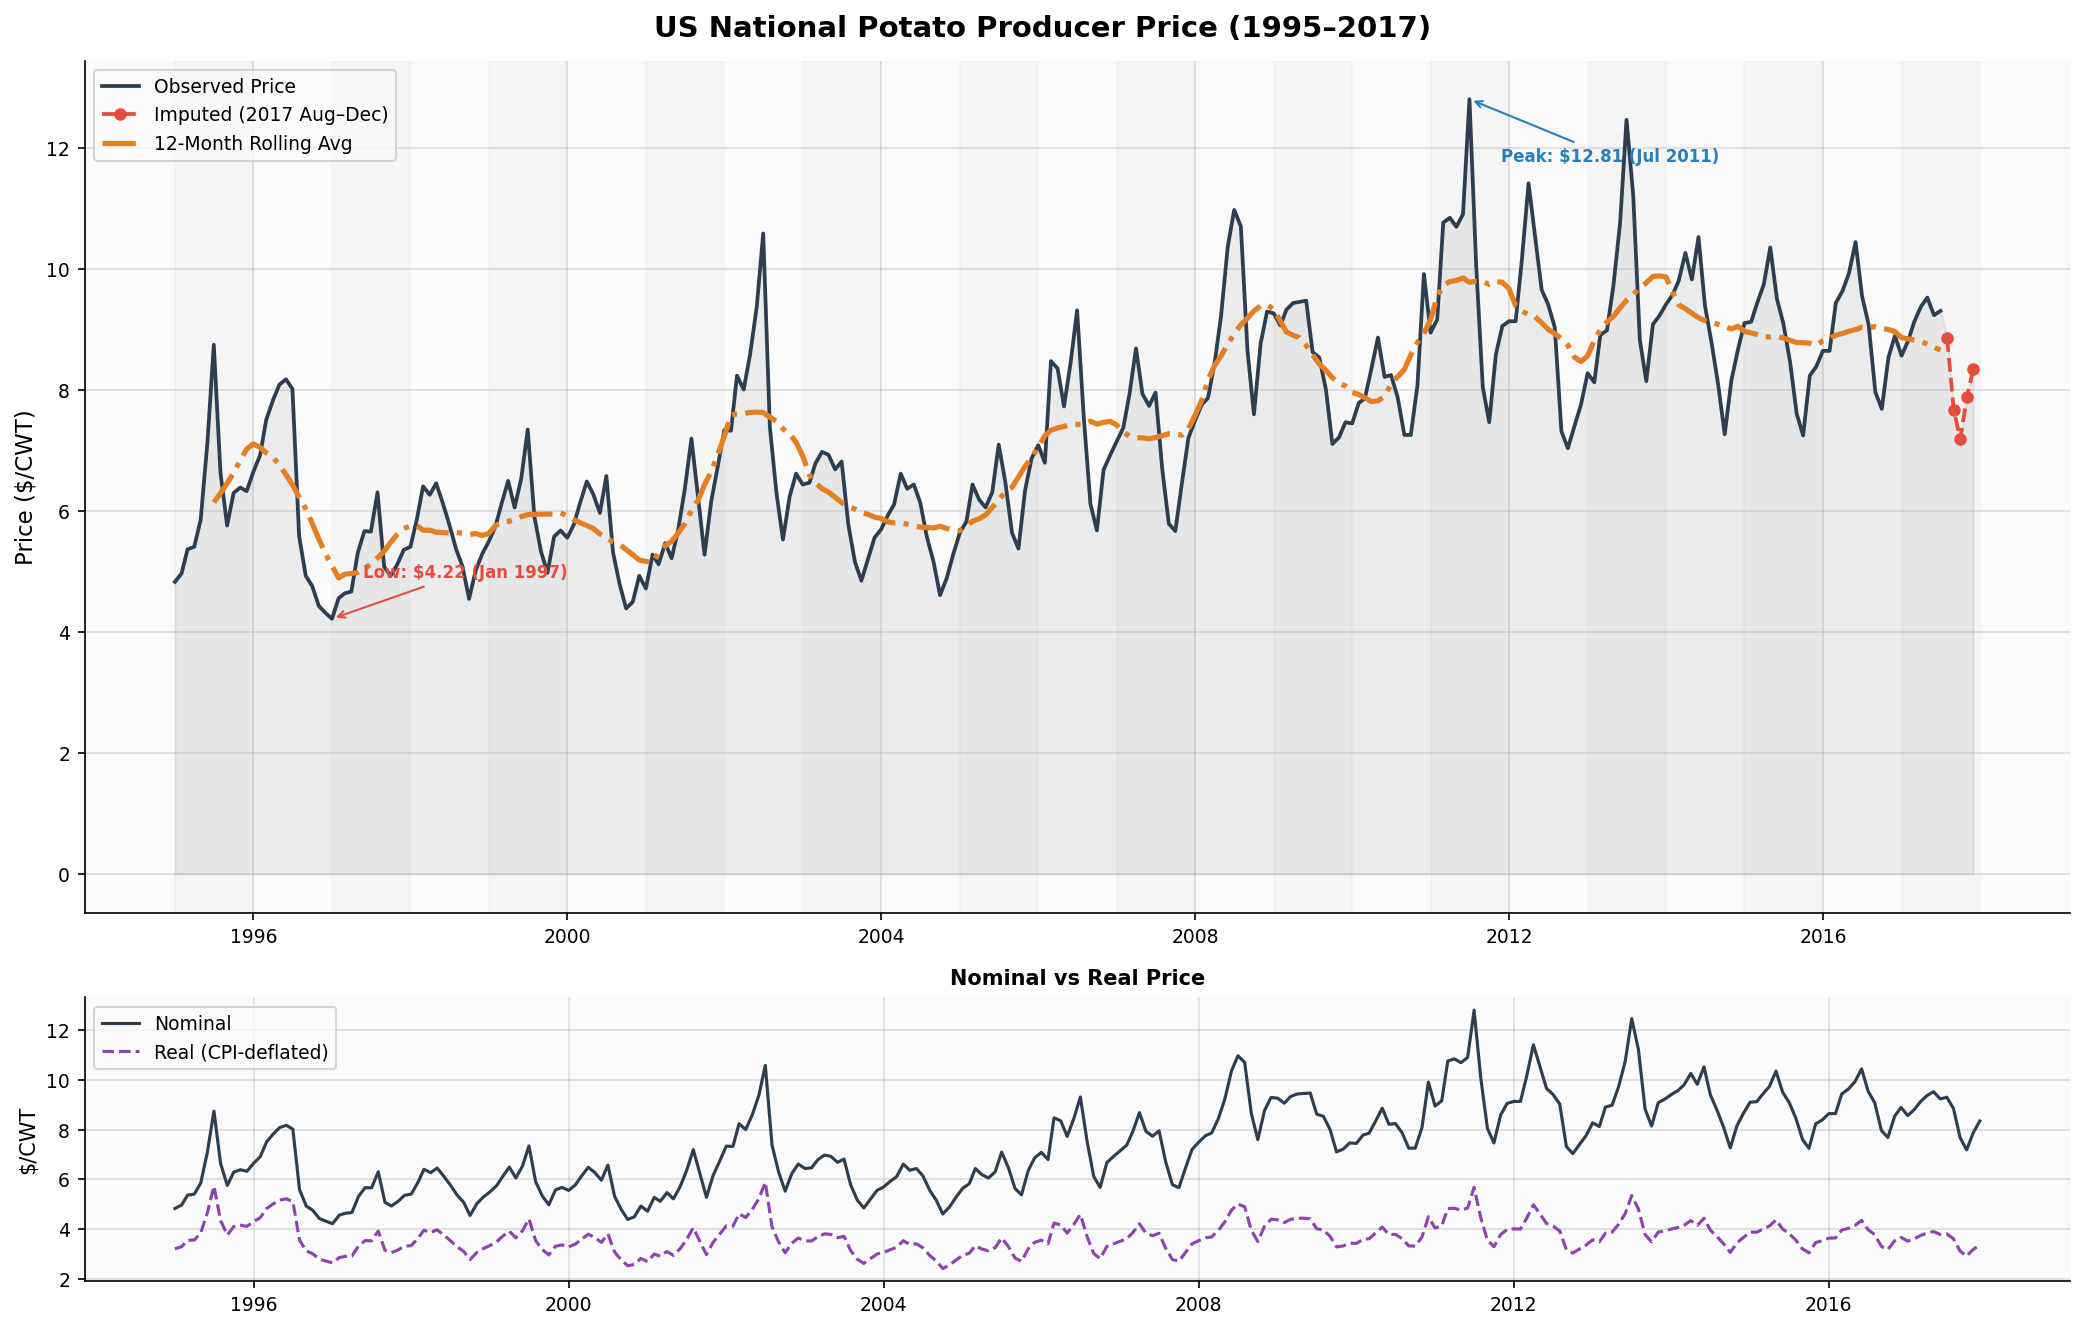

In [8]:
# ─── 2.1 Price time series — nominal vs real ─────────────────────────────────

fig, axes = plt.subplots(2, 1, figsize=(14, 9), gridspec_kw={'height_ratios': [3, 1]})
fig.suptitle('US National Potato Producer Price (1995–2017)', fontsize=14, fontweight='bold')

ax = axes[0]
actual  = df[df['Price_Imputed'] == 0]['Potato_Price_CWT']
imputed = df[df['Price_Imputed'] == 1]['Potato_Price_CWT']

ax.plot(actual.index,  actual.values,  color=MODEL_COLORS['Actual'], lw=1.8, label='Observed Price')
ax.plot(imputed.index, imputed.values, color='#E74C3C', lw=1.8, ls='--',
        marker='o', ms=5, label='Imputed (2017 Aug–Dec)')
ax.fill_between(df.index, df['Potato_Price_CWT'], alpha=0.08, color=MODEL_COLORS['Actual'])
rolling = df['Potato_Price_CWT'].rolling(12, center=True)
ax.plot(df.index, rolling.mean(), color='#E67E22', lw=2.5, ls='-.', label='12-Month Rolling Avg')

idx_max = df['Potato_Price_CWT'].idxmax()
idx_min = df['Potato_Price_CWT'].idxmin()
ax.annotate(f"Peak: ${df['Potato_Price_CWT'].max():.2f} ({idx_max.strftime('%b %Y')})",
            xy=(idx_max, df['Potato_Price_CWT'].max()),
            xytext=(15, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='#2980B9'), fontsize=8, color='#2980B9', fontweight='bold')
ax.annotate(f"Low: ${df['Potato_Price_CWT'].min():.2f} ({idx_min.strftime('%b %Y')})",
            xy=(idx_min, df['Potato_Price_CWT'].min()),
            xytext=(15, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='#E74C3C'), fontsize=8, color='#E74C3C', fontweight='bold')
for yr in range(1995, 2018, 2):
    ax.axvspan(pd.Timestamp(f'{yr}-01-01'), pd.Timestamp(f'{yr}-12-31'), alpha=0.04, color='gray')
ax.set_ylabel('Price ($/CWT)', fontsize=11)
ax.legend(loc='upper left')

axes[1].plot(df.index, df['Potato_Price_CWT'],  color=MODEL_COLORS['Actual'], lw=1.5, label='Nominal')
axes[1].plot(df.index, df['Real_Potato_Price'],  color='#8E44AD', lw=1.5, ls='--', label='Real (CPI-deflated)')
axes[1].set_ylabel('$/CWT', fontsize=10)
axes[1].set_title('Nominal vs Real Price', fontsize=10, fontweight='bold')
axes[1].legend(loc='upper left')

save_fig('fig01_price_time_series.png')
plt.show()
log_progress("Fig01 saved: price time series")


   💾 Drive/figures/fig02_stl_decomposition.png


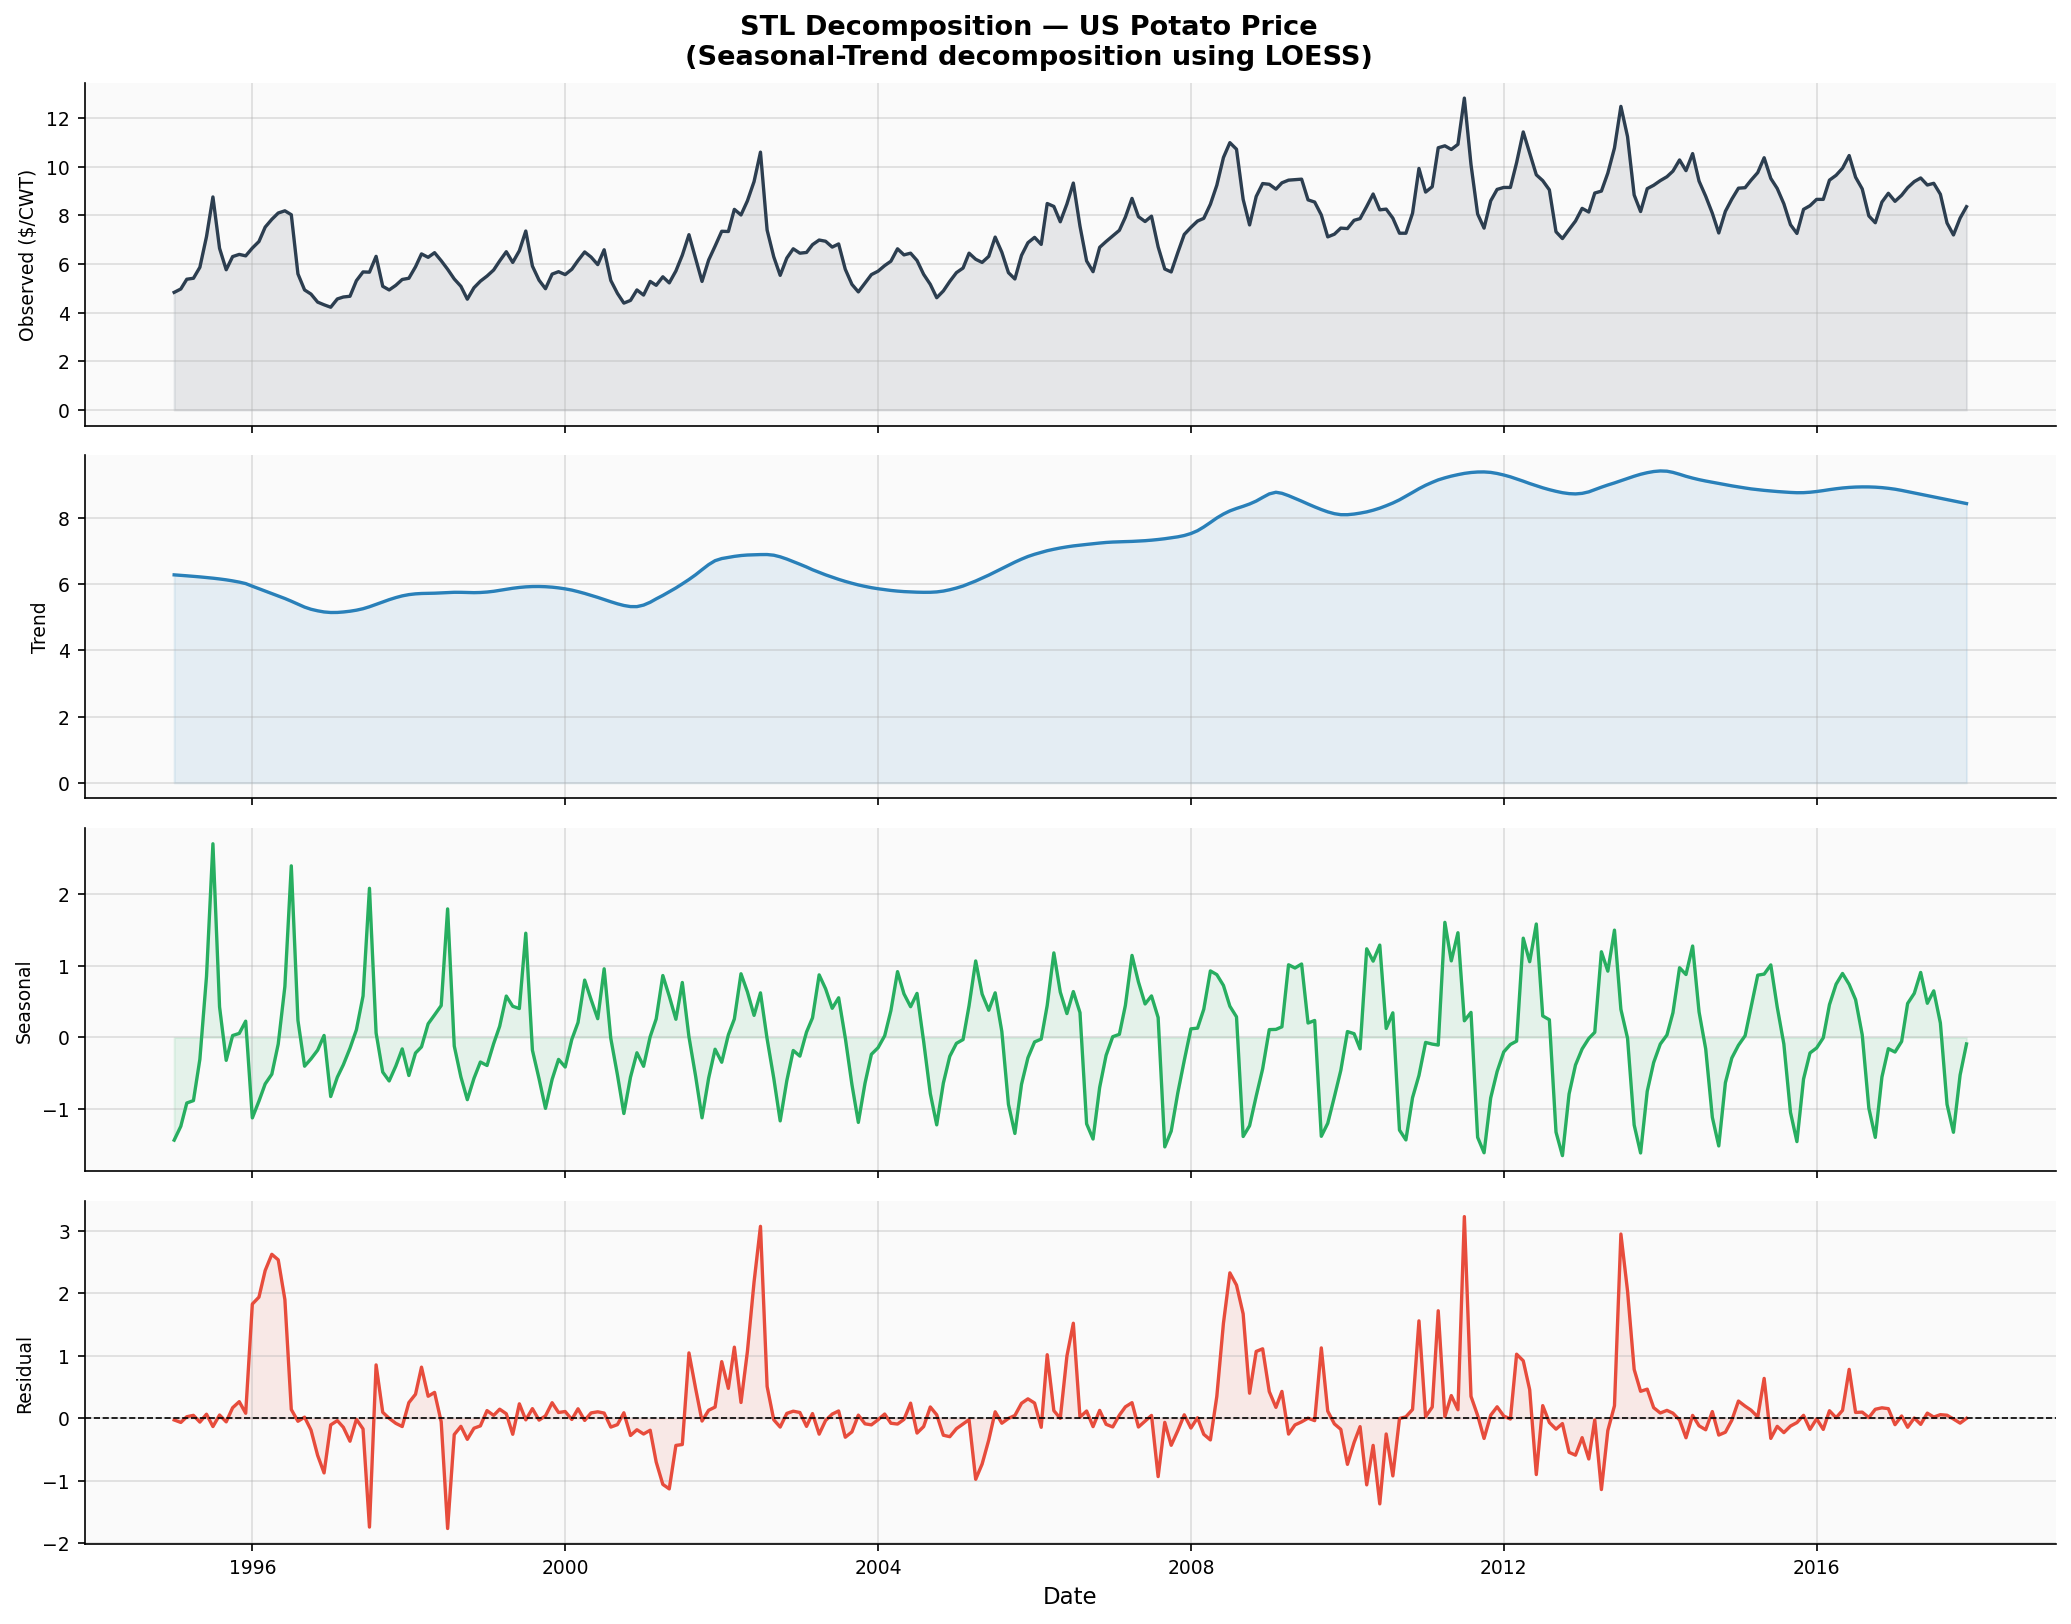

📊 STL Variance Decomposition:
   Trend:    66.0%
   Seasonal: 18.9%
   Residual: 15.2%


In [9]:
# ─── 2.2 STL Seasonal Decomposition ─────────────────────────────────────────

stl        = STL(df['Potato_Price_CWT'], period=12, robust=True)
stl_result = stl.fit()

fig, axes = plt.subplots(4, 1, figsize=(14, 11), sharex=True)
fig.suptitle('STL Decomposition — US Potato Price\n(Seasonal-Trend decomposition using LOESS)',
             fontsize=13, fontweight='bold', y=0.98)

components = [
    (df['Potato_Price_CWT'], 'Observed ($/CWT)',   MODEL_COLORS['Actual']),
    (stl_result.trend,       'Trend',               '#2980B9'),
    (stl_result.seasonal,    'Seasonal',            '#27AE60'),
    (stl_result.resid,       'Residual',            '#E74C3C'),
]
for ax, (data, label, color) in zip(axes, components):
    ax.plot(df.index, data, color=color, lw=1.6)
    ax.fill_between(df.index, data, alpha=0.1, color=color)
    ax.set_ylabel(label, fontsize=9)
    if 'Residual' in label:
        ax.axhline(0, color='black', lw=0.8, ls='--')
axes[-1].set_xlabel('Date')

save_fig('fig02_stl_decomposition.png')
plt.show()

var_s = np.var(stl_result.seasonal)
var_t = np.var(stl_result.trend)
var_r = np.var(stl_result.resid)
var_total = var_s + var_t + var_r
print("📊 STL Variance Decomposition:")
print(f"   Trend:    {var_t/var_total*100:.1f}%")
print(f"   Seasonal: {var_s/var_total*100:.1f}%")
print(f"   Residual: {var_r/var_total*100:.1f}%")
log_progress("Fig02 saved: STL decomposition")


   💾 Drive/figures/fig03_seasonal_patterns.png


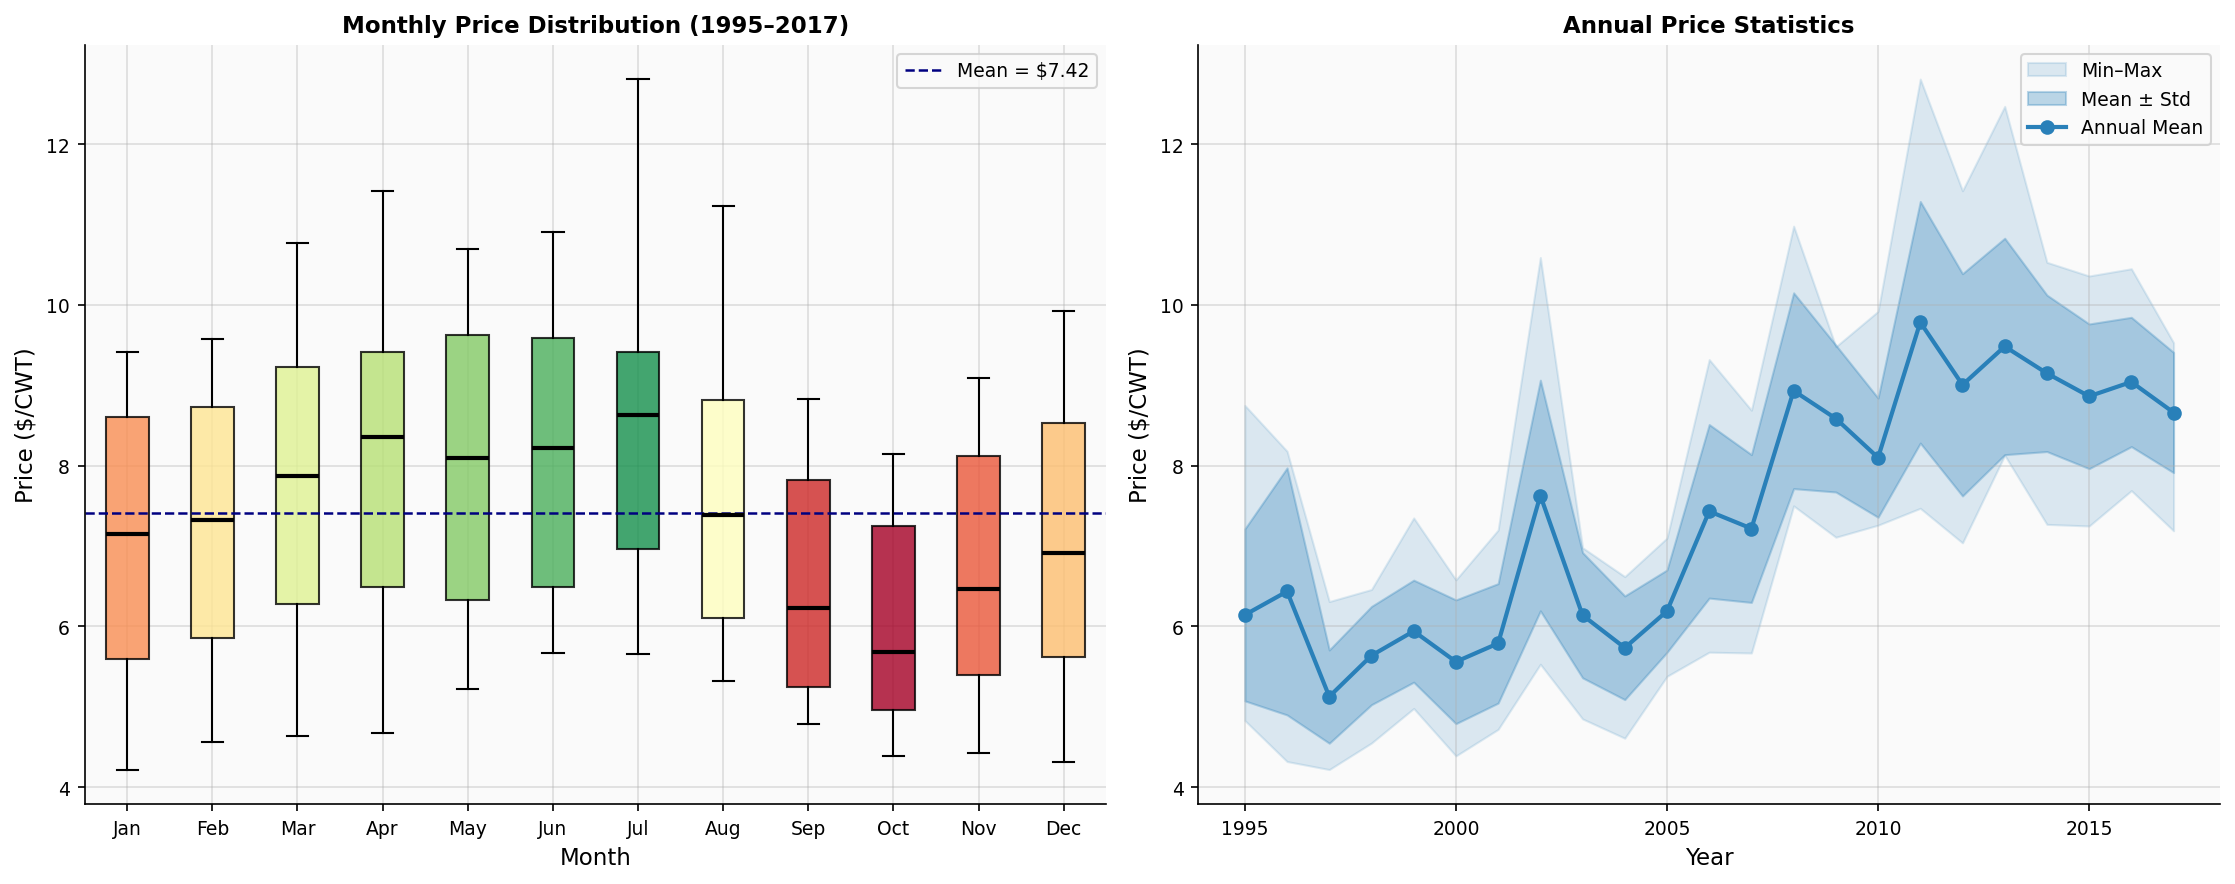


📊 Monthly Seasonal Indices:
   Jan: SI=0.953  ███████████████████
   Feb: SI=0.974  ███████████████████
   Mar: SI=1.043  ████████████████████
   Apr: SI=1.079  █████████████████████
   May: SI=1.085  █████████████████████
   Jun: SI=1.111  ██████████████████████
   Jul: SI=1.151  ███████████████████████
   Aug: SI=1.023  ████████████████████
   Sep: SI=0.884  █████████████████
   Oct: SI=0.826  ████████████████
   Nov: SI=0.909  ██████████████████
   Dec: SI=0.962  ███████████████████


In [10]:
# ─── 2.3 Seasonal box plots by month + annual stats ──────────────────────────

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
month_labels  = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthly_data  = [df[df['Month'] == m]['Potato_Price_CWT'].values for m in range(1, 13)]

bp = axes[0].boxplot(monthly_data, labels=month_labels, patch_artist=True,
                     medianprops=dict(color='black', lw=2))
monthly_means = [np.mean(d) for d in monthly_data]
sort_idx      = np.argsort(monthly_means)
color_map     = np.zeros((12, 4))
for i, idx in enumerate(sort_idx):
    color_map[idx] = plt.cm.RdYlGn(i / 12)
for patch, color in zip(bp['boxes'], color_map):
    patch.set_facecolor(color); patch.set_alpha(0.8)
axes[0].axhline(df['Potato_Price_CWT'].mean(), color='navy', ls='--', lw=1.2,
                label=f'Mean = ${df["Potato_Price_CWT"].mean():.2f}')
axes[0].set_title('Monthly Price Distribution (1995–2017)', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Month'); axes[0].set_ylabel('Price ($/CWT)')
axes[0].legend()

annual = df.groupby('Year')['Potato_Price_CWT'].agg(['mean','std','min','max']).reset_index()
years  = annual['Year'].values
axes[1].fill_between(years, annual['min'], annual['max'], alpha=0.15, color='#2980B9', label='Min–Max')
axes[1].fill_between(years, annual['mean']-annual['std'], annual['mean']+annual['std'],
                     alpha=0.3, color='#2980B9', label='Mean ± Std')
axes[1].plot(years, annual['mean'], 'o-', color='#2980B9', lw=2, ms=6, label='Annual Mean')
axes[1].set_title('Annual Price Statistics', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Year'); axes[1].set_ylabel('Price ($/CWT)')
axes[1].legend()

save_fig('fig03_seasonal_patterns.png')
plt.show()

print("\n📊 Monthly Seasonal Indices:")
overall_mean = df['Potato_Price_CWT'].mean()
for m, (label, data) in enumerate(zip(month_labels, monthly_data), 1):
    si  = np.mean(data) / overall_mean
    bar = '█' * int(si * 20)
    print(f"   {label}: SI={si:.3f}  {bar}")
log_progress("Fig03 saved: seasonal patterns")


   💾 Drive/figures/fig04_correlation_heatmap.png


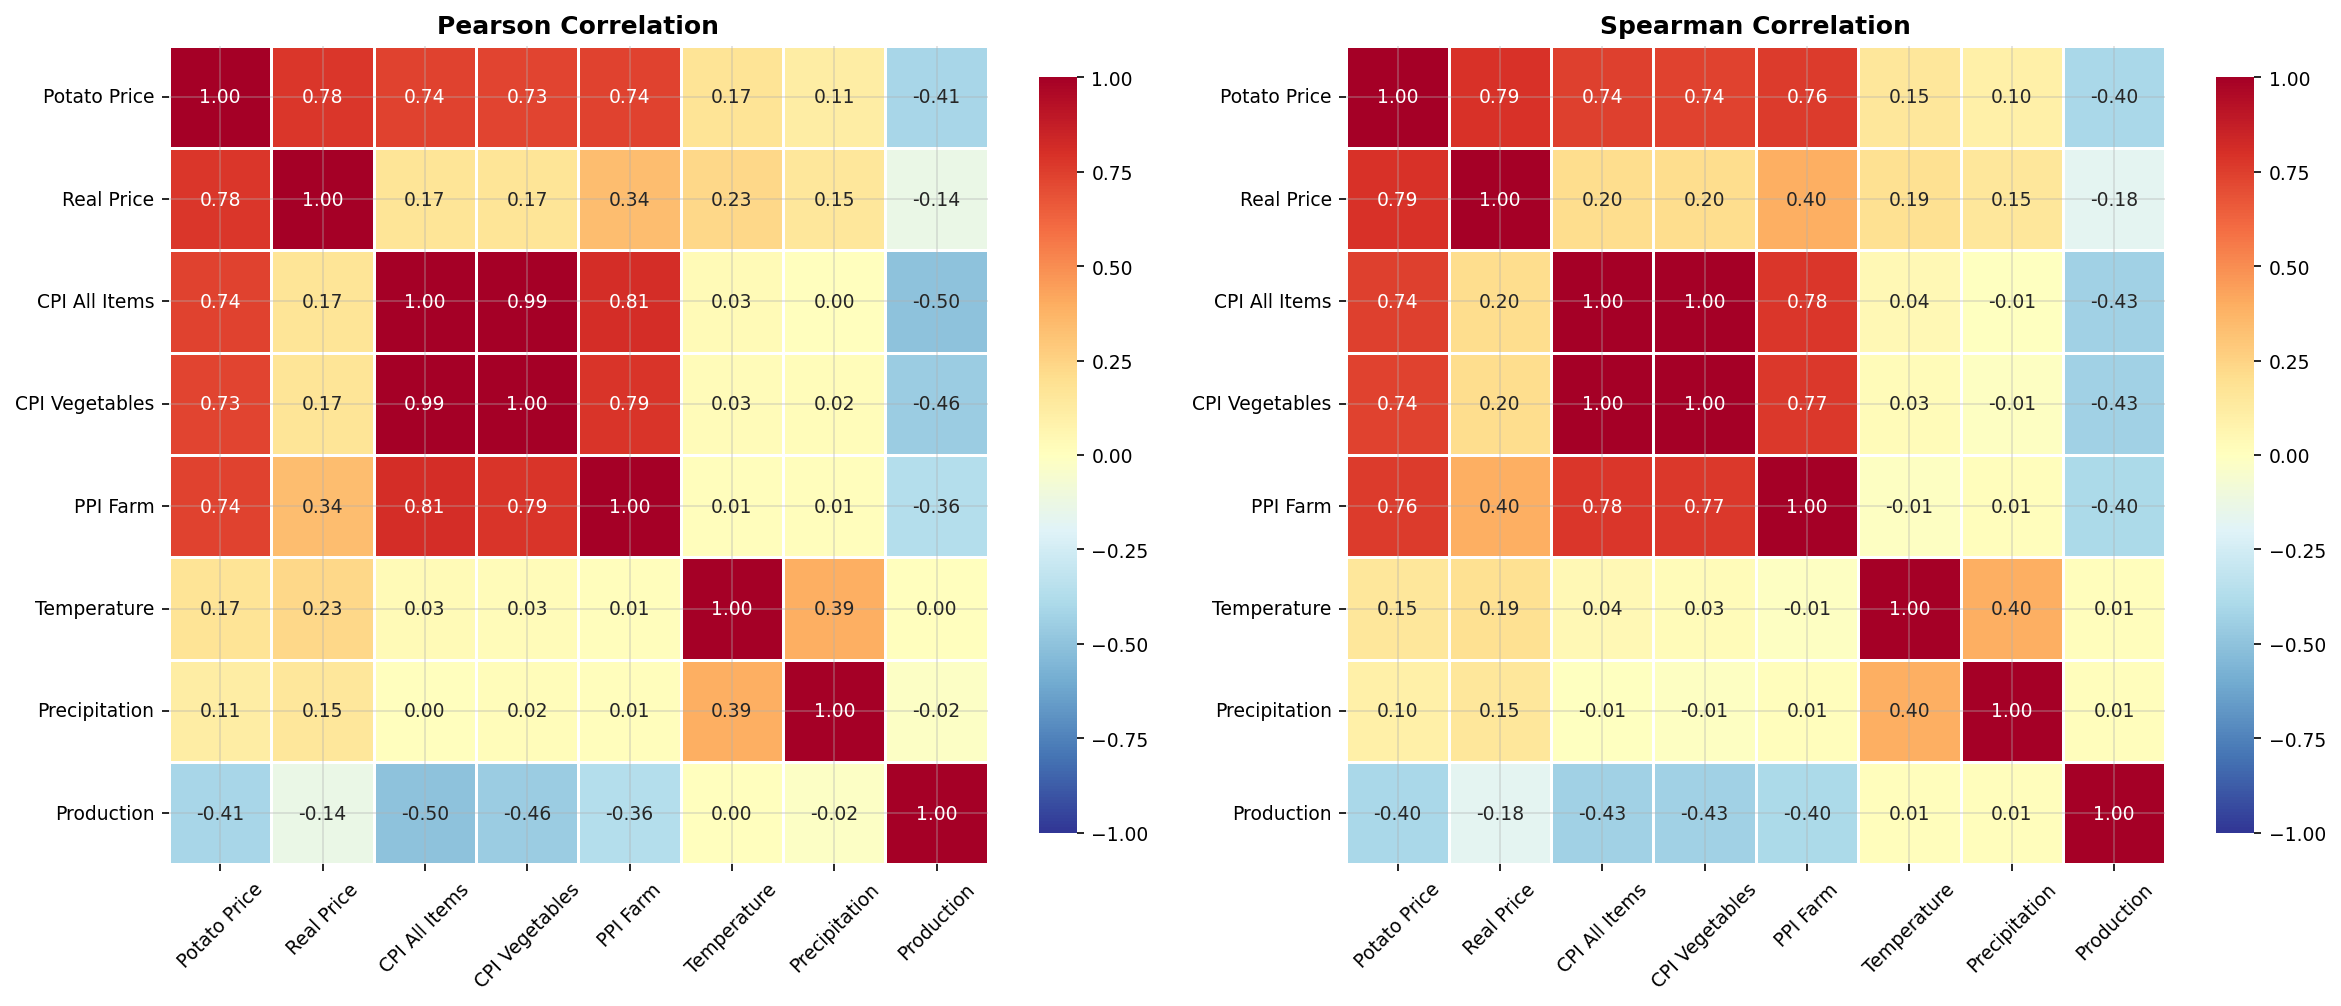


📊 Top Correlations with Potato Price:
   Real Price          : r = +0.778
   CPI All Items       : r = +0.742
   PPI Farm            : r = +0.741
   CPI Vegetables      : r = +0.734
   Production          : r = -0.409
   Temperature         : r = +0.175
   Precipitation       : r = +0.112


In [11]:
# ─── 2.4 Correlation heatmaps (Pearson + Spearman) ───────────────────────────

feature_cols = ['Potato_Price_CWT','Real_Potato_Price','CPI_AllItems',
                'CPI_Vegetables','PPI_FarmProducts','Avg_Temp_F',
                'Precipitation_inch','Annual_Production_CWT']
rename_map   = {
    'Potato_Price_CWT':      'Potato Price',  'Real_Potato_Price':     'Real Price',
    'CPI_AllItems':          'CPI All Items', 'CPI_Vegetables':        'CPI Vegetables',
    'PPI_FarmProducts':      'PPI Farm',      'Avg_Temp_F':            'Temperature',
    'Precipitation_inch':    'Precipitation', 'Annual_Production_CWT': 'Production'
}
corr_df = df[feature_cols].rename(columns=rename_map)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
for ax, method, title in zip(axes,
                              ['pearson', 'spearman'],
                              ['Pearson Correlation', 'Spearman Correlation']):
    corr = corr_df.corr(method=method)
    sns.heatmap(corr, ax=ax, annot=True, fmt='.2f', cmap='RdYlBu_r',
                center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
                annot_kws={'size': 9}, cbar_kws={'shrink': 0.8})
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)

save_fig('fig04_correlation_heatmap.png')
plt.show()

print("\n📊 Top Correlations with Potato Price:")
pc = corr_df.corr()['Potato Price'].drop('Potato Price').sort_values(key=abs, ascending=False)
for feat, val in pc.items():
    print(f"   {feat:<20}: r = {val:+.3f}")
log_progress("Fig04 saved: correlation heatmap")


   💾 Drive/figures/fig05_all_features_overview.png


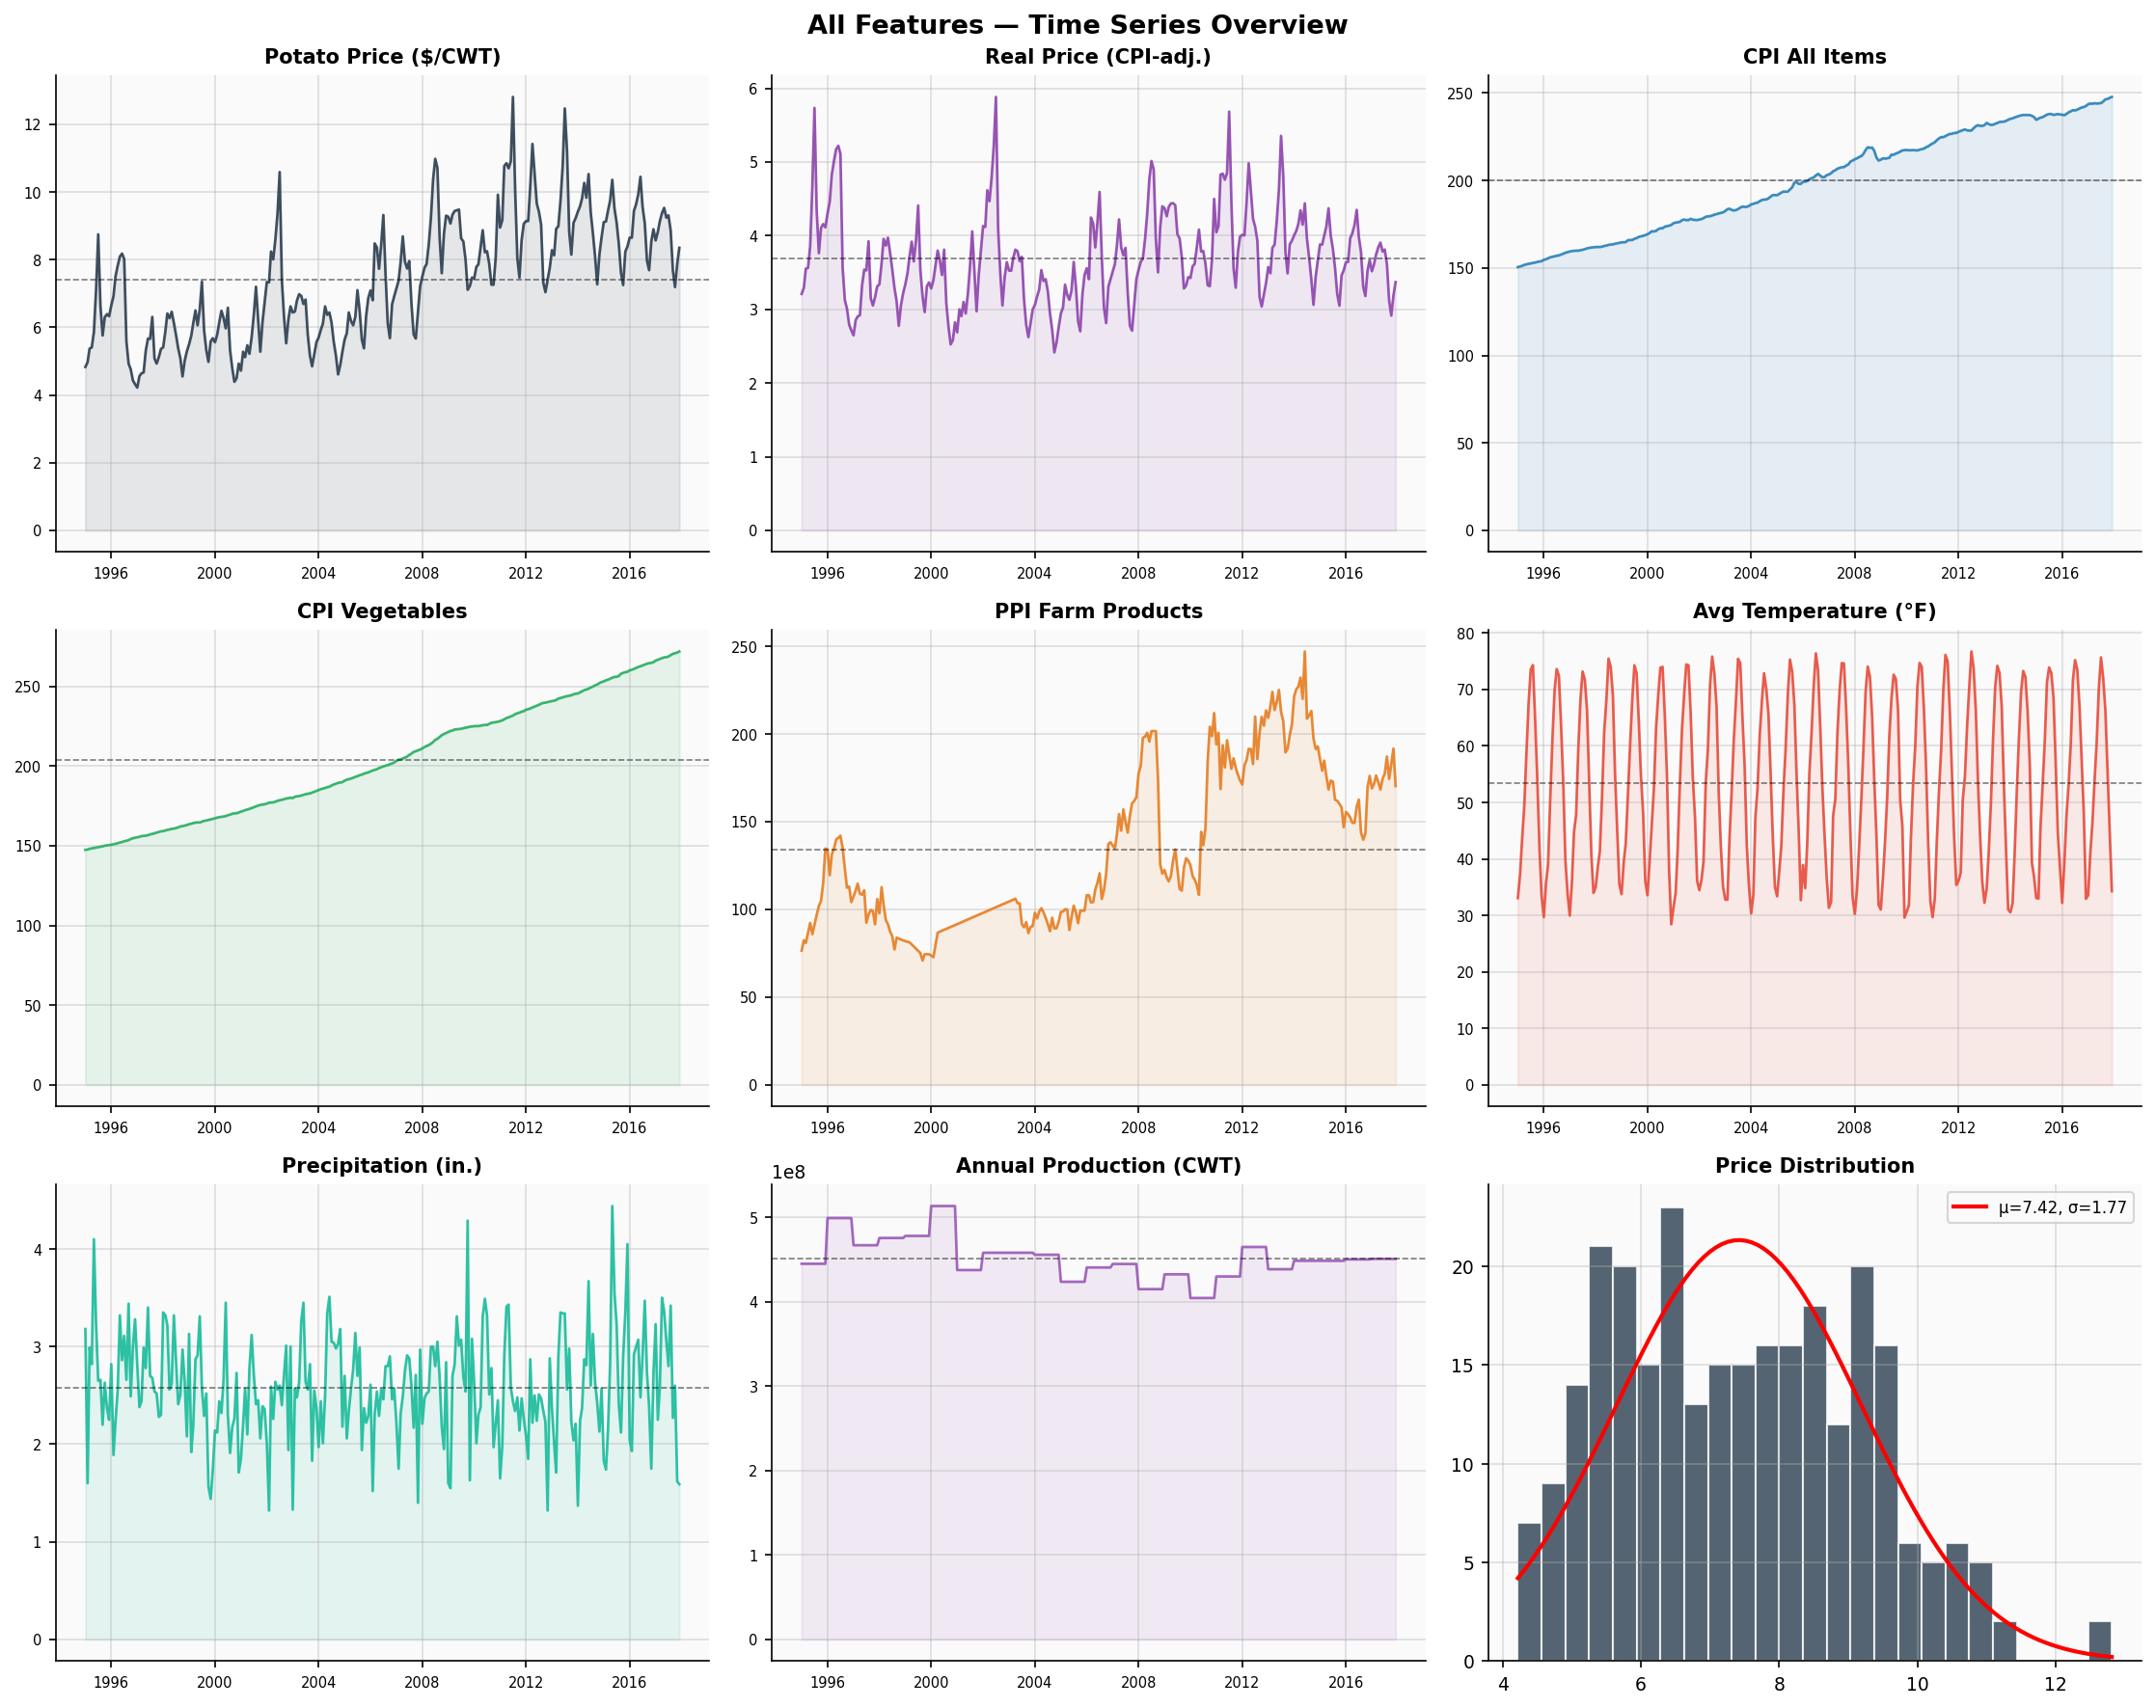

In [12]:
# ─── 2.5 All features overview ───────────────────────────────────────────────

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('All Features — Time Series Overview', fontsize=13, fontweight='bold')

plot_features = [
    ('Potato_Price_CWT',      'Potato Price ($/CWT)',   '#2C3E50'),
    ('Real_Potato_Price',     'Real Price (CPI-adj.)',   '#8E44AD'),
    ('CPI_AllItems',          'CPI All Items',           '#2980B9'),
    ('CPI_Vegetables',        'CPI Vegetables',          '#27AE60'),
    ('PPI_FarmProducts',      'PPI Farm Products',       '#E67E22'),
    ('Avg_Temp_F',            'Avg Temperature (°F)',    '#E74C3C'),
    ('Precipitation_inch',    'Precipitation (in.)',     '#1ABC9C'),
    ('Annual_Production_CWT', 'Annual Production (CWT)', '#9B59B6'),
]
for i, (col, label, color) in enumerate(plot_features):
    ax = axes[i // 3][i % 3]
    ax.plot(df.index, df[col], color=color, lw=1.3, alpha=0.9)
    ax.fill_between(df.index, df[col], alpha=0.1, color=color)
    ax.axhline(df[col].mean(), color='black', ls='--', lw=0.8, alpha=0.5)
    ax.set_title(label, fontsize=10, fontweight='bold')
    ax.tick_params(labelsize=7)

ax = axes[2][2]
ax.hist(df['Potato_Price_CWT'], bins=25, color='#2C3E50', alpha=0.8, edgecolor='white')
from scipy.stats import norm
mu, std = df['Potato_Price_CWT'].mean(), df['Potato_Price_CWT'].std()
x = np.linspace(df['Potato_Price_CWT'].min(), df['Potato_Price_CWT'].max(), 100)
ax.plot(x, norm.pdf(x,mu,std)*len(df)*(df['Potato_Price_CWT'].max()-df['Potato_Price_CWT'].min())/25,
        'r-', lw=2, label=f'μ={mu:.2f}, σ={std:.2f}')
ax.set_title('Price Distribution', fontsize=10, fontweight='bold')
ax.legend(fontsize=8)

save_fig('fig05_all_features_overview.png')
plt.show()
log_progress("Fig05 saved: all features overview")


---
## Section 3 — Stationarity & Statistical Tests (ADF + KPSS)

> Results saved to `MyDrive/potato_research/tables/table02_stationarity.csv`


In [13]:
# ─── 3.1 ADF + KPSS stationarity tests ──────────────────────────────────────

def run_stationarity_tests(series, name):
    s = series.dropna()
    adf_stat, adf_p, adf_lags, _, _, _ = adfuller(s, autolag='AIC')
    kpss_stat, kpss_p, _, _             = kpss(s, regression='ct', nlags='auto')
    adf_ok  = adf_p < 0.05
    kpss_ok = kpss_p > 0.05
    if adf_ok and kpss_ok:       conclusion = "✅ Stationary"
    elif not adf_ok and not kpss_ok: conclusion = "❌ Non-Stationary"
    else:                         conclusion = "⚠️  Inconclusive"
    return {'Variable': name, 'ADF Stat': round(adf_stat,4), 'ADF p-value': round(adf_p,4),
            'ADF Lags': adf_lags, 'KPSS Stat': round(kpss_stat,4),
            'KPSS p-value': round(kpss_p,4), 'Conclusion': conclusion}

test_vars = {
    'Potato Price':      df['Potato_Price_CWT'],
    'Real Price':        df['Real_Potato_Price'],
    'CPI All Items':     df['CPI_AllItems'],
    'CPI Vegetables':    df['CPI_Vegetables'],
    'PPI Farm Products': df['PPI_FarmProducts'],
    'Temperature':       df['Avg_Temp_F'],
    'Precipitation':     df['Precipitation_inch'],
    'Production':        df['Annual_Production_CWT'],
    'Price (1st diff)':  df['Potato_Price_CWT'].diff().dropna(),
}

stationarity_results = [run_stationarity_tests(s, n) for n, s in test_vars.items()]
stationarity_df      = pd.DataFrame(stationarity_results)

print("=" * 72)
print("  TABLE 2 — Stationarity Tests (ADF + KPSS)")
print("=" * 72)
print(stationarity_df.to_string(index=False))

save_table(stationarity_df, 'table02_stationarity.csv', 'Stationarity Tests')
log_progress("Table02 saved: stationarity tests")


/tmp/ipython-input-227/3428283924.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, _             = kpss(s, regression='ct', nlags='auto')
/tmp/ipython-input-227/3428283924.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, _             = kpss(s, regression='ct', nlags='auto')
/tmp/ipython-input-227/3428283924.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _             = kpss(s, regression='ct', nlags='auto')
/tmp/ipython-input-227/3428283924.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up 

  TABLE 2 — Stationarity Tests (ADF + KPSS)
         Variable  ADF Stat  ADF p-value  ADF Lags  KPSS Stat  KPSS p-value       Conclusion
     Potato Price   -1.7246       0.4185        14     0.1502        0.0465 ❌ Non-Stationary
       Real Price   -4.8762       0.0000        13     0.1266        0.0858     ✅ Stationary
    CPI All Items   -0.5273       0.8866        12     0.2799        0.0100 ❌ Non-Stationary
   CPI Vegetables    1.2910       0.9966         7     0.5112        0.0100 ❌ Non-Stationary
PPI Farm Products   -1.6766       0.4432         1     0.1999        0.0160 ❌ Non-Stationary
      Temperature   -3.4212       0.0103        14     0.0131        0.1000     ✅ Stationary
    Precipitation   -3.1866       0.0208        11     0.1139        0.1000     ✅ Stationary
       Production   -1.9196       0.3229        12     0.2839        0.0100 ❌ Non-Stationary
 Price (1st diff)   -5.1619       0.0000        16     0.0382        0.1000     ✅ Stationary
   💾 Drive/tables/table02_

   💾 Drive/figures/fig06_acf_pacf.png


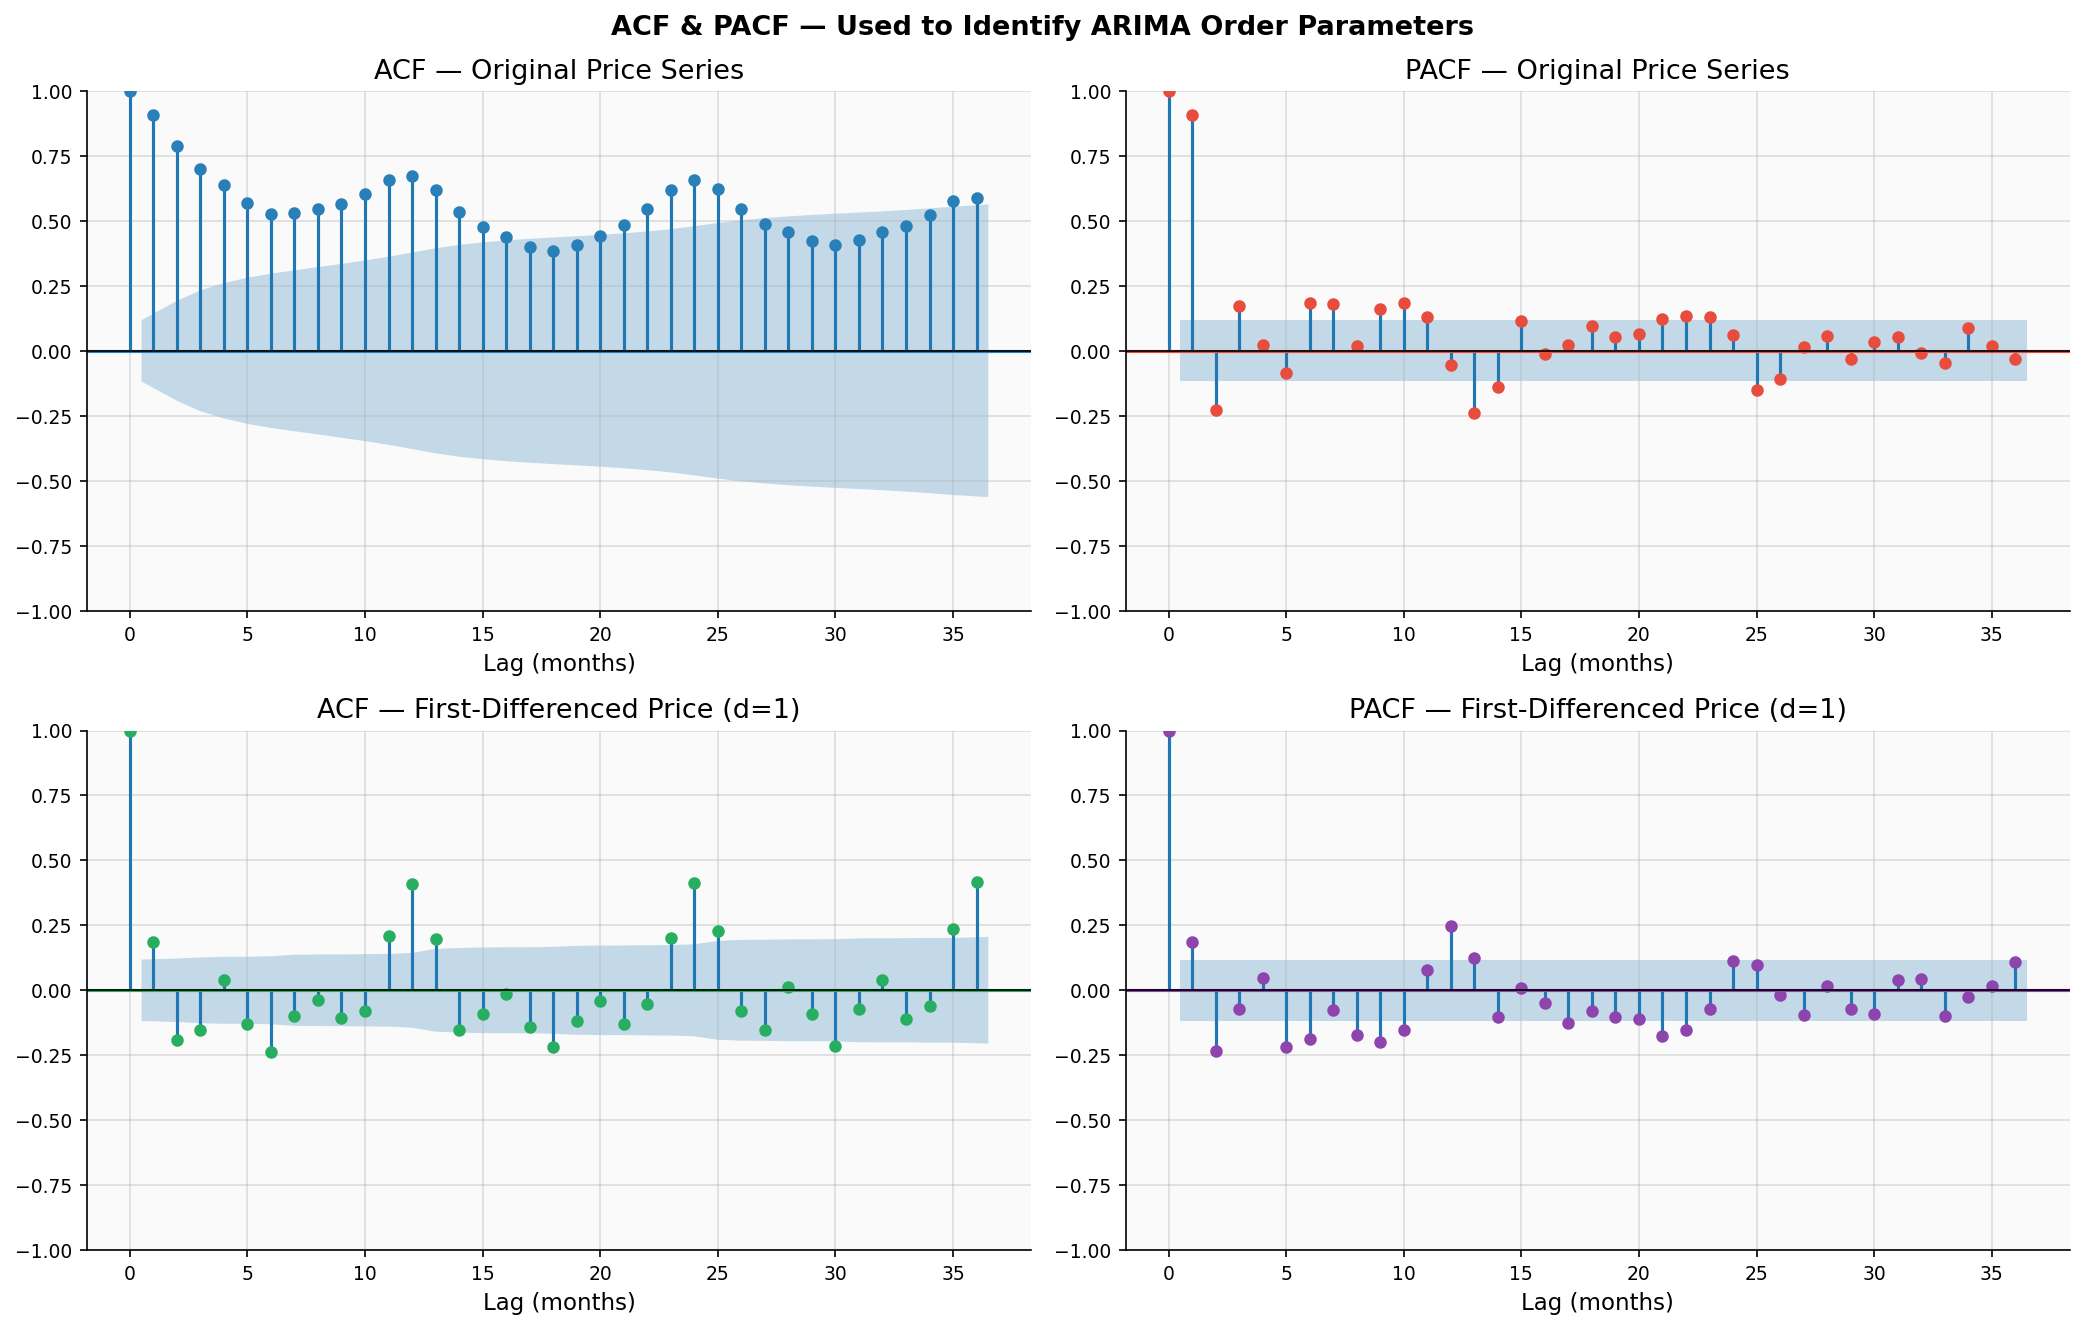

In [14]:
# ─── 3.2 ACF and PACF plots ──────────────────────────────────────────────────

fig, axes = plt.subplots(2, 2, figsize=(14, 9))
fig.suptitle('ACF & PACF — Used to Identify ARIMA Order Parameters',
             fontsize=13, fontweight='bold')

price_orig = df['Potato_Price_CWT']
price_diff = df['Potato_Price_CWT'].diff().dropna()

plot_acf( price_orig, lags=36, ax=axes[0][0], alpha=0.05, color='#2980B9')
axes[0][0].set_title('ACF — Original Price Series')
plot_pacf(price_orig, lags=36, ax=axes[0][1], alpha=0.05, color='#E74C3C', method='ywm')
axes[0][1].set_title('PACF — Original Price Series')
plot_acf( price_diff, lags=36, ax=axes[1][0], alpha=0.05, color='#27AE60')
axes[1][0].set_title('ACF — First-Differenced Price (d=1)')
plot_pacf(price_diff, lags=36, ax=axes[1][1], alpha=0.05, color='#8E44AD', method='ywm')
axes[1][1].set_title('PACF — First-Differenced Price (d=1)')
for ax in axes.flat:
    ax.set_xlabel('Lag (months)')
    ax.axhline(0, color='black', lw=0.8)

save_fig('fig06_acf_pacf.png')
plt.show()
log_progress("Fig06 saved: ACF/PACF plots")


---
## Section 4 — Granger Causality Analysis

> Results saved to `MyDrive/potato_research/tables/table03_granger_causality.csv`


In [15]:
# ─── 4.1 Granger causality tests ─────────────────────────────────────────────

granger_features = {
    'CPI All Items':     df['CPI_AllItems'],
    'CPI Vegetables':    df['CPI_Vegetables'],
    'PPI Farm Products': df['PPI_FarmProducts'],
    'Temperature':       df['Avg_Temp_F'],
    'Precipitation':     df['Precipitation_inch'],
    'Production':        df['Annual_Production_CWT'],
}
price_d1 = df['Potato_Price_CWT'].diff().dropna()

print("=" * 65)
print("  TABLE 3 — Granger Causality: Feature → Potato Price")
print("  H₀: Feature does NOT Granger-cause Potato Price")
print("  Reject H₀ at p < 0.05  →  Feature IS informative")
print("=" * 65)

granger_results = []
for feat_name, feat_series in granger_features.items():
    feat_d1  = feat_series.diff().dropna()
    combined = pd.DataFrame({'price': price_d1, 'feature': feat_d1}).dropna()
    try:
        test_out = grangercausalitytests(combined[['price','feature']], maxlag=6, verbose=False)
        best_lag, best_p = None, 1.0
        for lag, res in test_out.items():
            p = res[0]['ssr_ftest'][1]
            if p < best_p:
                best_p, best_lag = p, lag
        sig = "✅ Significant" if best_p < 0.05 else ("⚠️  Marginal" if best_p < 0.10 else "❌ Not Significant")
        granger_results.append({'Feature': feat_name, 'Best Lag (months)': best_lag,
                                 'F-test p-value': round(best_p, 4), 'Conclusion': sig})
        print(f"  {feat_name:<22} | Lag {best_lag}m | p={best_p:.4f} | {sig}")
    except Exception as e:
        print(f"  {feat_name}: Error — {e}")

granger_df = pd.DataFrame(granger_results)
save_table(granger_df, 'table03_granger_causality.csv')
log_progress("Table03 saved: Granger causality")


  TABLE 3 — Granger Causality: Feature → Potato Price
  H₀: Feature does NOT Granger-cause Potato Price
  Reject H₀ at p < 0.05  →  Feature IS informative
  CPI All Items          | Lag 1m | p=0.0459 | ✅ Significant
  CPI Vegetables         | Lag 1m | p=0.1858 | ❌ Not Significant
  PPI Farm Products      | Lag 5m | p=0.0157 | ✅ Significant
  Temperature            | Lag 4m | p=0.0000 | ✅ Significant
  Precipitation          | Lag 6m | p=0.0000 | ✅ Significant
  Production             | Lag 2m | p=0.2212 | ❌ Not Significant
   💾 Drive/tables/table03_granger_causality.csv  (6 rows)


---
## Section 5 — Feature Engineering

> Creates lag features, rolling statistics, cyclical month encoding, and interaction terms.  
> Engineered dataset saved to `MyDrive/potato_research/datasets/potato_features.csv`


In [16]:
# ─── 5.1 Build all ML features ───────────────────────────────────────────────

df_feat = df.copy()

# ── Price lag features (autoregressive terms) ────────────────────────────────
for lag in [1, 2, 3, 6, 12]:
    df_feat[f'Price_lag{lag}'] = df_feat['Potato_Price_CWT'].shift(lag)

# ── Lagged external variables ────────────────────────────────────────────────
for col in ['CPI_AllItems','CPI_Vegetables','PPI_FarmProducts','Avg_Temp_F','Precipitation_inch']:
    for lag in [1, 3, 6]:
        df_feat[f'{col}_lag{lag}'] = df_feat[col].shift(lag)

# ── Rolling statistics ────────────────────────────────────────────────────────
df_feat['Price_roll3_mean']  = df_feat['Potato_Price_CWT'].shift(1).rolling(3).mean()
df_feat['Price_roll6_mean']  = df_feat['Potato_Price_CWT'].shift(1).rolling(6).mean()
df_feat['Price_roll3_std']   = df_feat['Potato_Price_CWT'].shift(1).rolling(3).std()
df_feat['Price_roll12_mean'] = df_feat['Potato_Price_CWT'].shift(1).rolling(12).mean()
df_feat['Temp_roll3_mean']   = df_feat['Avg_Temp_F'].rolling(3).mean()
df_feat['Prec_roll3_mean']   = df_feat['Precipitation_inch'].rolling(3).mean()

# ── Cyclical month encoding (better than one-hot for ML) ─────────────────────
df_feat['Month_sin'] = np.sin(2 * np.pi * df_feat['Month'] / 12)
df_feat['Month_cos'] = np.cos(2 * np.pi * df_feat['Month'] / 12)

# ── Year trend ────────────────────────────────────────────────────────────────
df_feat['Year_trend'] = (df_feat['Year'] - df_feat['Year'].min()).astype(float)

# ── Log price ─────────────────────────────────────────────────────────────────
df_feat['Log_Price'] = np.log(df_feat['Potato_Price_CWT'])

# ── Interaction: input cost × supply pressure ─────────────────────────────────
df_feat['PPI_x_Production'] = (df_feat['PPI_FarmProducts'] / df_feat['PPI_FarmProducts'].mean()) *                                (df_feat['Annual_Production_CWT'] / df_feat['Annual_Production_CWT'].mean())

# ── Drop NaN rows created by lag operations ───────────────────────────────────
df_feat = df_feat.dropna()

# ── Define core ML feature list ───────────────────────────────────────────────
TARGET      = 'Potato_Price_CWT'
FEATURES_ML = [
    'Price_lag1','Price_lag2','Price_lag3','Price_lag6','Price_lag12',
    'CPI_AllItems','CPI_Vegetables','PPI_FarmProducts',
    'Avg_Temp_F','Precipitation_inch','Annual_Production_CWT',
    'Price_roll3_mean','Price_roll6_mean','Price_roll12_mean',
    'Month_sin','Month_cos','Year_trend','PPI_x_Production'
]

# ── Save engineered features to Drive ────────────────────────────────────────
feat_save_path = f'{DATA_DIR}/potato_features.csv'
df_feat.to_csv(feat_save_path)
print(f"✅ Feature engineering complete")
print(f"   Features: {len(FEATURES_ML)} | Rows: {len(df_feat)}")
print(f"   💾 Saved: {feat_save_path}")
log_progress(f"Feature engineering complete: {len(FEATURES_ML)} features, {len(df_feat)} rows")


✅ Feature engineering complete
   Features: 18 | Rows: 264
   💾 Saved: /content/drive/MyDrive/potato_research/datasets/potato_features.csv


---
## Section 6 — Train / Validation / Test Split (70 / 15 / 15)

> Chronological split — no random shuffling (prevents data leakage).  
> Split info saved to `MyDrive/potato_research/tables/table04_data_split.csv`


  TRAIN / VALIDATION / TEST SPLIT (Chronological)
  Training   (184 obs): Jan 1996 → Apr 2011
  Validation ( 40 obs): May 2011   → Aug 2014
  Test       ( 40 obs): Sep 2014   → Dec 2017
  Ratios: 70% / 15% / 15%
   💾 Drive/tables/table04_data_split.csv  (3 rows)
   💾 Drive/figures/fig07_train_test_split.png


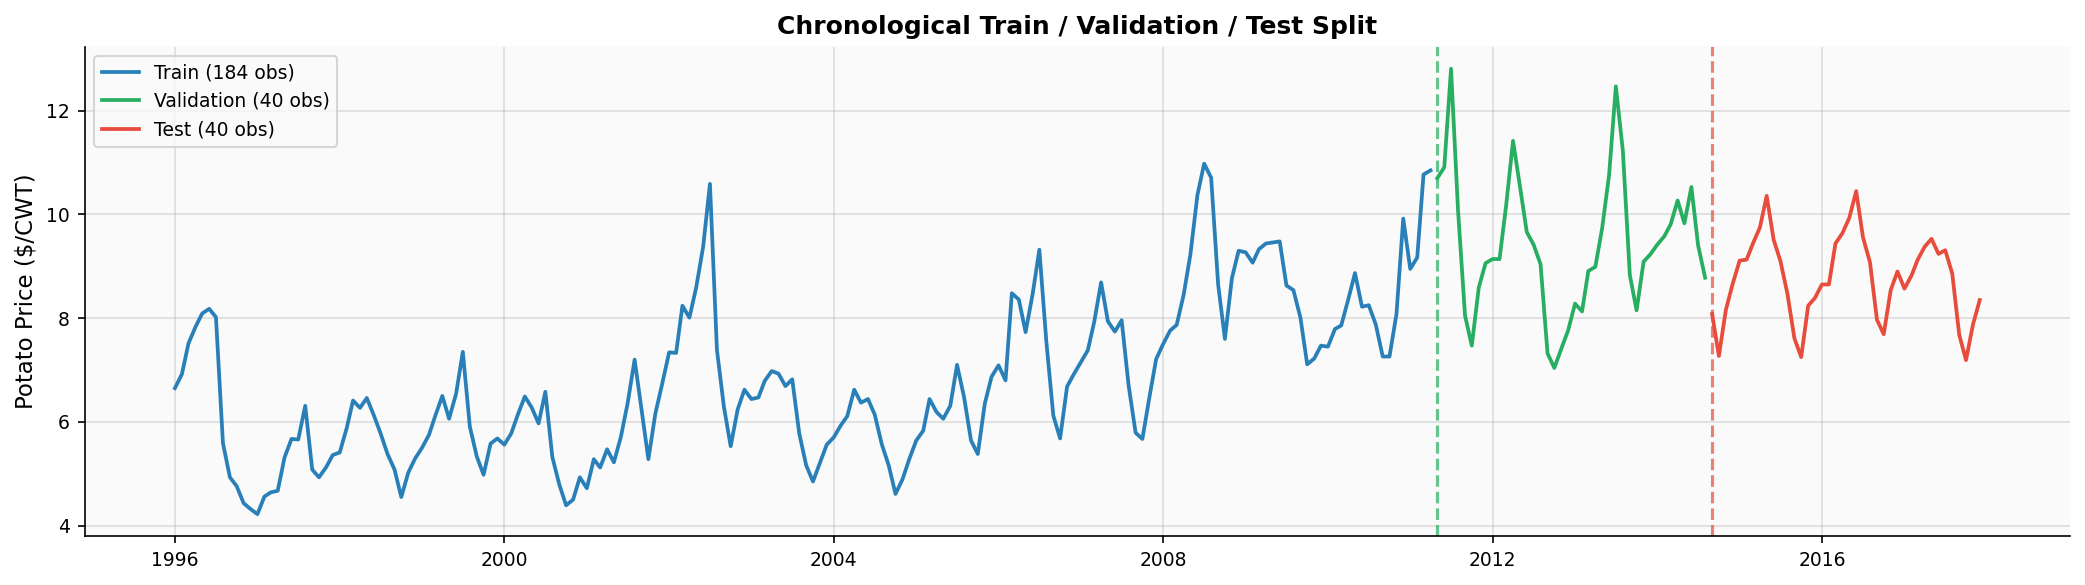

In [17]:
# ─── 6.1 Chronological split ─────────────────────────────────────────────────

total_n   = len(df_feat)
train_end = int(total_n * 0.70)
val_end   = int(total_n * 0.85)

df_train = df_feat.iloc[:train_end].copy()
df_val   = df_feat.iloc[train_end:val_end].copy()
df_test  = df_feat.iloc[val_end:].copy()

print("=" * 58)
print("  TRAIN / VALIDATION / TEST SPLIT (Chronological)")
print("=" * 58)
print(f"  Training   ({len(df_train):3d} obs): {df_train.index[0].strftime('%b %Y')} → {df_train.index[-1].strftime('%b %Y')}")
print(f"  Validation ({len(df_val):3d} obs): {df_val.index[0].strftime('%b %Y')}   → {df_val.index[-1].strftime('%b %Y')}")
print(f"  Test       ({len(df_test):3d} obs): {df_test.index[0].strftime('%b %Y')}   → {df_test.index[-1].strftime('%b %Y')}")
print(f"  Ratios: {len(df_train)/total_n*100:.0f}% / {len(df_val)/total_n*100:.0f}% / {len(df_test)/total_n*100:.0f}%")
print("=" * 58)

# Arrays for ML models
X_train = df_train[FEATURES_ML].values;  y_train = df_train[TARGET].values
X_val   = df_val[FEATURES_ML].values;    y_val   = df_val[TARGET].values
X_test  = df_test[FEATURES_ML].values;   y_test  = df_test[TARGET].values
X_trainval = np.vstack([X_train, X_val]); y_trainval = np.concatenate([y_train, y_val])

# Price series for ARIMA/SARIMA
price_train    = df_train[TARGET]
price_val      = df_val[TARGET]
price_test     = df_test[TARGET]
price_trainval = pd.concat([price_train, price_val])

n_test = len(price_test)

# Save split info
split_info = pd.DataFrame([
    {'Set':'Train',      'N':len(df_train), 'Start':df_train.index[0].strftime('%Y-%m'), 'End':df_train.index[-1].strftime('%Y-%m'), 'Pct':f"{len(df_train)/total_n*100:.0f}%"},
    {'Set':'Validation', 'N':len(df_val),   'Start':df_val.index[0].strftime('%Y-%m'),   'End':df_val.index[-1].strftime('%Y-%m'),   'Pct':f"{len(df_val)/total_n*100:.0f}%"},
    {'Set':'Test',       'N':len(df_test),  'Start':df_test.index[0].strftime('%Y-%m'),  'End':df_test.index[-1].strftime('%Y-%m'),  'Pct':f"{len(df_test)/total_n*100:.0f}%"},
])
save_table(split_info, 'table04_data_split.csv')

# Plot
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df_train.index, df_train[TARGET], color='#2980B9', lw=1.8, label=f'Train ({len(df_train)} obs)')
ax.plot(df_val.index,   df_val[TARGET],   color='#27AE60', lw=1.8, label=f'Validation ({len(df_val)} obs)')
ax.plot(df_test.index,  df_test[TARGET],  color='#E74C3C', lw=1.8, label=f'Test ({len(df_test)} obs)')
ax.axvline(df_val.index[0],  color='#27AE60', ls='--', lw=1.5, alpha=0.7)
ax.axvline(df_test.index[0], color='#E74C3C', ls='--', lw=1.5, alpha=0.7)
ax.set_title('Chronological Train / Validation / Test Split', fontsize=12, fontweight='bold')
ax.set_ylabel('Potato Price ($/CWT)'); ax.legend(loc='upper left')
save_fig('fig07_train_test_split.png')
plt.show()
log_progress("Section 6 complete: data split ready")


---
## Section 7 — Model 1: ARIMA (Statistical Baseline)

> Model saved to `MyDrive/potato_research/models/arima_model.pkl`


In [18]:
# ─── 7.1 Auto ARIMA — find optimal order ─────────────────────────────────────

print("🔍 Running auto_arima (searching optimal p,d,q via AIC)...")

arima_auto = pm.auto_arima(
    price_trainval, start_p=0, max_p=5, start_q=0, max_q=5,
    d=None, seasonal=False, information_criterion='aic',
    stepwise=True, trace=True, error_action='ignore',
    suppress_warnings=True, n_fits=50
)
print(f"\n✅ Best ARIMA order: {arima_auto.order}  |  AIC: {arima_auto.aic():.4f}")


🔍 Running auto_arima (searching optimal p,d,q via AIC)...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=510.027, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=504.514, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=500.541, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=508.063, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=501.690, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=499.724, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=478.571, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=478.478, Time=0.43 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.16 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=478.725, Time=2.05 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=472.355, Time=1.28 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=470.477, Time=0.89 sec
 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


📊 ARIMA Performance on Test Set:
   Model          : ARIMA
   RMSE           : 0.9413
   MAE            : 0.7406
   MAPE           : 9.0148
   R²             : -0.3417
   Theil's U      : 1.6386
   💾 Drive/models/arima_model.pkl  (1993 KB)
   💾 Drive/figures/fig08_arima_forecast.png


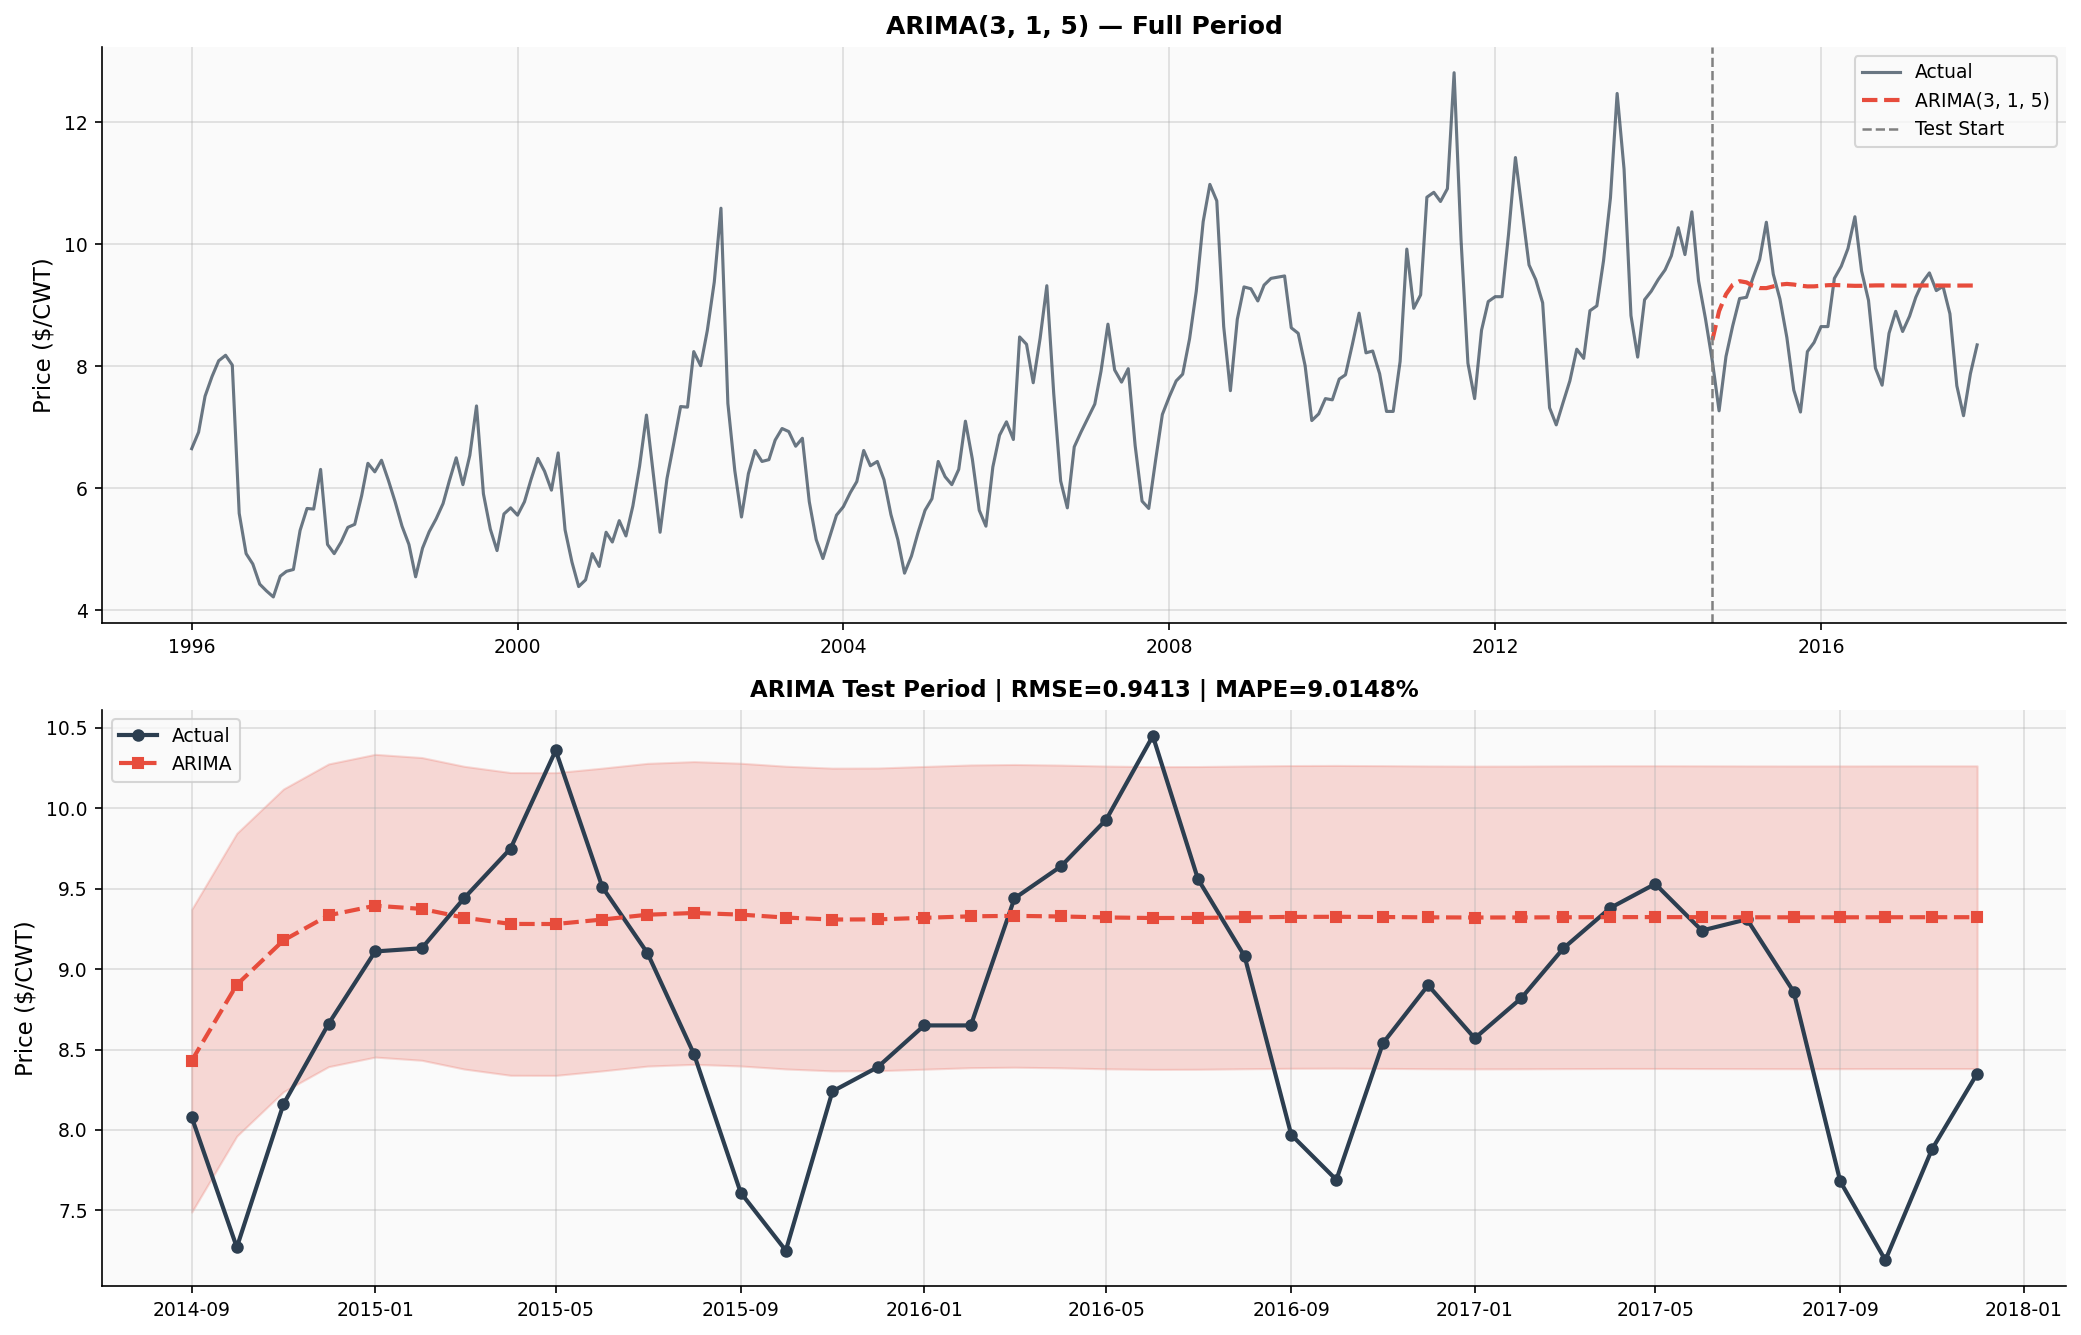

In [19]:
# ─── 7.2 Fit, forecast, evaluate, save ───────────────────────────────────────

p, d, q    = arima_auto.order
arima_fit  = ARIMA(price_trainval, order=(p,d,q)).fit()
arima_preds = pd.Series(arima_fit.forecast(steps=n_test).values, index=price_test.index)

arima_metrics = compute_metrics(y_test, arima_preds.values, 'ARIMA')
results_table.append(arima_metrics)

print("📊 ARIMA Performance on Test Set:")
for k, v in arima_metrics.items():
    print(f"   {k:<15}: {v}")

# Save model
save_model({'model': arima_fit, 'order': arima_auto.order}, 'arima_model.pkl')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 9))
axes[0].plot(df_feat.index, df_feat[TARGET], color=MODEL_COLORS['Actual'], lw=1.5, label='Actual', alpha=0.7)
axes[0].plot(arima_preds.index, arima_preds, color=MODEL_COLORS['ARIMA'], lw=2, ls='--', label=f'ARIMA{arima_auto.order}')
axes[0].axvline(price_test.index[0], color='gray', ls='--', lw=1.2, label='Test Start')
axes[0].set_title(f'ARIMA{arima_auto.order} — Full Period', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price ($/CWT)'); axes[0].legend()

axes[1].plot(price_test.index, y_test,              'o-', color=MODEL_COLORS['Actual'], lw=2, ms=5, label='Actual')
axes[1].plot(arima_preds.index, arima_preds.values, 's--', color=MODEL_COLORS['ARIMA'], lw=2, ms=5, label='ARIMA')
axes[1].fill_between(price_test.index, arima_preds.values-arima_metrics['RMSE'],
                     arima_preds.values+arima_metrics['RMSE'], alpha=0.2, color=MODEL_COLORS['ARIMA'])
axes[1].set_title(f'ARIMA Test Period | RMSE={arima_metrics["RMSE"]} | MAPE={arima_metrics["MAPE"]}%',
                  fontsize=11, fontweight='bold')
axes[1].set_ylabel('Price ($/CWT)'); axes[1].legend()
save_fig('fig08_arima_forecast.png')
plt.show()
log_progress(f"ARIMA complete: RMSE={arima_metrics['RMSE']}")


---
## Section 8 — Model 2: SARIMA (Seasonal ARIMA)

> Model saved to `MyDrive/potato_research/models/sarima_model.pkl`


In [20]:
# ─── 8.1 Auto SARIMA ─────────────────────────────────────────────────────────

print("🔍 Running auto_arima with seasonal=True, m=12...")

sarima_auto = pm.auto_arima(
    price_trainval, start_p=0, max_p=3, start_q=0, max_q=3,
    start_P=0, max_P=2, start_Q=0, max_Q=2,
    d=None, D=None, m=12, seasonal=True,
    information_criterion='aic', stepwise=True, trace=True,
    error_action='ignore', suppress_warnings=True, n_fits=50
)
print(f"\n✅ Best SARIMA: {sarima_auto.order} × {sarima_auto.seasonal_order}  |  AIC: {sarima_auto.aic():.4f}")


🔍 Running auto_arima with seasonal=True, m=12...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=510.027, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=479.863, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=488.518, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=508.063, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=504.514, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=457.465, Time=0.50 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=455.465, Time=0.41 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=479.217, Time=0.14 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=457.465, Time=0.49 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=459.030, Time=2.14 sec


📊 SARIMA Performance on Test Set:
   Model          : SARIMA
   RMSE           : 1.0325
   MAE            : 0.9184
   MAPE           : 10.1511
   R²             : -0.6145
   Theil's U      : 1.7974


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


   💾 Drive/models/sarima_model.pkl  (21277 KB)
   💾 Drive/figures/fig09_sarima_forecast.png


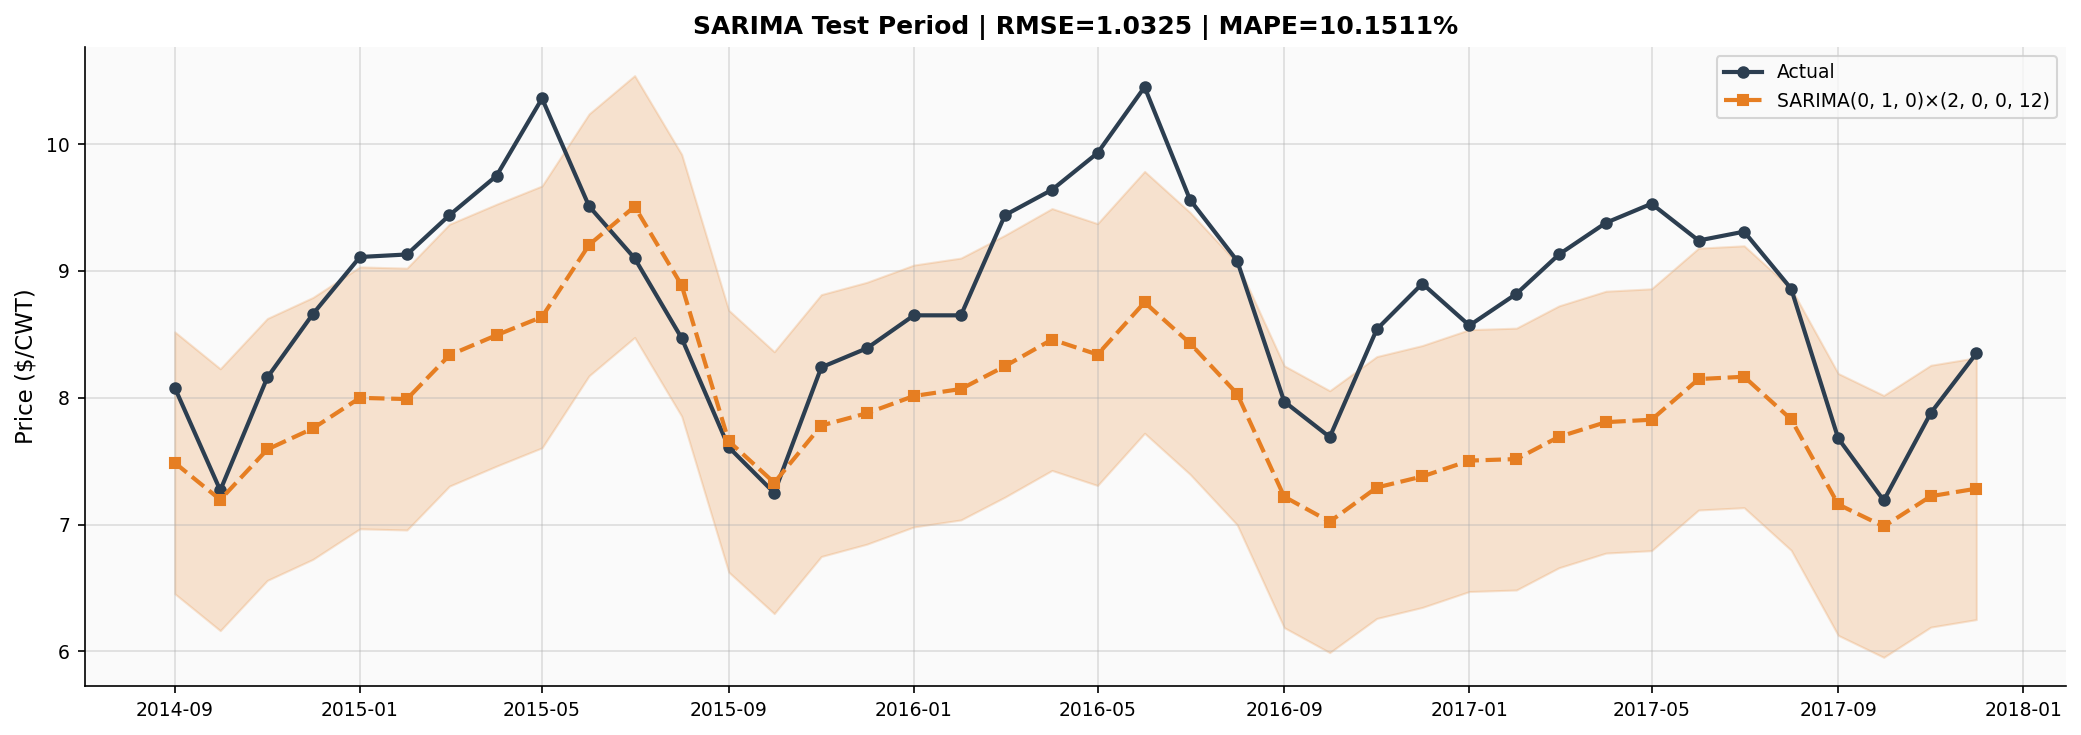

In [21]:
# ─── 8.2 Fit, forecast, evaluate, save ───────────────────────────────────────

p,d,q          = sarima_auto.order
P,D,Q,seasonal = sarima_auto.seasonal_order
sarima_fit     = SARIMAX(price_trainval, order=(p,d,q), seasonal_order=(P,D,Q,seasonal),
                         enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
sarima_preds   = pd.Series(sarima_fit.forecast(steps=n_test).values, index=price_test.index)

sarima_metrics = compute_metrics(y_test, sarima_preds.values, 'SARIMA')
results_table.append(sarima_metrics)

print("📊 SARIMA Performance on Test Set:")
for k, v in sarima_metrics.items():
    print(f"   {k:<15}: {v}")

save_model({'model': sarima_fit, 'order': sarima_auto.order, 'seasonal': sarima_auto.seasonal_order},
           'sarima_model.pkl')

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(price_test.index, y_test,               'o-', color=MODEL_COLORS['Actual'], lw=2, ms=5, label='Actual')
ax.plot(sarima_preds.index, sarima_preds.values,'s--', color=MODEL_COLORS['SARIMA'], lw=2, ms=5,
        label=f'SARIMA{sarima_auto.order}×{sarima_auto.seasonal_order}')
ax.fill_between(price_test.index, sarima_preds.values-sarima_metrics['RMSE'],
                sarima_preds.values+sarima_metrics['RMSE'], alpha=0.2, color=MODEL_COLORS['SARIMA'])
ax.set_title(f'SARIMA Test Period | RMSE={sarima_metrics["RMSE"]} | MAPE={sarima_metrics["MAPE"]}%',
             fontsize=12, fontweight='bold')
ax.set_ylabel('Price ($/CWT)'); ax.legend()
save_fig('fig09_sarima_forecast.png')
plt.show()
log_progress(f"SARIMA complete: RMSE={sarima_metrics['RMSE']}")


---
## Section 9 — Model 3: Random Forest

> Model saved to `MyDrive/potato_research/models/rf_model.pkl`


🔍 Random Forest — RandomizedSearchCV (5-fold TimeSeriesCV)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✅ Best RF: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 15}
   CV RMSE: 0.9325

📊 Random Forest Test Performance:
   Model          : Random Forest
   RMSE           : 0.4694
   MAE            : 0.3897
   MAPE           : 4.5034
   R²             : 0.6663
   Theil's U      : 0.8172
   💾 Drive/models/rf_model.pkl  (1457 KB)
   💾 Drive/figures/fig10_rf_results.png


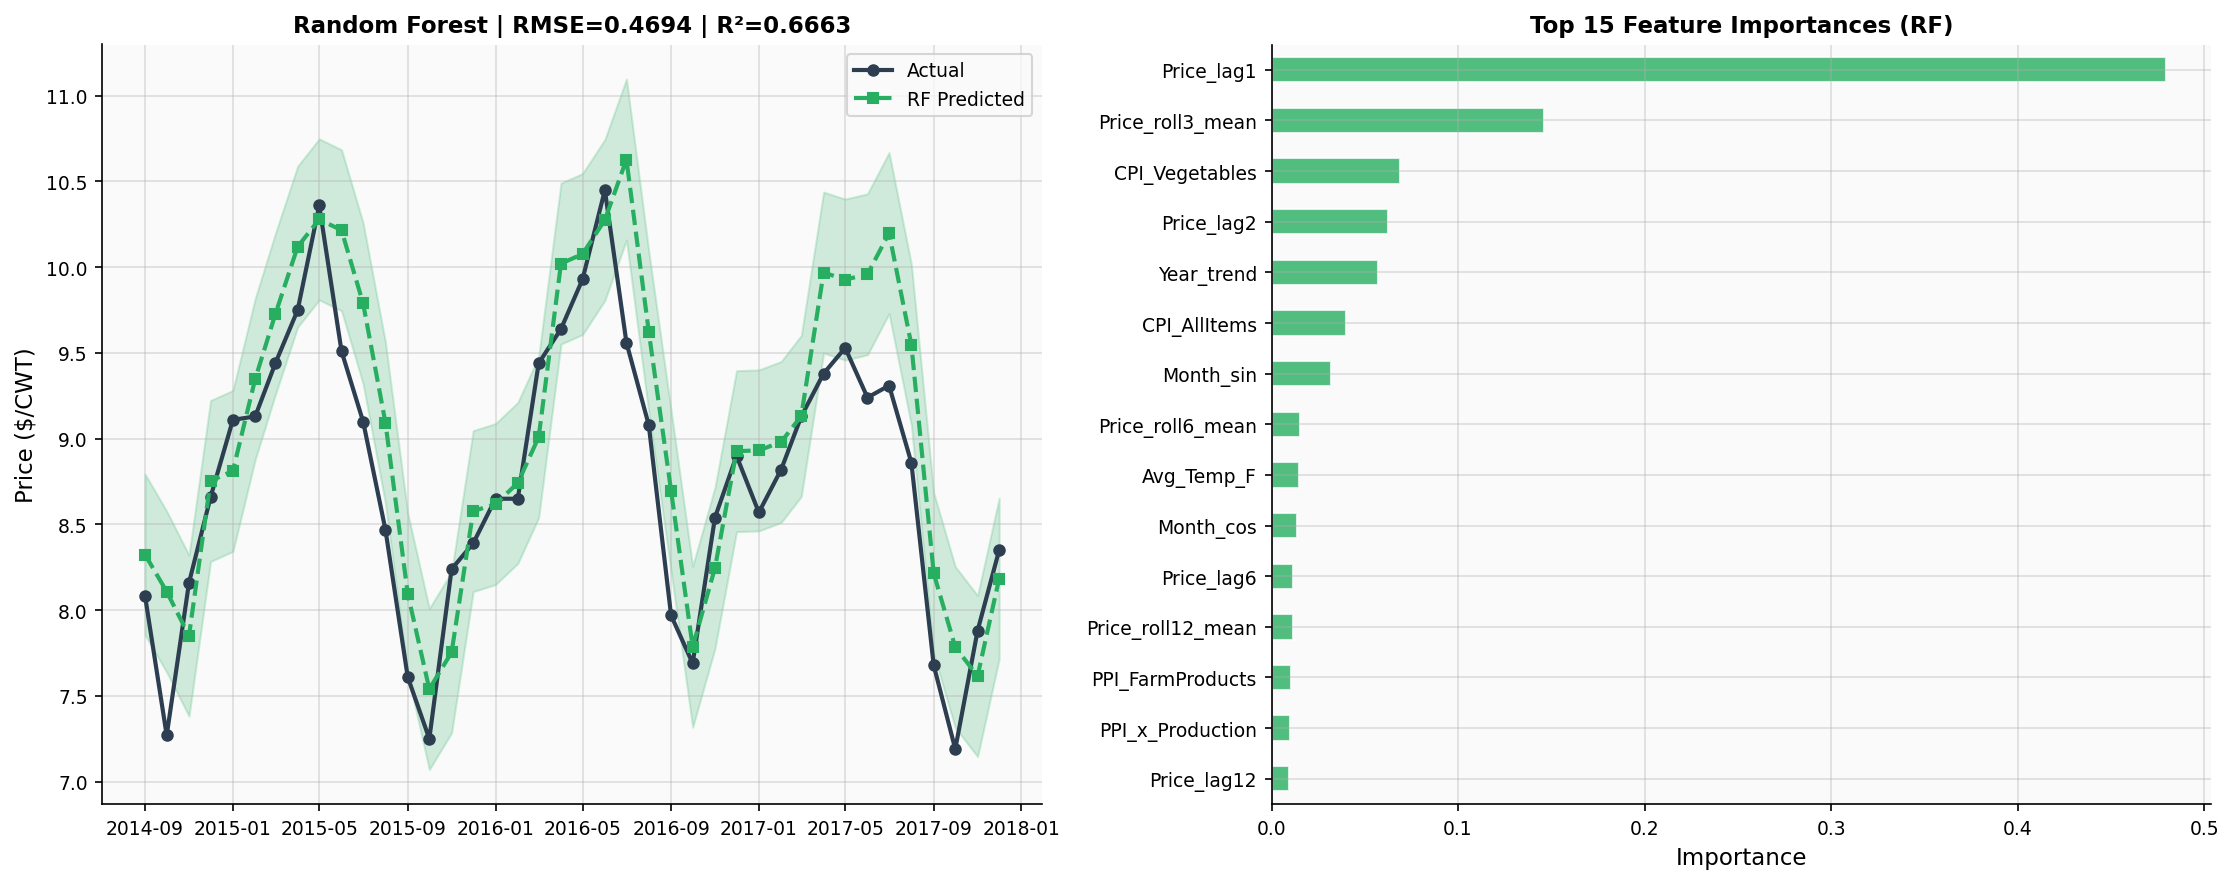

In [22]:
# ─── 9.1 Hyperparameter search + train ───────────────────────────────────────

param_grid_rf = {
    'n_estimators':      [100, 200, 300, 500],
    'max_depth':         [None, 5, 8, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_features':      ['sqrt', 'log2', 0.5],
}
tscv = TimeSeriesSplit(n_splits=5)

print("🔍 Random Forest — RandomizedSearchCV (5-fold TimeSeriesCV)...")
rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid_rf, n_iter=30, cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42, n_jobs=-1, verbose=1
)
rf_search.fit(X_trainval, y_trainval)
rf_model = rf_search.best_estimator_
rf_preds = rf_model.predict(X_test)

rf_metrics = compute_metrics(y_test, rf_preds, 'Random Forest')
results_table.append(rf_metrics)

print(f"\n✅ Best RF: {rf_search.best_params_}")
print(f"   CV RMSE: {-rf_search.best_score_:.4f}")
print("\n📊 Random Forest Test Performance:")
for k, v in rf_metrics.items():
    print(f"   {k:<15}: {v}")

save_model(rf_model, 'rf_model.pkl')

feat_imp_rf = pd.Series(rf_model.feature_importances_, index=FEATURES_ML).sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(price_test.index, y_test,   'o-', color=MODEL_COLORS['Actual'],        lw=2, ms=5, label='Actual')
axes[0].plot(price_test.index, rf_preds, 's--', color=MODEL_COLORS['Random Forest'], lw=2, ms=5, label='RF Predicted')
axes[0].fill_between(price_test.index, rf_preds-rf_metrics['RMSE'], rf_preds+rf_metrics['RMSE'],
                     alpha=0.2, color=MODEL_COLORS['Random Forest'])
axes[0].set_title(f'Random Forest | RMSE={rf_metrics["RMSE"]} | R²={rf_metrics["R²"]}',
                  fontsize=11, fontweight='bold')
axes[0].set_ylabel('Price ($/CWT)'); axes[0].legend()

feat_imp_rf.head(15).plot(kind='barh', ax=axes[1], color='#27AE60', alpha=0.8, edgecolor='white')
axes[1].set_title('Top 15 Feature Importances (RF)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Importance'); axes[1].invert_yaxis()
save_fig('fig10_rf_results.png')
plt.show()
log_progress(f"RF complete: RMSE={rf_metrics['RMSE']}")


---
## Section 10 — Model 4: XGBoost ⭐ (Primary Model)

> Model saved to `MyDrive/potato_research/models/xgboost_model.pkl`  
> This is the primary model used for SHAP analysis in Section 14.


In [23]:
# ─── 10.1 XGBoost hyperparameter search ──────────────────────────────────────

param_grid_xgb = {
    'n_estimators':     [100, 200, 300, 500],
    'max_depth':        [3, 4, 5, 6, 8],
    'learning_rate':    [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample':        [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'reg_alpha':        [0, 0.01, 0.1],
    'reg_lambda':       [1, 1.5, 2],
}
print("🔍 XGBoost — RandomizedSearchCV (50 configs, 5-fold TimeSeriesCV)...")

xgb_search = RandomizedSearchCV(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    param_grid_xgb, n_iter=50, cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42, n_jobs=-1, verbose=1
)
xgb_search.fit(X_trainval, y_trainval)
xgb_model = xgb_search.best_estimator_
xgb_preds = xgb_model.predict(X_test)

xgb_metrics = compute_metrics(y_test, xgb_preds, 'XGBoost')
results_table.append(xgb_metrics)

print(f"\n✅ Best XGBoost params:")
for k, v in xgb_search.best_params_.items():
    print(f"   {k:<25}: {v}")
print(f"   CV RMSE: {-xgb_search.best_score_:.4f}")
print("\n📊 XGBoost Test Performance:")
for k, v in xgb_metrics.items():
    print(f"   {k:<15}: {v}")

save_model(xgb_model, 'xgboost_model.pkl')

# Save best params to Drive as JSON
params_path = f'{MODELS_DIR}/xgboost_best_params.json'
with open(params_path, 'w') as f:
    json.dump(xgb_search.best_params_, f, indent=2)
print(f"   💾 Drive/models/xgboost_best_params.json")
log_progress(f"XGBoost complete: RMSE={xgb_metrics['RMSE']}")


🔍 XGBoost — RandomizedSearchCV (50 configs, 5-fold TimeSeriesCV)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ Best XGBoost params:
   subsample                : 0.7
   reg_lambda               : 1
   reg_alpha                : 0.1
   n_estimators             : 500
   min_child_weight         : 3
   max_depth                : 4
   learning_rate            : 0.01
   colsample_bytree         : 1.0
   CV RMSE: 0.7926

📊 XGBoost Test Performance:
   Model          : XGBoost
   RMSE           : 0.4499
   MAE            : 0.3588
   MAPE           : 4.0691
   R²             : 0.6935
   Theil's U      : 0.7832
   💾 Drive/models/xgboost_model.pkl  (718 KB)
   💾 Drive/models/xgboost_best_params.json


   💾 Drive/figures/fig11_xgboost_results.png


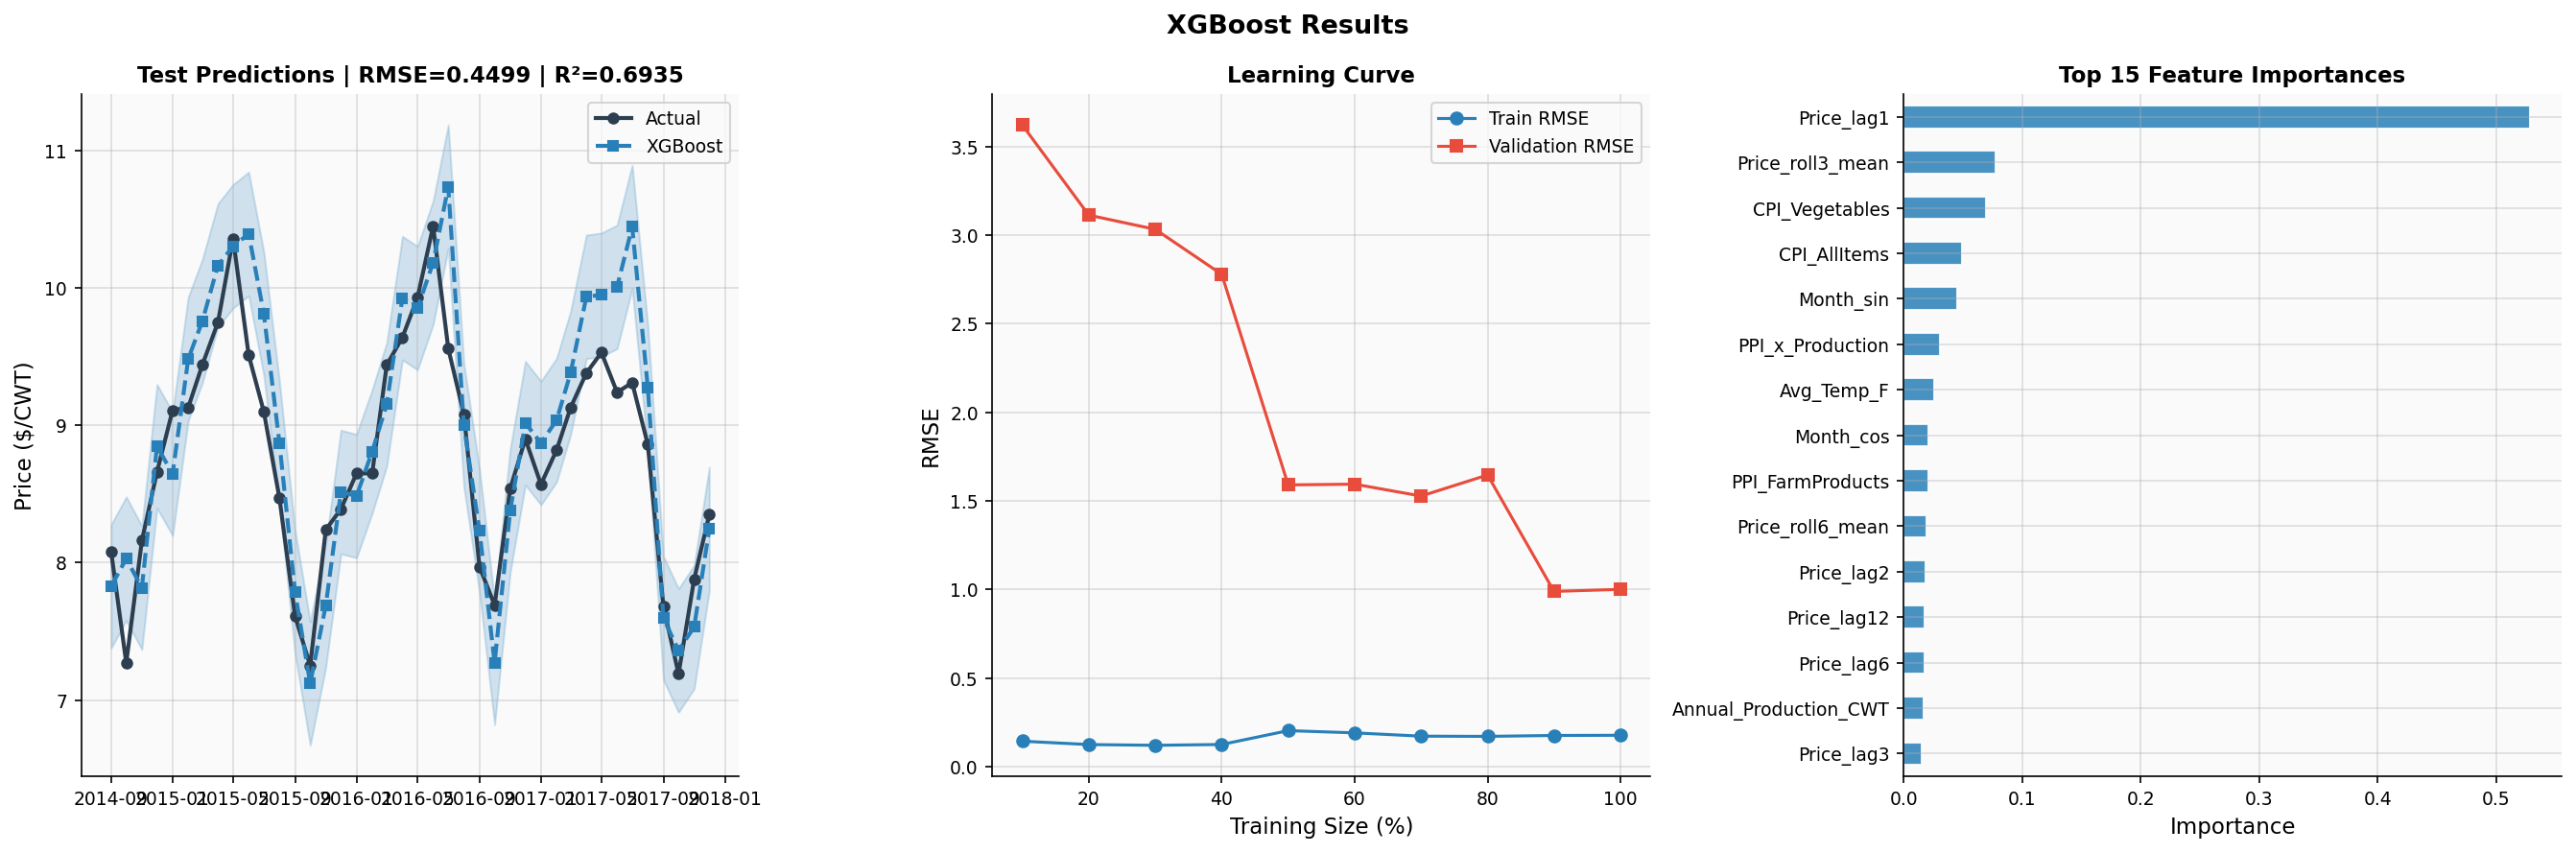

In [24]:
# ─── 10.2 XGBoost plots ──────────────────────────────────────────────────────

feat_imp_xgb = pd.Series(xgb_model.feature_importances_, index=FEATURES_ML).sort_values(ascending=False)

# Learning curve
train_sizes   = np.linspace(0.1, 1.0, 10)
tr_rmse, vl_rmse = [], []
for frac in train_sizes:
    n = max(int(len(X_train)*frac), 10)
    m = xgb.XGBRegressor(**xgb_search.best_params_, objective='reg:squarederror', random_state=42, n_jobs=-1)
    m.fit(X_train[:n], y_train[:n])
    tr_rmse.append(np.sqrt(mean_squared_error(y_train[:n], m.predict(X_train[:n]))))
    vl_rmse.append(np.sqrt(mean_squared_error(y_val, m.predict(X_val))))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('XGBoost Results', fontsize=13, fontweight='bold')

axes[0].plot(price_test.index, y_test,    'o-', color=MODEL_COLORS['Actual'],   lw=2, ms=5, label='Actual')
axes[0].plot(price_test.index, xgb_preds, 's--', color=MODEL_COLORS['XGBoost'], lw=2, ms=5, label='XGBoost')
axes[0].fill_between(price_test.index, xgb_preds-xgb_metrics['RMSE'], xgb_preds+xgb_metrics['RMSE'],
                     alpha=0.2, color=MODEL_COLORS['XGBoost'])
axes[0].set_title(f'Test Predictions | RMSE={xgb_metrics["RMSE"]} | R²={xgb_metrics["R²"]}',
                  fontsize=11, fontweight='bold')
axes[0].set_ylabel('Price ($/CWT)'); axes[0].legend()

axes[1].plot(train_sizes*100, tr_rmse, 'o-', color='#2980B9', label='Train RMSE')
axes[1].plot(train_sizes*100, vl_rmse, 's-', color='#E74C3C', label='Validation RMSE')
axes[1].set_title('Learning Curve', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Training Size (%)'); axes[1].set_ylabel('RMSE'); axes[1].legend()

feat_imp_xgb.head(15).plot(kind='barh', ax=axes[2], color='#2980B9', alpha=0.85, edgecolor='white')
axes[2].set_title('Top 15 Feature Importances', fontsize=11, fontweight='bold')
axes[2].set_xlabel('Importance'); axes[2].invert_yaxis()

save_fig('fig11_xgboost_results.png')
plt.show()


---
## Section 11 — Model 5: LSTM (Deep Learning)

> Model weights saved to `MyDrive/potato_research/models/lstm_model.keras`  
> Training log saved to `MyDrive/potato_research/logs/lstm_training_log.csv`


In [25]:
# ─── 11.1 Prepare LSTM sequences ─────────────────────────────────────────────

LOOKBACK = 12  # 12-month lookback window = one full seasonal cycle

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_all_scaled = scaler_X.fit_transform(df_feat[FEATURES_ML].values)
y_all_scaled = scaler_y.fit_transform(df_feat[TARGET].values.reshape(-1,1)).flatten()

def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i]); ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_all_scaled, y_all_scaled, LOOKBACK)

tr_n = train_end - LOOKBACK
vl_n = val_end   - LOOKBACK
X_lstm_train, y_lstm_train = X_seq[:tr_n],     y_seq[:tr_n]
X_lstm_val,   y_lstm_val   = X_seq[tr_n:vl_n], y_seq[tr_n:vl_n]
X_lstm_test,  y_lstm_test  = X_seq[vl_n:],     y_seq[vl_n:]

# Save scalers to Drive
save_model(scaler_X, 'lstm_scaler_X.pkl')
save_model(scaler_y, 'lstm_scaler_y.pkl')

print(f"✅ LSTM sequences ready")
print(f"   Lookback: {LOOKBACK} months | Shape: (samples, {LOOKBACK}, {X_lstm_train.shape[2]})")


   💾 Drive/models/lstm_scaler_X.pkl  (1 KB)
   💾 Drive/models/lstm_scaler_y.pkl  (0 KB)
✅ LSTM sequences ready
   Lookback: 12 months | Shape: (samples, 12, 18)


In [26]:
# ─── 11.2 Build and train LSTM ───────────────────────────────────────────────

n_features  = X_lstm_train.shape[2]
LSTM_PATH   = f'{MODELS_DIR}/lstm_model.keras'
LOG_PATH    = f'{LOGS_DIR}/lstm_training_log.csv'

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, n_features),
         kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.2),
    LSTM(32, return_sequences=False,
         kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
lstm_model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5, verbose=1),
    CSVLogger(LOG_PATH, append=False),                        # ← saves training log to Drive
    tf.keras.callbacks.ModelCheckpoint(LSTM_PATH, save_best_only=True, verbose=1)  # ← saves best model to Drive
]

print(f"\n🔨 Training LSTM... (weights auto-saved to Drive after each best epoch)")
history = lstm_model.fit(
    X_lstm_train, y_lstm_train,
    validation_data=(X_lstm_val, y_lstm_val),
    epochs=200, batch_size=16,
    callbacks=callbacks, verbose=1
)
print(f"\n✅ LSTM training complete. Best epoch: {np.argmin(history.history['val_loss'])+1}")
print(f"   💾 Model saved: {LSTM_PATH}")
print(f"   💾 Training log: {LOG_PATH}")
log_progress(f"LSTM training complete: {len(history.history['loss'])} epochs")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,209 (133.63 KB)

 Trainable params: 34,209 (133.63 KB)

 Non-trainable params: 0 (0.00 B)


🔨 Training LSTM... (weights auto-saved to Drive after each best epoch)
Epoch 1/200
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0468 - mae: 0.1427
Epoch 1: val_loss improved from inf to 0.05176, saving model to /content/drive/MyDrive/potato_research/models/lstm_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0439 - mae: 0.1359 - val_loss: 0.0518 - val_mae: 0.1566 - learning_rate: 0.0010
Epoch 2/200
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0281 - mae: 0.0941 
Epoch 2: val_loss improved from 0.05176 to 0.02911, saving model to /content/drive/MyDrive/potato_research/models/lstm_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0275 - mae: 0.0930 - val_loss: 0.0291 - val_mae: 0.1064 - learning_rate: 0.0010
Epoch 3/200
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0230 - mae: 0.0869 
Epoch 3: val_loss improved from 0.02911 to 0.02557, saving model to /content/drive/MyDrive/potato_research/models/lstm_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/st

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
📊 LSTM Test Performance:
   Model          : LSTM
   RMSE           : 0.9359
   MAE            : 0.7996
   MAPE           : 9.1212
   R²             : -0.3265
   Theil's U      : 1.6293
   💾 Drive/figures/fig12_lstm_results.png


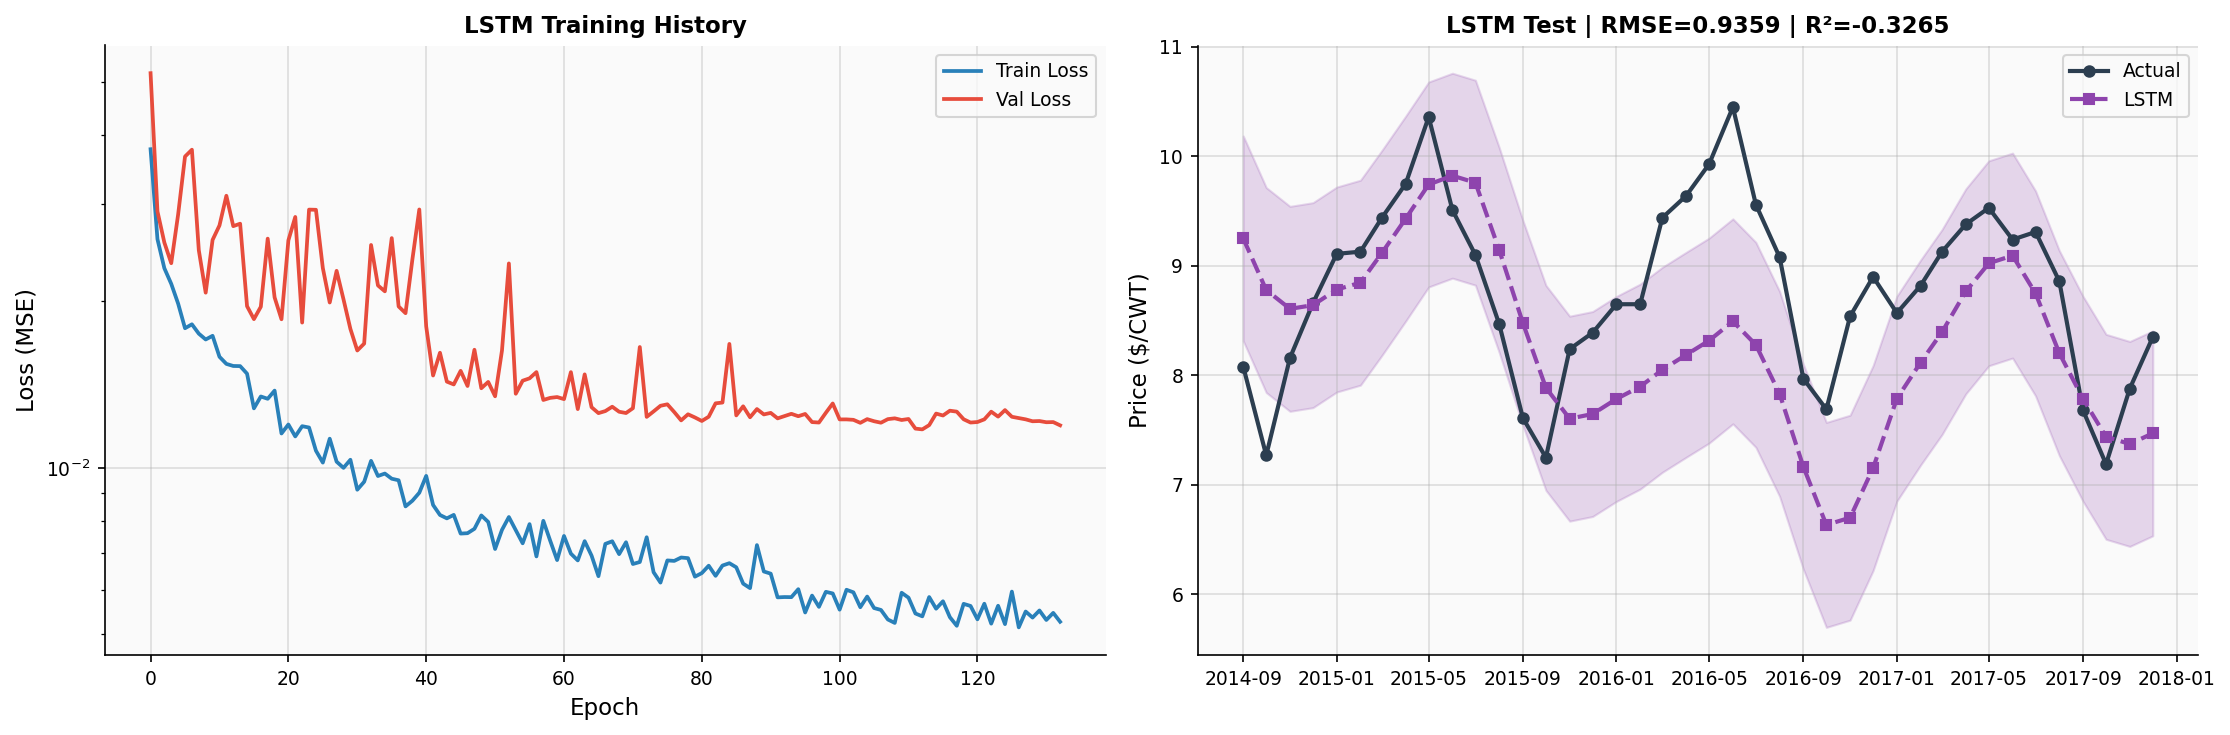

In [27]:
# ─── 11.3 LSTM predictions ───────────────────────────────────────────────────

# Load best model from Drive (guaranteed best weights)
lstm_best = tf.keras.models.load_model(LSTM_PATH)

lstm_preds_scaled = lstm_best.predict(X_lstm_test).flatten()
lstm_preds        = scaler_y.inverse_transform(lstm_preds_scaled.reshape(-1,1)).flatten()
y_test_lstm       = scaler_y.inverse_transform(y_lstm_test.reshape(-1,1)).flatten()
test_dates_lstm   = df_feat.index[val_end:]

lstm_metrics = compute_metrics(y_test_lstm, lstm_preds, 'LSTM')
results_table.append(lstm_metrics)

print("📊 LSTM Test Performance:")
for k, v in lstm_metrics.items():
    print(f"   {k:<15}: {v}")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(history.history['loss'],     color='#2980B9', lw=1.8, label='Train Loss')
axes[0].plot(history.history['val_loss'], color='#E74C3C', lw=1.8, label='Val Loss')
axes[0].set_title('LSTM Training History', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss (MSE)')
axes[0].legend(); axes[0].set_yscale('log')

axes[1].plot(test_dates_lstm, y_test_lstm, 'o-', color=MODEL_COLORS['Actual'], lw=2, ms=5, label='Actual')
axes[1].plot(test_dates_lstm, lstm_preds,  's--', color=MODEL_COLORS['LSTM'],  lw=2, ms=5, label='LSTM')
axes[1].fill_between(test_dates_lstm, lstm_preds-lstm_metrics['RMSE'], lstm_preds+lstm_metrics['RMSE'],
                     alpha=0.2, color=MODEL_COLORS['LSTM'])
axes[1].set_title(f'LSTM Test | RMSE={lstm_metrics["RMSE"]} | R²={lstm_metrics["R²"]}',
                  fontsize=11, fontweight='bold')
axes[1].set_ylabel('Price ($/CWT)'); axes[1].legend()
save_fig('fig12_lstm_results.png')
plt.show()
log_progress(f"LSTM complete: RMSE={lstm_metrics['RMSE']}")


---
## Section 12 — Model 6: Hybrid ARIMA-LSTM

> ARIMA captures linear trend → LSTM corrects the nonlinear residuals.  
> Hybrid model saved to `MyDrive/potato_research/models/hybrid_model.pkl`


In [28]:
# ─── 12.1 Stage 1: ARIMA residuals ──────────────────────────────────────────

arima_hybrid_fit = ARIMA(price_trainval, order=arima_auto.order).fit()
arima_fitted     = arima_hybrid_fit.fittedvalues
arima_residuals  = (price_trainval - arima_fitted).dropna()

print(f"Stage 1 complete | Residual mean: {arima_residuals.mean():.4f} | std: {arima_residuals.std():.4f}")

lb = acorr_ljungbox(arima_residuals, lags=[6,12,24], return_df=True)
print("\nLjung-Box test on residuals (remaining structure LSTM can learn):")
print(lb.to_string())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Stage 1 complete | Residual mean: 0.0800 | std: 0.7985

Ljung-Box test on residuals (remaining structure LSTM can learn):
      lb_stat  lb_pvalue
6    1.375219   0.967349
12   6.989674   0.858295
24  28.958311   0.221704


In [29]:
# ─── 12.2 Stage 2: LSTM on residuals ─────────────────────────────────────────

LOOKBACK_H = 12
res_scaler  = MinMaxScaler()
res_scaled  = res_scaler.fit_transform(arima_residuals.values.reshape(-1,1)).flatten()

def create_sequences_1d(y, lookback):
    Xs, ys = [], []
    for i in range(lookback, len(y)):
        Xs.append(y[i-lookback:i].reshape(-1,1)); ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_res, y_res = create_sequences_1d(res_scaled, LOOKBACK_H)
nr = len(X_res)
X_res_tr, y_res_tr = X_res[:int(nr*0.70)],    y_res[:int(nr*0.70)]
X_res_vl, y_res_vl = X_res[int(nr*0.70):int(nr*0.85)], y_res[int(nr*0.70):int(nr*0.85)]
X_res_te, y_res_te = X_res[int(nr*0.85):],    y_res[int(nr*0.85):]

HYBRID_LSTM_PATH = f'{MODELS_DIR}/hybrid_lstm_residual.keras'

lstm_res = Sequential([
    LSTM(32, return_sequences=True, input_shape=(LOOKBACK_H,1)),
    Dropout(0.2), LSTM(16), Dense(1)
])
lstm_res.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

lstm_res.fit(X_res_tr, y_res_tr, validation_data=(X_res_vl, y_res_vl),
             epochs=150, batch_size=16, verbose=1,
             callbacks=[
                 EarlyStopping(patience=15, restore_best_weights=True),
                 tf.keras.callbacks.ModelCheckpoint(HYBRID_LSTM_PATH, save_best_only=True)
             ])

res_preds_scaled = lstm_res.predict(X_res_te).flatten()
res_preds        = res_scaler.inverse_transform(res_preds_scaled.reshape(-1,1)).flatten()
print(f"\n✅ Residual LSTM trained | 💾 {HYBRID_LSTM_PATH}")

Epoch 1/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - loss: 0.0537 - val_loss: 0.0117
Epoch 2/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0060 - val_loss: 0.0146
Epoch 3/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0081 - val_loss: 0.0096
Epoch 4/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0054 - val_loss: 0.0096
Epoch 5/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0045 - val_loss: 0.0097
Epoch 6/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0053 - val_loss: 0.0094
Epoch 7/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0047 - val_loss: 0.0094
Epoch 8/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0049 - val_loss: 0.0094
Epoch 9/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0047 - val_loss: 0.0094
Epoch 10/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0049 - val_loss: 0.0094
Epoch 11/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0049 - val_loss: 0.0094
Epoch 12/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/ste

📊 Hybrid ARIMA-LSTM Test Performance:
   Model          : Hybrid ARIMA-LSTM
   RMSE           : 0.926
   MAE            : 0.7437
   MAPE           : 8.9315
   R²             : -0.3385
   Theil's U      : 1.6123
   💾 Drive/models/hybrid_model.pkl  (1995 KB)
   💾 Drive/figures/fig13_hybrid_results.png


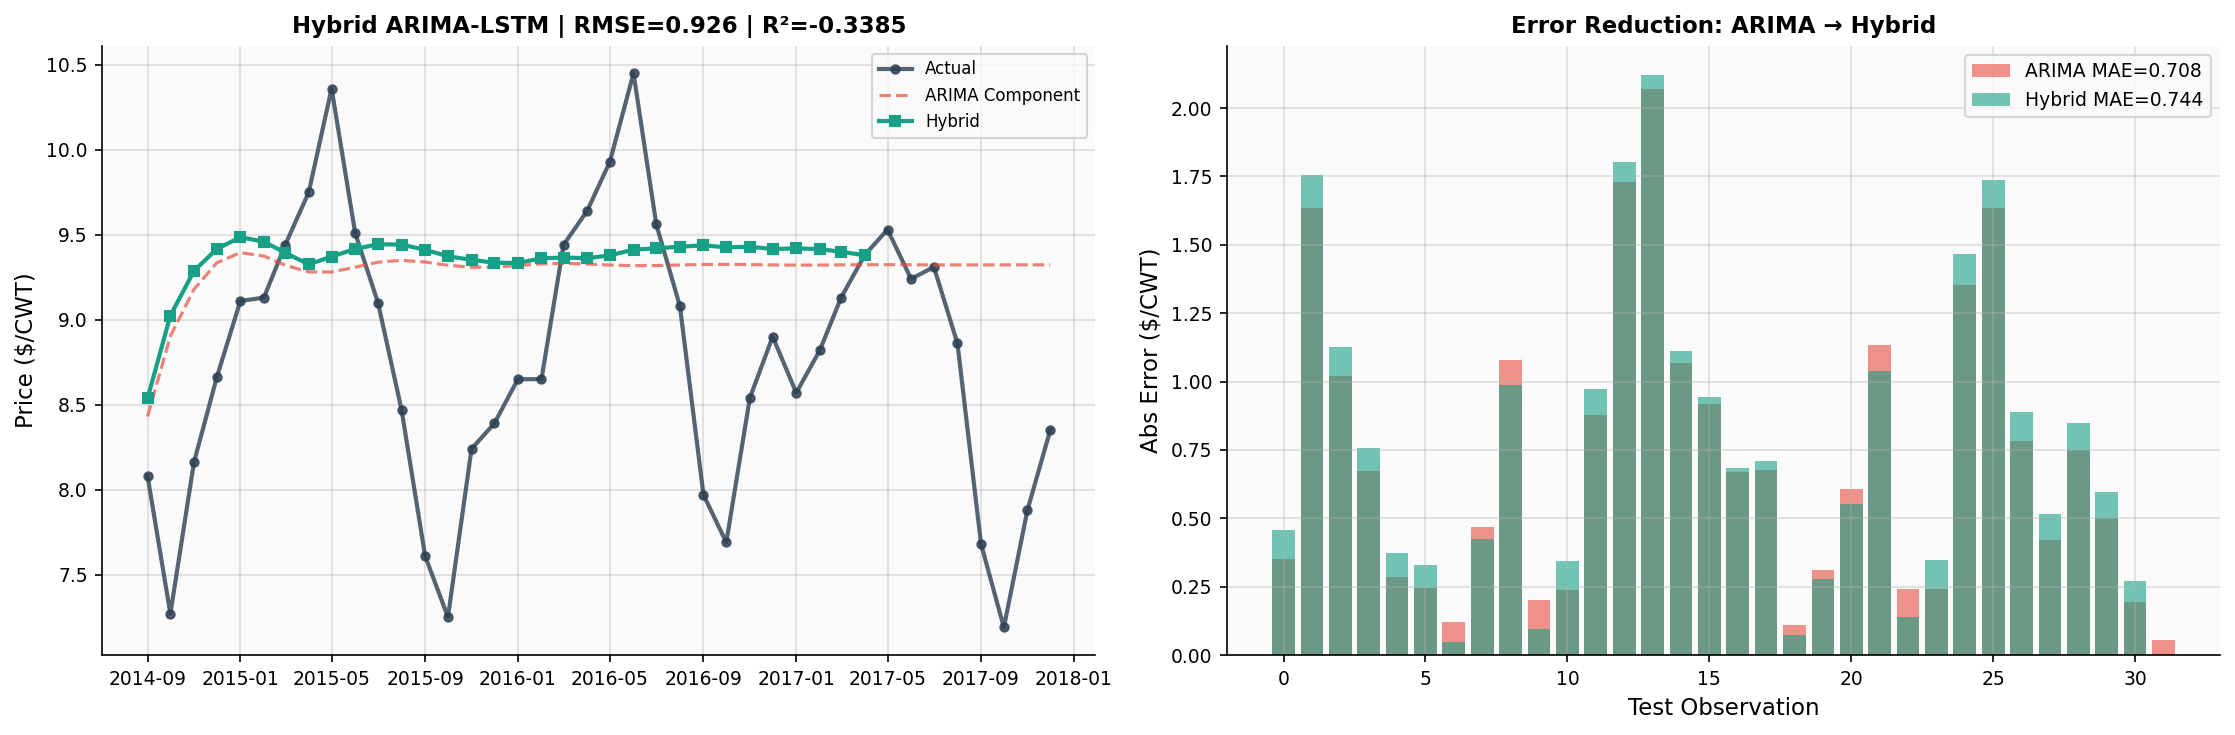

In [30]:
# ─── 12.3 Combine ARIMA + LSTM residual correction ───────────────────────────

arima_test_fc    = pd.Series(arima_hybrid_fit.forecast(steps=n_test).values, index=price_test.index)
n_hybrid         = min(len(res_preds), n_test)
hybrid_preds     = arima_test_fc.values[:n_hybrid] + res_preds[:n_hybrid]
y_test_hybrid    = y_test[:n_hybrid]
test_dates_hybrid= price_test.index[:n_hybrid]

hybrid_metrics = compute_metrics(y_test_hybrid, hybrid_preds, 'Hybrid ARIMA-LSTM')
results_table.append(hybrid_metrics)

print("📊 Hybrid ARIMA-LSTM Test Performance:")
for k, v in hybrid_metrics.items():
    print(f"   {k:<15}: {v}")

save_model({'arima_fit': arima_hybrid_fit, 'res_scaler': res_scaler,
            'arima_order': arima_auto.order}, 'hybrid_model.pkl')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(price_test.index,    y_test,                  'o-', color=MODEL_COLORS['Actual'],            lw=2, ms=4, label='Actual', alpha=0.8)
axes[0].plot(arima_test_fc.index, arima_test_fc,           '--', color=MODEL_COLORS['ARIMA'],             lw=1.5, label='ARIMA Component', alpha=0.7)
axes[0].plot(test_dates_hybrid,   hybrid_preds,            's-', color=MODEL_COLORS['Hybrid ARIMA-LSTM'], lw=2, ms=5, label='Hybrid')
axes[0].set_title(f'Hybrid ARIMA-LSTM | RMSE={hybrid_metrics["RMSE"]} | R²={hybrid_metrics["R²"]}',
                  fontsize=11, fontweight='bold')
axes[0].set_ylabel('Price ($/CWT)'); axes[0].legend(fontsize=8)

arima_err  = np.abs(arima_test_fc.values[:n_hybrid] - y_test_hybrid)
hybrid_err = np.abs(hybrid_preds - y_test_hybrid)
axes[1].bar(range(n_hybrid), arima_err,  alpha=0.6, color=MODEL_COLORS['ARIMA'],            label=f'ARIMA MAE={arima_err.mean():.3f}')
axes[1].bar(range(n_hybrid), hybrid_err, alpha=0.6, color=MODEL_COLORS['Hybrid ARIMA-LSTM'],label=f'Hybrid MAE={hybrid_err.mean():.3f}')
axes[1].set_title('Error Reduction: ARIMA → Hybrid', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Test Observation'); axes[1].set_ylabel('Abs Error ($/CWT)'); axes[1].legend()

save_fig('fig13_hybrid_results.png')
plt.show()
log_progress(f"Hybrid complete: RMSE={hybrid_metrics['RMSE']}")


---
## Section 13 — Model Comparison & Benchmarking

> Results saved to `MyDrive/potato_research/tables/table05_model_comparison.csv`


In [31]:
# ─── 13.1 Results table ──────────────────────────────────────────────────────

results_df = pd.DataFrame(results_table).sort_values('RMSE')

print("=" * 80)
print("  TABLE 5 — MODEL COMPARISON (Test Set Performance)")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80)

best_model = results_df.iloc[0]
arima_row  = results_df[results_df['Model']=='ARIMA'].iloc[0]
improve_pct= (arima_row['RMSE'] - best_model['RMSE']) / arima_row['RMSE'] * 100

print(f"\n🏆 Best Model: {best_model['Model']}")
print(f"   Improvement over ARIMA baseline: {improve_pct:.1f}% RMSE reduction")

save_table(results_df, 'table05_model_comparison.csv')
log_progress(f"Model comparison complete. Best: {best_model['Model']} RMSE={best_model['RMSE']}")


  TABLE 5 — MODEL COMPARISON (Test Set Performance)
            Model   RMSE    MAE    MAPE      R²  Theil's U
          XGBoost 0.4499 0.3588  4.0691  0.6935     0.7832
    Random Forest 0.4694 0.3897  4.5034  0.6663     0.8172
Hybrid ARIMA-LSTM 0.9260 0.7437  8.9315 -0.3385     1.6123
             LSTM 0.9359 0.7996  9.1212 -0.3265     1.6293
            ARIMA 0.9413 0.7406  9.0148 -0.3417     1.6386
           SARIMA 1.0325 0.9184 10.1511 -0.6145     1.7974

🏆 Best Model: XGBoost
   Improvement over ARIMA baseline: 52.2% RMSE reduction
   💾 Drive/tables/table05_model_comparison.csv  (6 rows)


   💾 Drive/figures/fig14_model_comparison.png


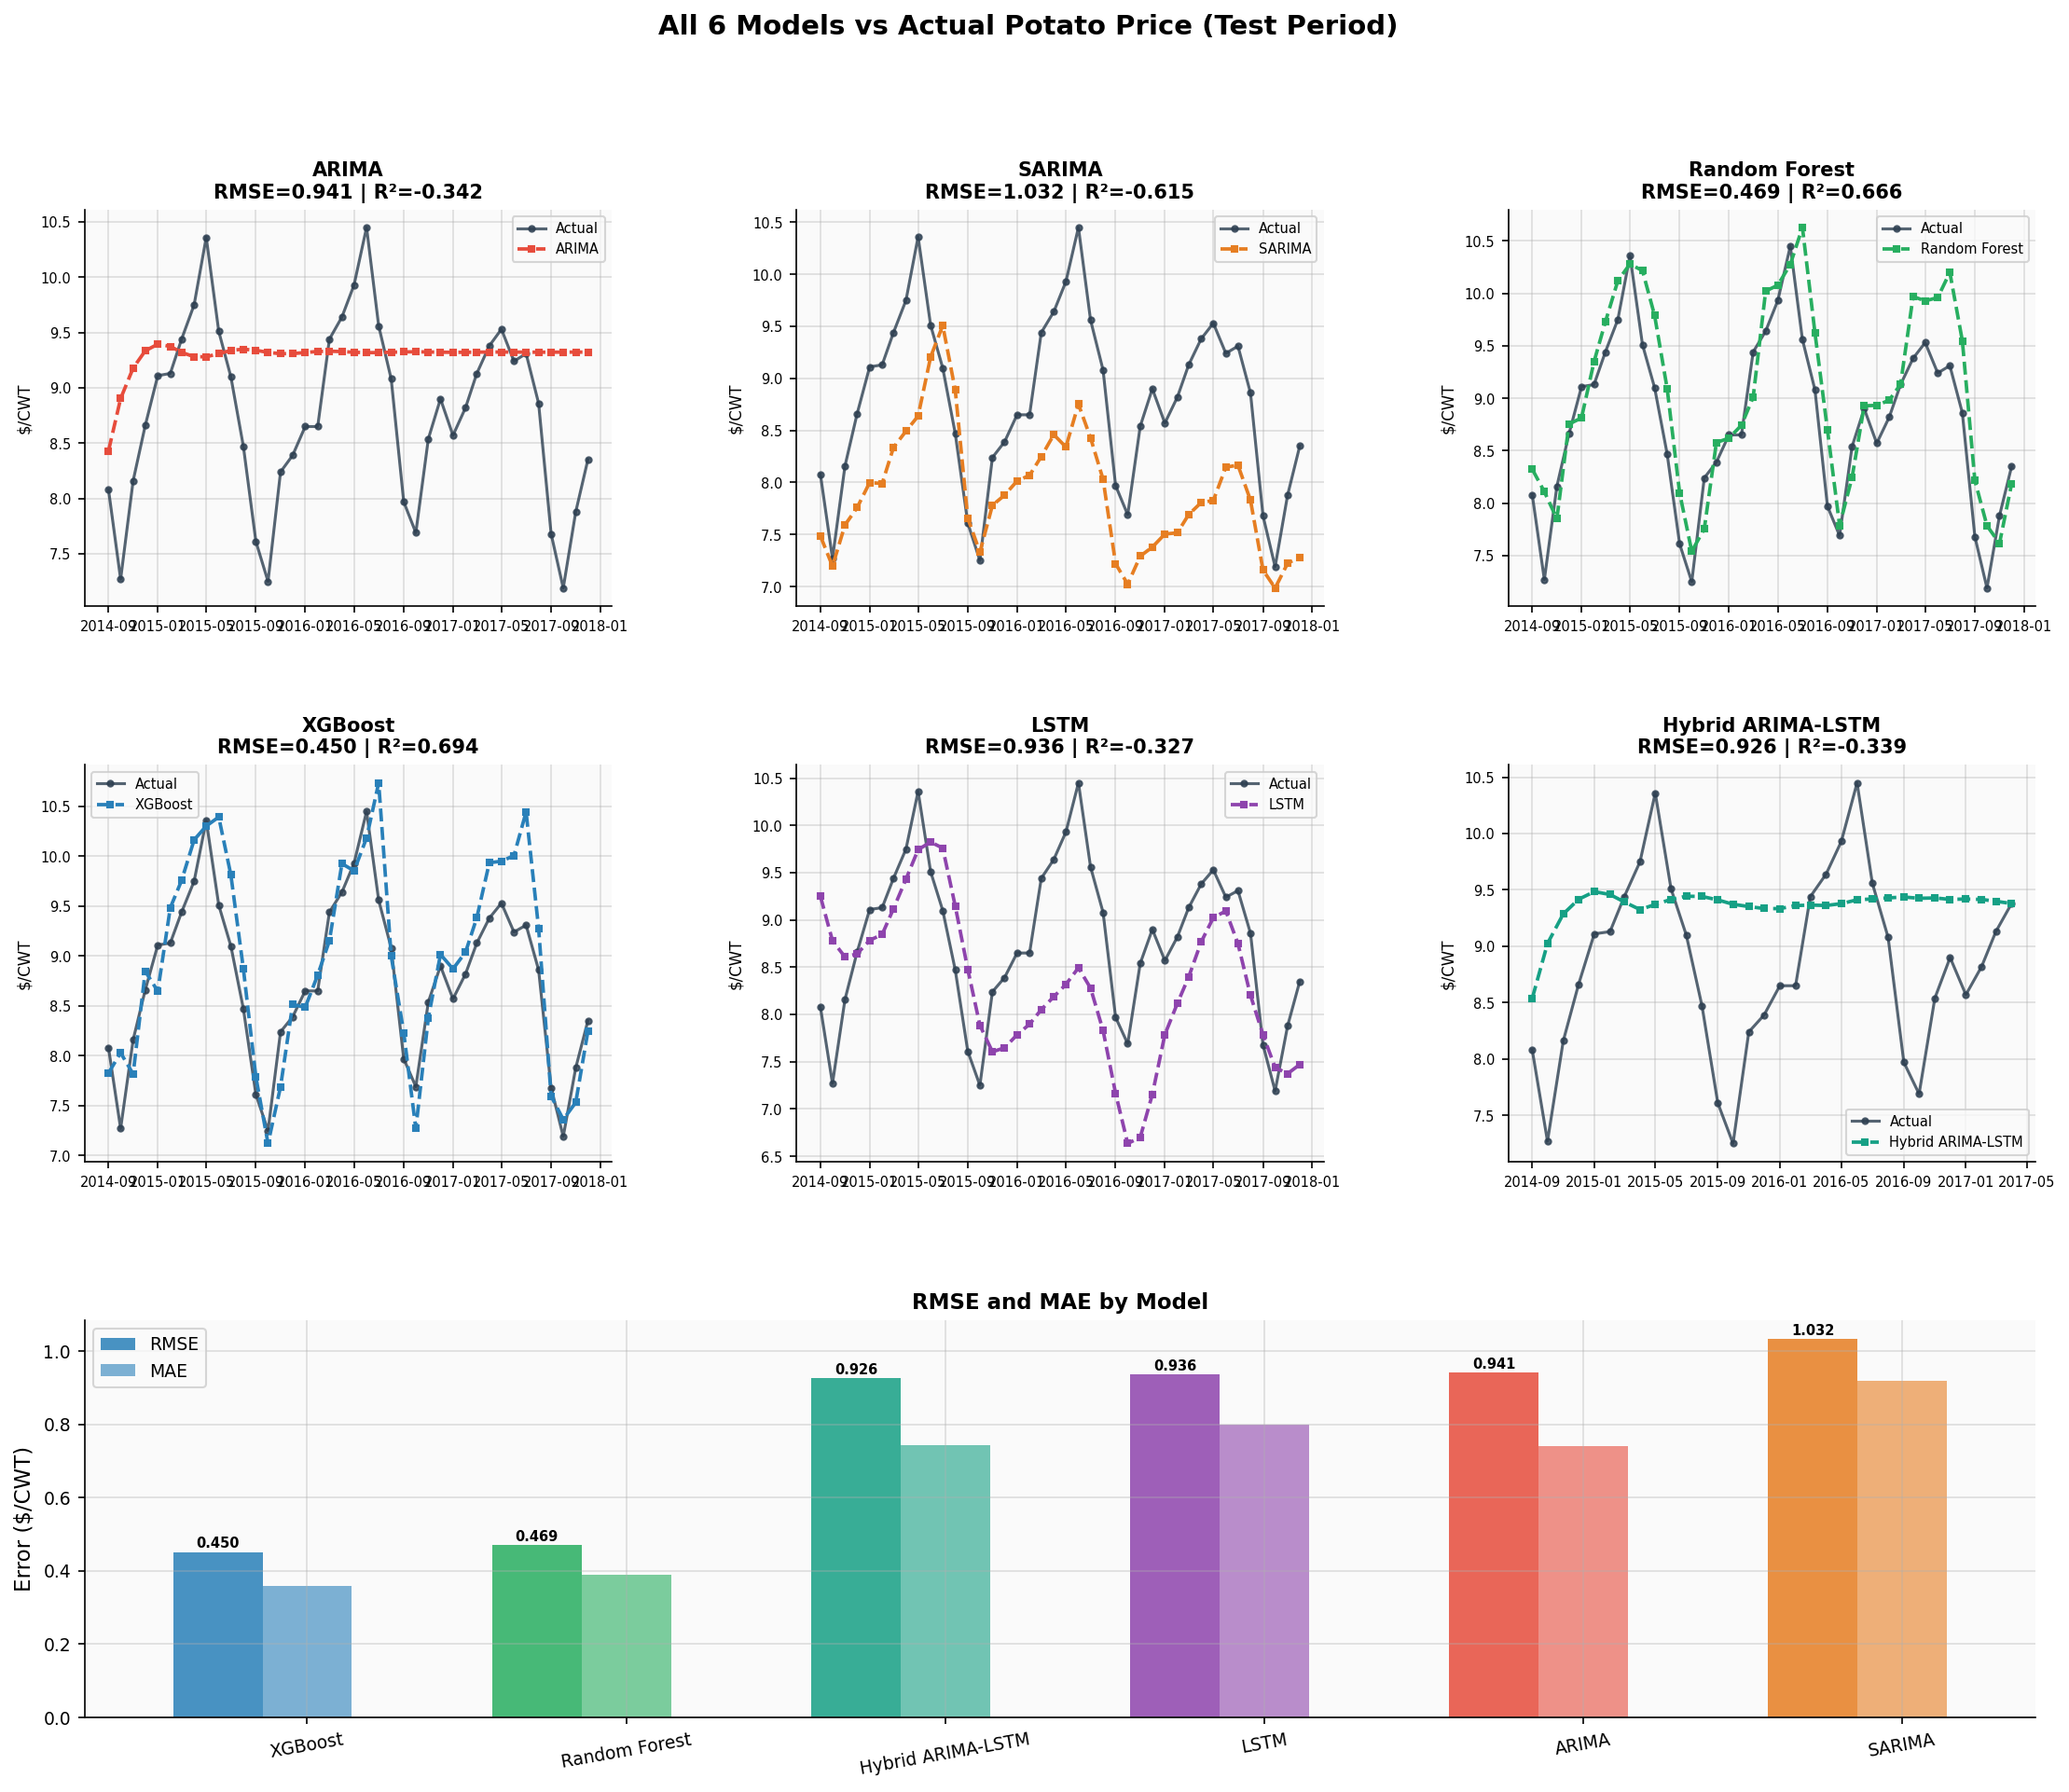

In [32]:
# ─── 13.2 Visual comparison ──────────────────────────────────────────────────

all_preds = {
    'ARIMA':             (price_test.index, arima_preds.values),
    'SARIMA':            (price_test.index, sarima_preds.values),
    'Random Forest':     (price_test.index, rf_preds),
    'XGBoost':           (price_test.index, xgb_preds),
    'LSTM':              (test_dates_lstm,  lstm_preds),
    'Hybrid ARIMA-LSTM': (test_dates_hybrid,hybrid_preds),
}

fig = plt.figure(figsize=(18, 14))
gs  = gridspec.GridSpec(3, 3, figure=fig, hspace=0.4, wspace=0.35)
fig.suptitle('All 6 Models vs Actual Potato Price (Test Period)', fontsize=14, fontweight='bold')

for i, (model_name, (dates, preds)) in enumerate(all_preds.items()):
    ax = fig.add_subplot(gs[i // 3, i % 3])
    actual_sub = df_feat.loc[dates, TARGET]
    ax.plot(dates, actual_sub, 'o-', color=MODEL_COLORS['Actual'], lw=1.5, ms=3, label='Actual', alpha=0.8)
    ax.plot(dates, preds, 's--', color=MODEL_COLORS[model_name], lw=1.8, ms=3, label=model_name)
    m = next((r for r in results_table if r['Model']==model_name), None)
    if m:
        ax.set_title(f'{model_name}\nRMSE={m["RMSE"]:.3f} | R²={m["R²"]:.3f}', fontsize=10, fontweight='bold')
    ax.set_ylabel('$/CWT', fontsize=8); ax.legend(fontsize=7); ax.tick_params(labelsize=7)

# Bottom bar chart
ax_bar = fig.add_subplot(gs[2, :])
x     = np.arange(len(results_df))
width = 0.28
colors_bar = [MODEL_COLORS.get(m,'gray') for m in results_df['Model']]
b1 = ax_bar.bar(x - width, results_df['RMSE'], width, label='RMSE', alpha=0.85, color=colors_bar)
b2 = ax_bar.bar(x,          results_df['MAE'],  width, label='MAE',  alpha=0.6,  color=colors_bar)
ax_bar.set_xticks(x); ax_bar.set_xticklabels(results_df['Model'], rotation=10, fontsize=9)
ax_bar.set_title('RMSE and MAE by Model', fontsize=11, fontweight='bold')
ax_bar.set_ylabel('Error ($/CWT)'); ax_bar.legend()
for bar in b1:
    ax_bar.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.005,
                f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=7, fontweight='bold')

save_fig('fig14_model_comparison.png')
plt.show()


In [33]:
# ─── 13.3 Diebold-Mariano test ───────────────────────────────────────────────

from scipy.stats import t as t_dist

def diebold_mariano(e1, e2, h=1):
    """DM test: H₀ = equal predictive accuracy. Negative stat → Model1 better."""
    d     = e1**2 - e2**2
    n     = len(d)
    d_bar = np.mean(d)
    var_d = np.var(d, ddof=1) / n
    dm    = d_bar / np.sqrt(max(var_d, 1e-10))
    p     = 2 * (1 - t_dist.cdf(abs(dm), df=n-1))
    return round(dm, 4), round(p, 4)

print("=" * 65)
print("  Diebold-Mariano Test: Best Model vs Each Competitor")
print(f"  Best model: {best_model['Model']}")
print("=" * 65)

dm_results = []
best_name  = best_model['Model']
pred_map   = {'ARIMA': arima_preds.values, 'SARIMA': sarima_preds.values,
              'Random Forest': rf_preds,   'XGBoost': xgb_preds}

for m_name in results_df['Model'].values:
    if m_name == best_name or m_name not in pred_map or best_name not in pred_map:
        continue
    best_e  = y_test - pred_map[best_name]
    other_e = y_test - pred_map[m_name]
    dm, p   = diebold_mariano(best_e, other_e)
    sig     = "✅ Sig." if p < 0.05 else "❌ Not sig."
    dm_results.append({'Comparison': f'{best_name} vs {m_name}', 'DM Stat': dm, 'p-value': p, 'Result': sig})
    print(f"  {best_name} vs {m_name:<20} | DM={dm:+.3f} | p={p:.4f} | {sig}")

dm_df = pd.DataFrame(dm_results)
save_table(dm_df, 'table05b_diebold_mariano.csv')
log_progress("Diebold-Mariano tests saved")


  Diebold-Mariano Test: Best Model vs Each Competitor
  Best model: XGBoost
  XGBoost vs Random Forest        | DM=-0.661 | p=0.5125 | ❌ Not sig.
  XGBoost vs ARIMA                | DM=-3.328 | p=0.0019 | ✅ Sig.
  XGBoost vs SARIMA               | DM=-5.687 | p=0.0000 | ✅ Sig.
   💾 Drive/tables/table05b_diebold_mariano.csv  (3 rows)


---
## Section 14 — SHAP Explainability Analysis ⭐

> SHAP values saved to `MyDrive/potato_research/tables/table06_shap_importance.csv`  
> All SHAP figures saved to `MyDrive/potato_research/figures/`


In [34]:
# ─── 14.1 Compute SHAP values ────────────────────────────────────────────────

print("🔍 Computing SHAP values for XGBoost... (30-60 seconds)")

explainer         = shap.TreeExplainer(xgb_model)
shap_values_test  = explainer.shap_values(X_test)
shap_values_train = explainer.shap_values(X_trainval)

mean_shap = pd.Series(np.abs(shap_values_test).mean(axis=0), index=FEATURES_ML).sort_values(ascending=False)

print("✅ SHAP values computed")
print("\n📊 Global Feature Importance (Mean |SHAP|):")
for feat, val in mean_shap.items():
    bar = '█' * int(val*60)
    print(f"   {feat:<30}: {val:.4f}  {bar}")

shap_imp_df = mean_shap.reset_index()
shap_imp_df.columns = ['Feature', 'Mean_SHAP']
save_table(shap_imp_df, 'table06_shap_importance.csv')
log_progress("SHAP values computed and saved")


🔍 Computing SHAP values for XGBoost... (30-60 seconds)
✅ SHAP values computed

📊 Global Feature Importance (Mean |SHAP|):
   Price_lag1                    : 1.3463  ████████████████████████████████████████████████████████████████████████████████
   Month_sin                     : 0.3208  ███████████████████
   CPI_AllItems                  : 0.1235  ███████
   Price_roll3_mean              : 0.1021  ██████
   Price_lag6                    : 0.0617  ███
   CPI_Vegetables                : 0.0595  ███
   PPI_x_Production              : 0.0554  ███
   Avg_Temp_F                    : 0.0507  ███
   Price_lag3                    : 0.0478  ██
   Price_roll6_mean              : 0.0389  ██
   Price_lag12                   : 0.0337  ██
   Precipitation_inch            : 0.0285  █
   PPI_FarmProducts              : 0.0264  █
   Month_cos                     : 0.0191  █
   Annual_Production_CWT         : 0.0180  █
   Price_lag2                    : 0.0168  █
   Price_roll12_mean             : 0.01

   💾 Drive/figures/fig15_shap_summary.png


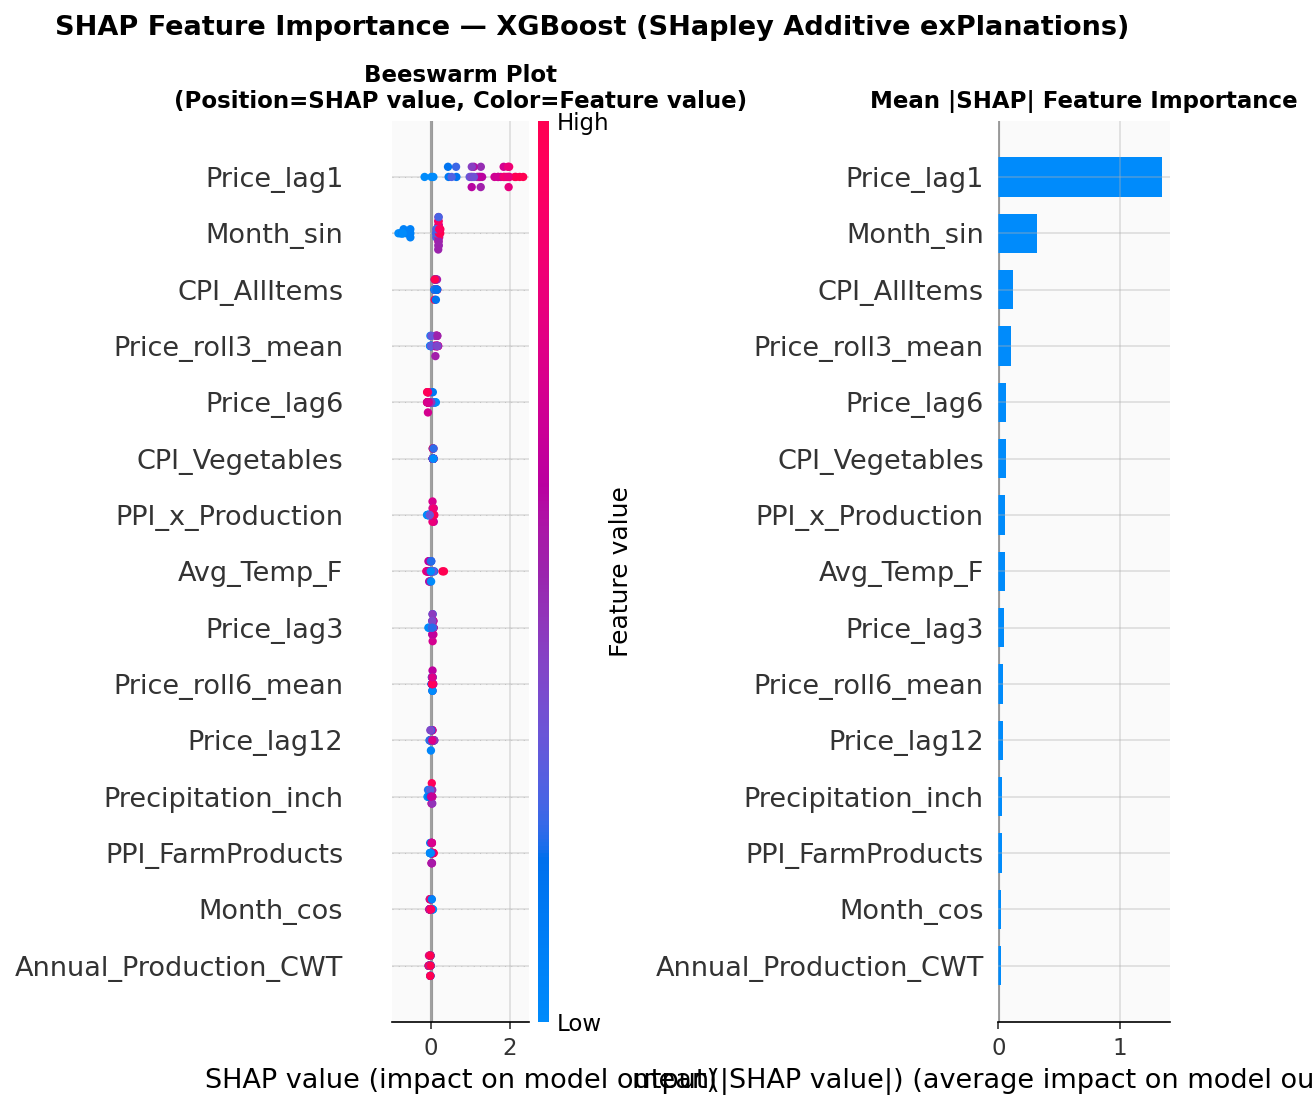

In [35]:
# ─── 14.2 SHAP summary plots ─────────────────────────────────────────────────

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('SHAP Feature Importance — XGBoost (SHapley Additive exPlanations)',
             fontsize=13, fontweight='bold')

plt.sca(axes[0])
shap.summary_plot(shap_values_test, X_test, feature_names=FEATURES_ML,
                  show=False, max_display=15, plot_type="dot")
axes[0].set_title('Beeswarm Plot\n(Position=SHAP value, Color=Feature value)', fontsize=11, fontweight='bold')

plt.sca(axes[1])
shap.summary_plot(shap_values_test, X_test, feature_names=FEATURES_ML,
                  show=False, max_display=15, plot_type="bar")
axes[1].set_title('Mean |SHAP| Feature Importance', fontsize=11, fontweight='bold')

plt.tight_layout()
save_fig('fig15_shap_summary.png')
plt.show()
log_progress("Fig15 saved: SHAP summary")


   💾 Drive/figures/fig16_shap_dependence.png


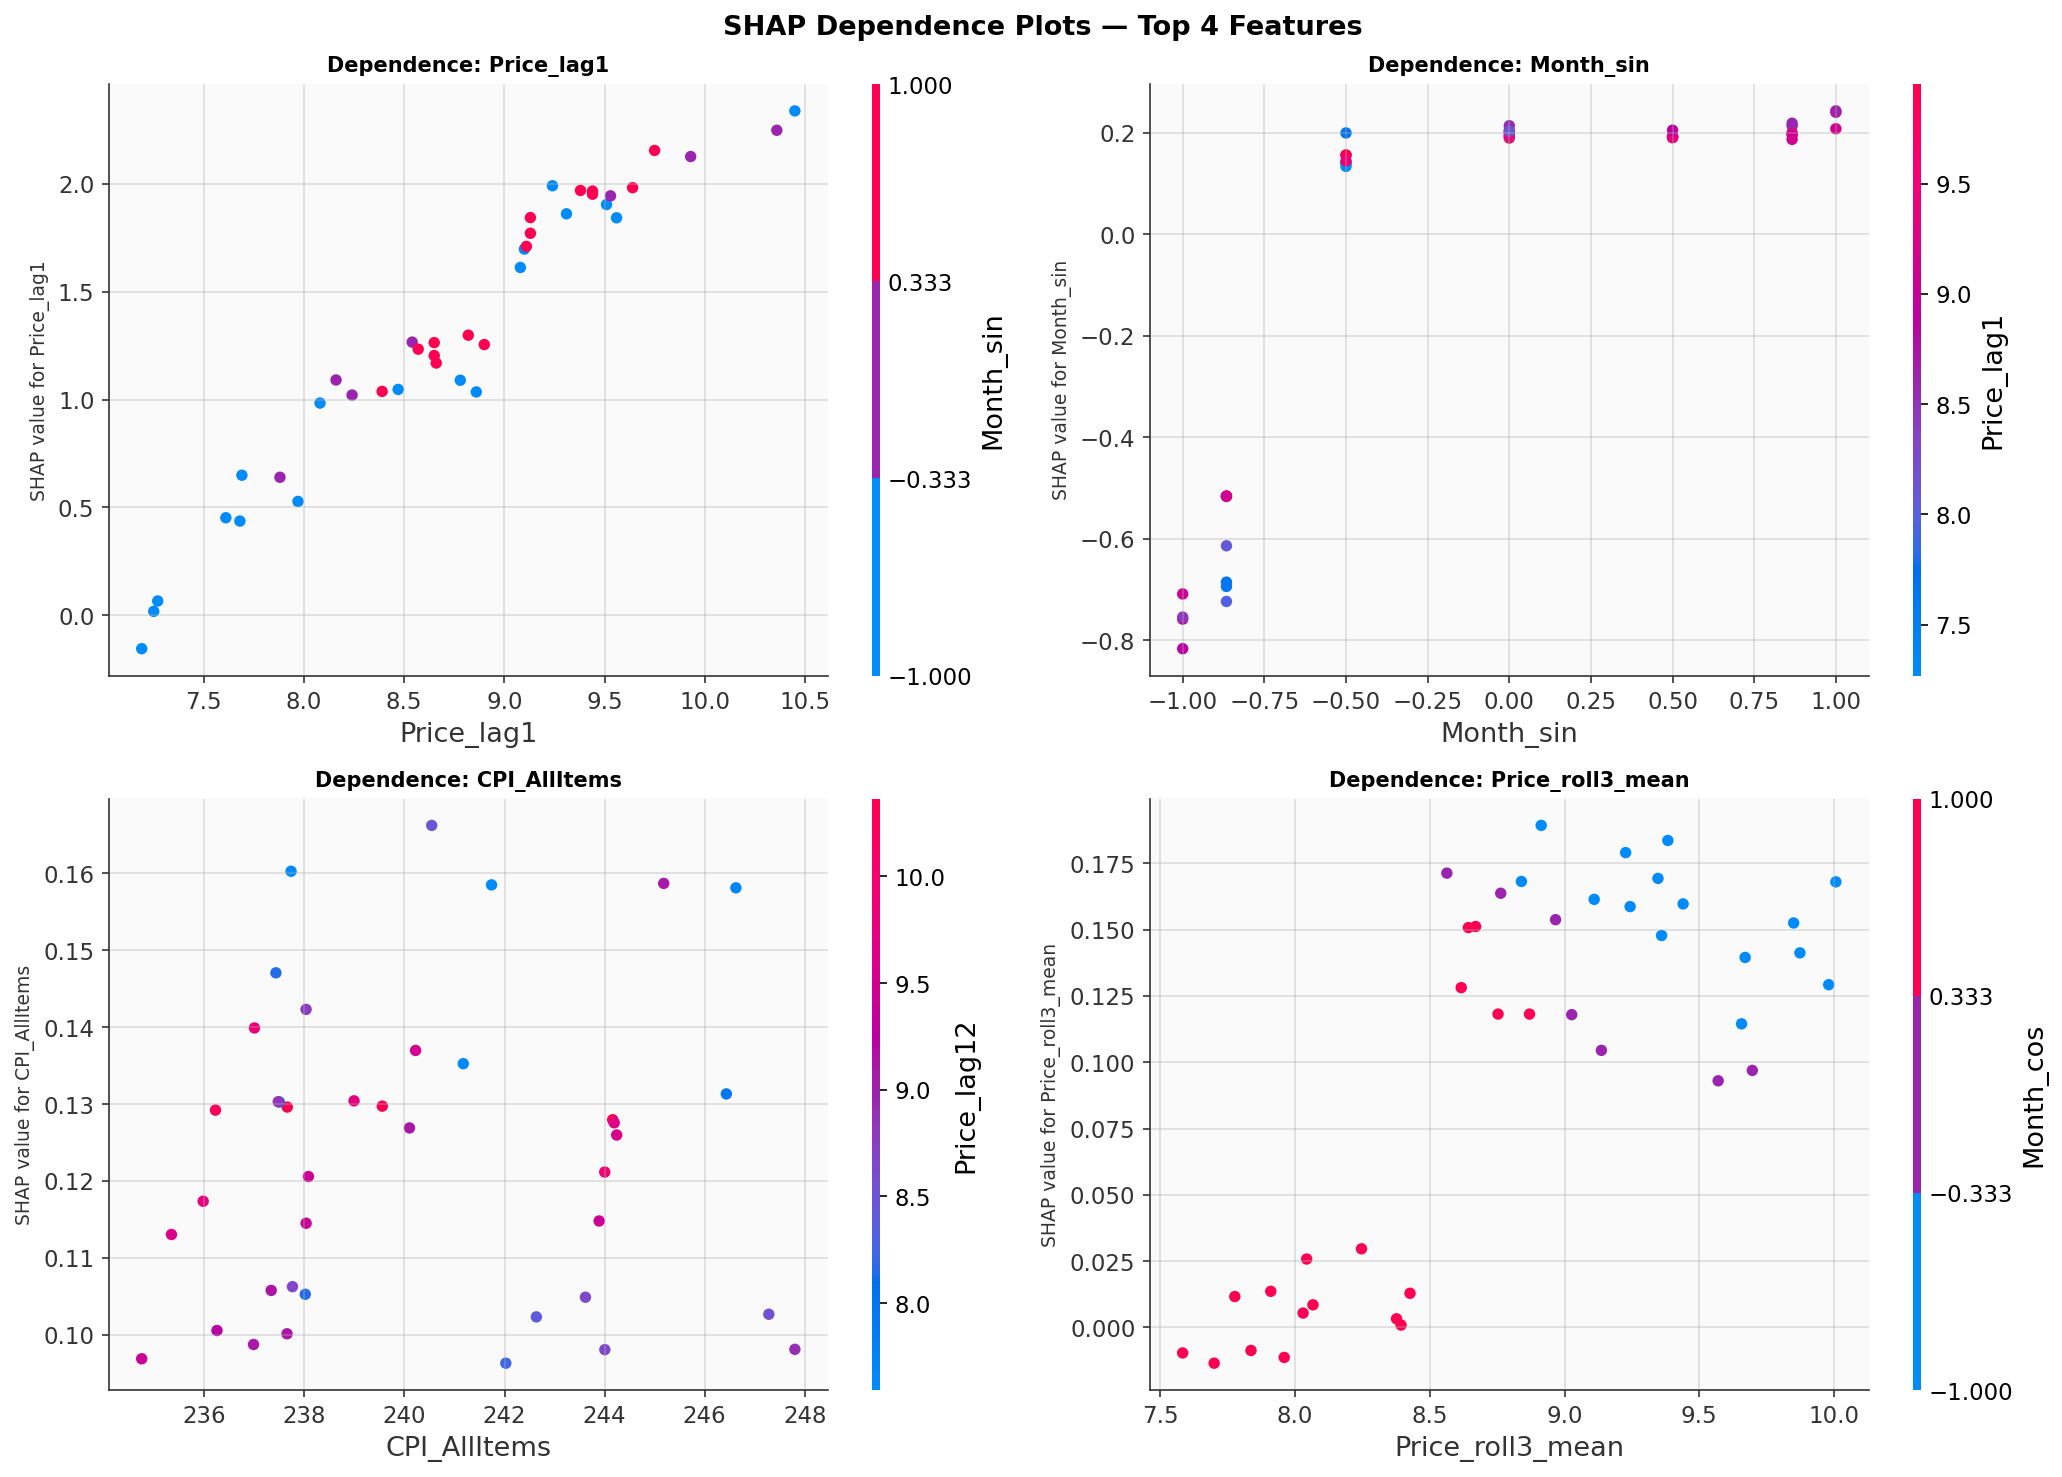

In [36]:
# ─── 14.3 SHAP dependence plots for top 4 features ──────────────────────────

top4 = mean_shap.head(4).index.tolist()
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('SHAP Dependence Plots — Top 4 Features', fontsize=13, fontweight='bold')

for ax, feat in zip(axes.flat, top4):
    feat_idx = FEATURES_ML.index(feat)
    shap.dependence_plot(feat_idx, shap_values_test, X_test,
                         feature_names=FEATURES_ML, ax=ax, show=False, dot_size=30)
    ax.set_title(f'Dependence: {feat}', fontsize=10, fontweight='bold')
    ax.set_ylabel(f'SHAP value for {feat}', fontsize=9)

save_fig('fig16_shap_dependence.png')
plt.show()
log_progress("Fig16 saved: SHAP dependence")


   💾 Drive/figures/fig17_shap_seasonal.png


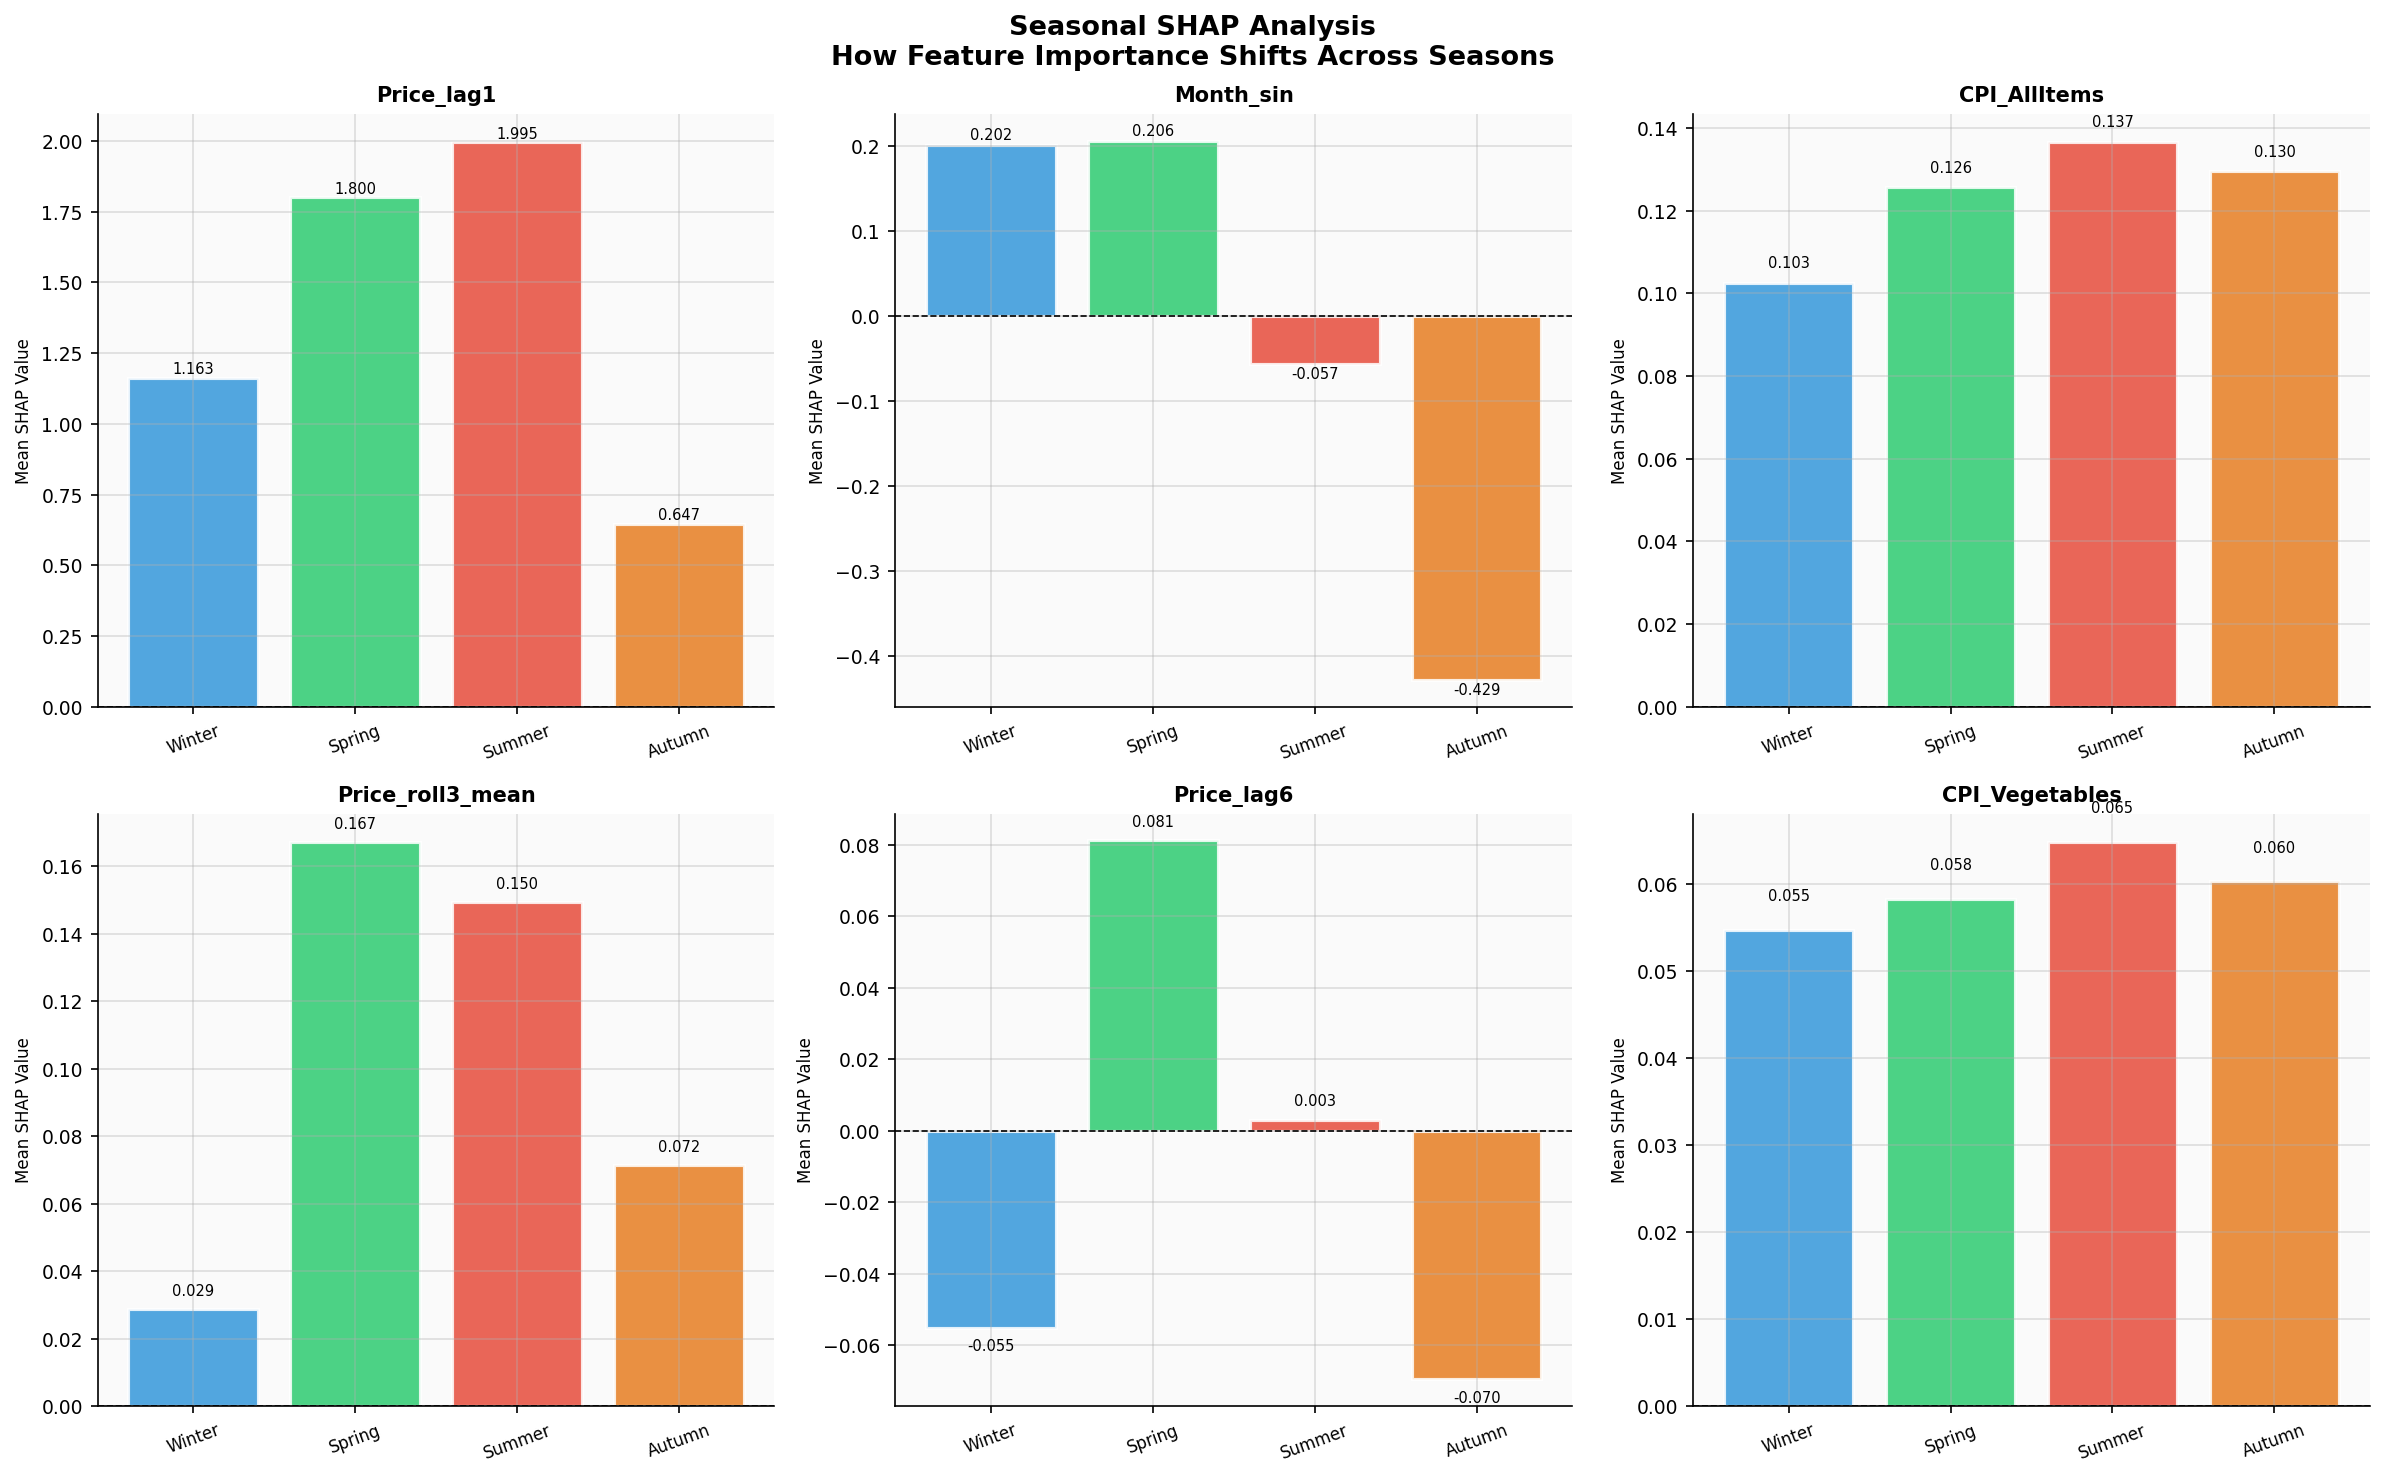

   💾 Drive/tables/table07_seasonal_shap.csv  (4 rows)


In [37]:
# ─── 14.4 Seasonal SHAP analysis ─────────────────────────────────────────────

shap_df_test   = pd.DataFrame(shap_values_test, columns=[f'SHAP_{f}' for f in FEATURES_ML],
                               index=df_test.index)
df_test_shap   = pd.concat([df_test, shap_df_test], axis=1)
season_map     = {1:'Winter',2:'Winter',3:'Spring',4:'Spring',5:'Spring',6:'Summer',
                  7:'Summer',8:'Summer',9:'Autumn',10:'Autumn',11:'Autumn',12:'Winter'}
df_test_shap['Season'] = df_test_shap['Month'].map(season_map)
seasons        = ['Winter','Spring','Summer','Autumn']
season_colors  = {'Winter':'#3498DB','Spring':'#2ECC71','Summer':'#E74C3C','Autumn':'#E67E22'}
top6           = mean_shap.head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Seasonal SHAP Analysis\nHow Feature Importance Shifts Across Seasons',
             fontsize=13, fontweight='bold')

for ax, feat in zip(axes.flat, top6):
    scol = f'SHAP_{feat}'
    if scol not in df_test_shap.columns: continue
    seasonal_shap = df_test_shap.groupby('Season')[scol].mean().reindex(seasons)
    bars = ax.bar(seasons, seasonal_shap.values,
                  color=[season_colors[s] for s in seasons], alpha=0.85, edgecolor='white', lw=1.5)
    ax.axhline(0, color='black', lw=0.8, ls='--')
    ax.set_title(feat, fontsize=10, fontweight='bold')
    ax.set_ylabel('Mean SHAP Value', fontsize=8)
    ax.tick_params(axis='x', rotation=20, labelsize=8)
    for bar, val in zip(bars, seasonal_shap.values):
        if not np.isnan(val):
            ax.text(bar.get_x()+bar.get_width()/2, val+np.sign(val)*0.003,
                    f'{val:.3f}', ha='center', va='bottom' if val>0 else 'top', fontsize=7)

save_fig('fig17_shap_seasonal.png')
plt.show()

# Save seasonal SHAP table
seasonal_shap_table = pd.DataFrame(
    {feat: df_test_shap.groupby('Season')[f'SHAP_{feat}'].mean().reindex(seasons)
     for feat in top6 if f'SHAP_{feat}' in df_test_shap.columns}
)
save_table(seasonal_shap_table.reset_index(), 'table07_seasonal_shap.csv')
log_progress("Fig17 saved: seasonal SHAP + table07")


---
## Section 15 — Ablation Study

> Quantifies the value of each data source by systematic feature removal.  
> Results saved to `MyDrive/potato_research/tables/table08_ablation_study.csv`


In [38]:
# ─── 15.1 Ablation configurations ────────────────────────────────────────────

feature_groups = {
    'Price Lags Only':              ['Price_lag1','Price_lag2','Price_lag3','Price_lag6','Price_lag12','Month_sin','Month_cos'],
    'Price + Production':           ['Price_lag1','Price_lag2','Price_lag3','Price_lag6','Price_lag12','Annual_Production_CWT','Month_sin','Month_cos'],
    'Price + Macro (no climate)':   ['Price_lag1','Price_lag2','Price_lag3','Price_lag6','Price_lag12','CPI_AllItems','CPI_Vegetables','PPI_FarmProducts','Annual_Production_CWT','Month_sin','Month_cos'],
    'Price + Climate (no macro)':   ['Price_lag1','Price_lag2','Price_lag3','Price_lag6','Price_lag12','Avg_Temp_F','Precipitation_inch','Annual_Production_CWT','Month_sin','Month_cos'],
    'All Features (Full Model)':    FEATURES_ML,
}

ablation_results = []
print("🔍 Ablation Study — XGBoost with different feature groups")
print("=" * 72)

for cfg_name, feat_list in feature_groups.items():
    avail = [f for f in feat_list if f in df_feat.columns]
    X_tv  = np.vstack([df_train[avail].values, df_val[avail].values])
    X_te  = df_test[avail].values
    m     = xgb.XGBRegressor(**xgb_search.best_params_, objective='reg:squarederror', random_state=42, n_jobs=-1)
    m.fit(X_tv, y_trainval)
    preds = m.predict(X_te)
    met   = compute_metrics(y_test, preds, cfg_name)
    ablation_results.append({'Configuration': cfg_name, 'N Features': len(avail),
                              'RMSE': met['RMSE'], 'MAE': met['MAE'],
                              'MAPE (%)': met['MAPE'], 'R²': met['R²']})
    print(f"  {cfg_name:<38} | N={len(avail):2d} | RMSE={met['RMSE']:.4f} | R²={met['R²']:.4f}")

ablation_df   = pd.DataFrame(ablation_results)
baseline_rmse = ablation_df.iloc[0]['RMSE']
full_rmse     = ablation_df.iloc[-1]['RMSE']
improvement   = (baseline_rmse - full_rmse) / baseline_rmse * 100

print(f"\n📊 Multi-source integration gain: {improvement:.1f}% RMSE reduction over price-only baseline")
save_table(ablation_df, 'table08_ablation_study.csv')
log_progress(f"Ablation study complete: {improvement:.1f}% gain")


🔍 Ablation Study — XGBoost with different feature groups
  Price Lags Only                        | N= 7 | RMSE=0.3619 | R²=0.8016
  Price + Production                     | N= 8 | RMSE=0.3873 | R²=0.7729
  Price + Macro (no climate)             | N=11 | RMSE=0.3662 | R²=0.7969
  Price + Climate (no macro)             | N=10 | RMSE=0.3904 | R²=0.7691
  All Features (Full Model)              | N=18 | RMSE=0.4499 | R²=0.6935

📊 Multi-source integration gain: -24.3% RMSE reduction over price-only baseline
   💾 Drive/tables/table08_ablation_study.csv  (5 rows)


   💾 Drive/figures/fig18_ablation_study.png


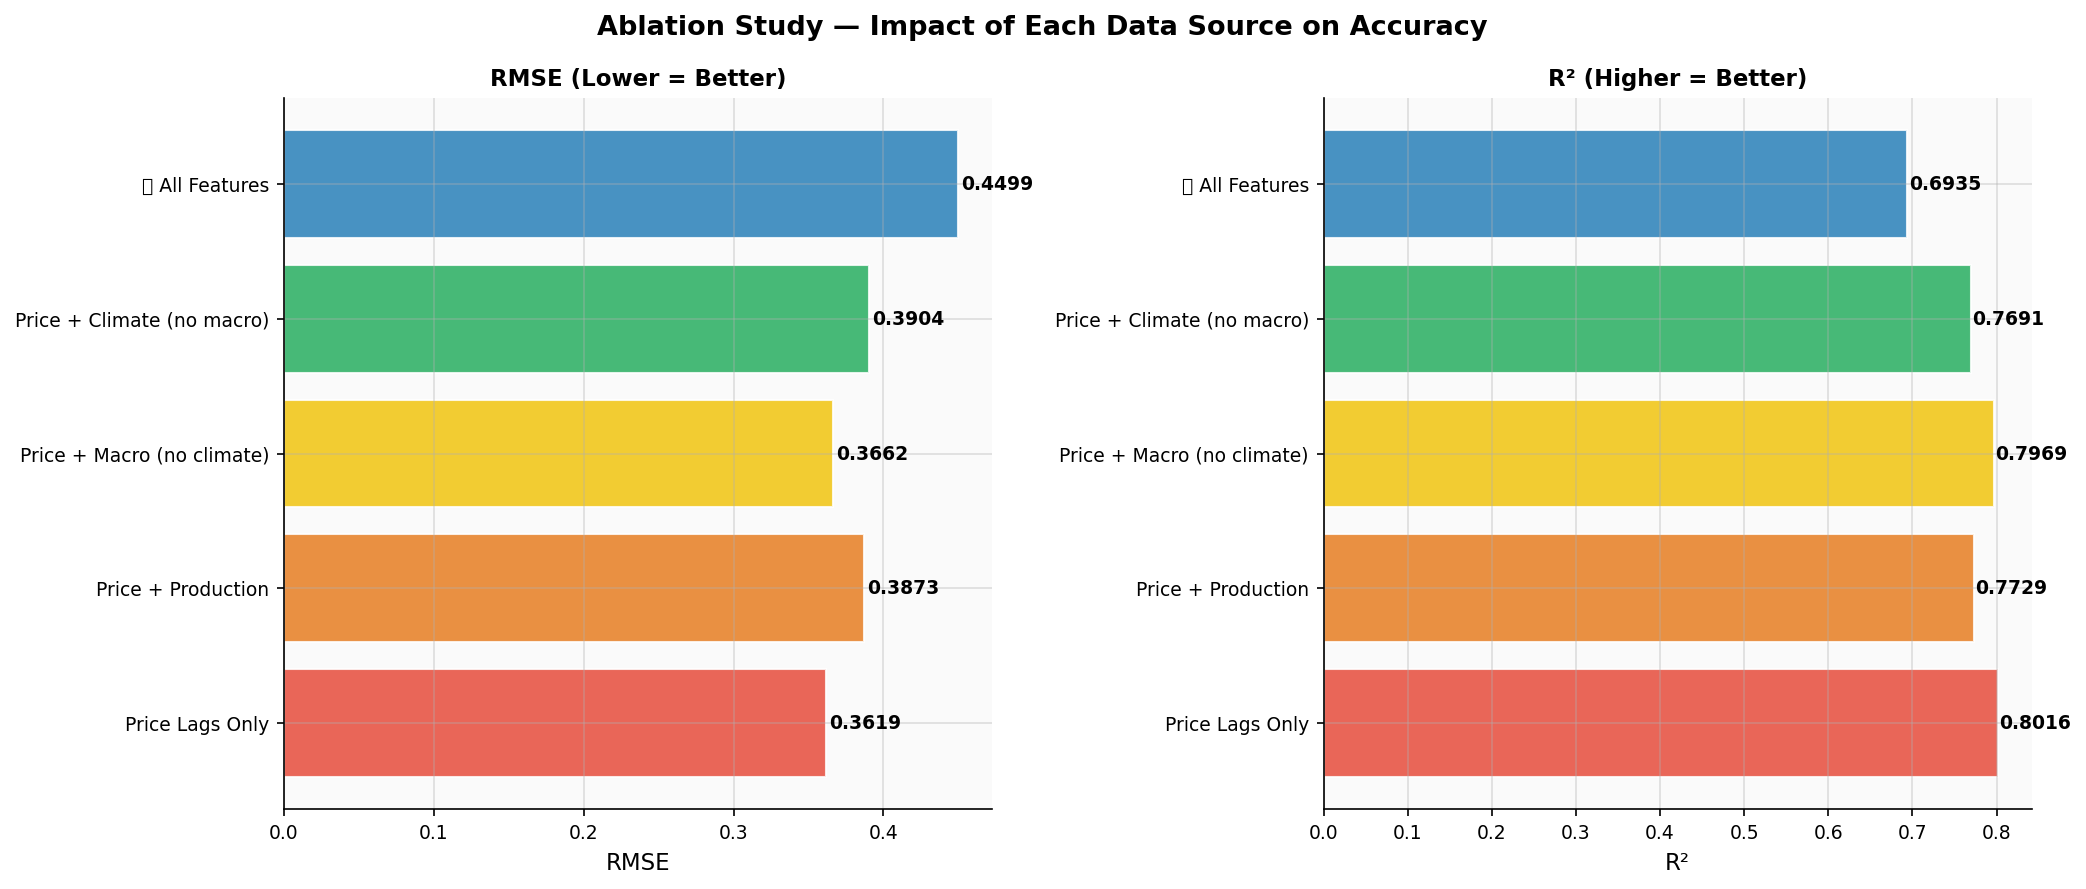

In [39]:
# ─── 15.2 Ablation visualization ─────────────────────────────────────────────

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Ablation Study — Impact of Each Data Source on Accuracy', fontsize=13, fontweight='bold')

colors_ab = ['#E74C3C','#E67E22','#F1C40F','#27AE60','#2980B9']
labels    = [c.replace(' (Full Model)','') for c in ablation_df['Configuration']]

for ax, metric, title, note in zip(axes,
                                    ['RMSE','R²'],
                                    ['RMSE (Lower = Better)','R² (Higher = Better)'],
                                    ['↓','↑']):
    bars = ax.barh(range(len(ablation_df)), ablation_df[metric],
                   color=colors_ab, alpha=0.85, edgecolor='white')
    ax.set_yticks(range(len(ablation_df)))
    ax.set_yticklabels([f"{'✅ ' if 'All' in l else ''}{l}" for l in labels], fontsize=9)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel(metric)
    for bar, val in zip(bars, ablation_df[metric]):
        ax.text(val + 0.002, bar.get_y()+bar.get_height()/2,
                f'{val:.4f}', va='center', fontsize=9, fontweight='bold')

save_fig('fig18_ablation_study.png')
plt.show()
log_progress("Fig18 saved: ablation study")


---
## Section 16 — Final Results Summary & Complete Drive Export

> Everything exported to Google Drive. You can safely close the browser after this.


In [40]:
# ─── 16.1 Print all paper-ready tables ───────────────────────────────────────

print("=" * 80)
print("  FINAL PAPER-READY RESULTS")
print("=" * 80)

print("\n📋 TABLE 2 — Stationarity Tests:")
print(stationarity_df.to_string(index=False))

print("\n📋 TABLE 3 — Granger Causality:")
print(granger_df.to_string(index=False))

print("\n📋 TABLE 5 — Model Comparison:")
print(results_df.to_string(index=False))

print("\n📋 TABLE 8 — Ablation Study:")
print(ablation_df.to_string(index=False))

best     = results_df.iloc[0]
arima_r  = results_df[results_df['Model']=='ARIMA'].iloc[0]
ml_gain  = (arima_r['RMSE'] - best['RMSE']) / arima_r['RMSE'] * 100
ab_gain  = (ablation_df.iloc[0]['RMSE'] - ablation_df.iloc[-1]['RMSE']) / ablation_df.iloc[0]['RMSE'] * 100

print("\n📊 ABSTRACT FILL-IN VALUES:")
print(f"   Best model:                   {best['Model']}")
print(f"   RMSE:                         {best['RMSE']}")
print(f"   MAE:                          {best['MAE']}")
print(f"   MAPE:                         {best['MAPE']}%")
print(f"   R²:                           {best['R²']}")
print(f"   Improvement over ARIMA:       {ml_gain:.1f}%")
print(f"   Multi-source gain vs lags-only:{ab_gain:.1f}%")
print("\n   → Paste these into your paper_analysis.docx abstract!")


  FINAL PAPER-READY RESULTS

📋 TABLE 2 — Stationarity Tests:
         Variable  ADF Stat  ADF p-value  ADF Lags  KPSS Stat  KPSS p-value       Conclusion
     Potato Price   -1.7246       0.4185        14     0.1502        0.0465 ❌ Non-Stationary
       Real Price   -4.8762       0.0000        13     0.1266        0.0858     ✅ Stationary
    CPI All Items   -0.5273       0.8866        12     0.2799        0.0100 ❌ Non-Stationary
   CPI Vegetables    1.2910       0.9966         7     0.5112        0.0100 ❌ Non-Stationary
PPI Farm Products   -1.6766       0.4432         1     0.1999        0.0160 ❌ Non-Stationary
      Temperature   -3.4212       0.0103        14     0.0131        0.1000     ✅ Stationary
    Precipitation   -3.1866       0.0208        11     0.1139        0.1000     ✅ Stationary
       Production   -1.9196       0.3229        12     0.2839        0.0100 ❌ Non-Stationary
 Price (1st diff)   -5.1619       0.0000        16     0.0382        0.1000     ✅ Stationary

📋 TABLE 

In [41]:
# ─── 16.2 Verify all files saved to Drive ────────────────────────────────────

print("=" * 65)
print("  GOOGLE DRIVE — SAVED FILES INVENTORY")
print("=" * 65)

for folder_name, folder_path in [('figures', FIGURES_DIR), ('tables', TABLES_DIR),
                                   ('models',  MODELS_DIR),  ('logs',   LOGS_DIR),
                                   ('datasets',DATA_DIR)]:
    files = sorted(os.listdir(folder_path))
    print(f"\n📁 MyDrive/potato_research/{folder_name}/ ({len(files)} files)")
    for fname in files:
        fpath = f'{folder_path}/{fname}'
        size  = os.path.getsize(fpath)
        unit  = 'KB' if size < 1024*1024 else 'MB'
        size_disp = size//1024 if size < 1024*1024 else size//(1024*1024)
        print(f"   {fname:<45} {size_disp:>4} {unit}")

print("\n✅ All files permanently saved to Google Drive!")
print("   You can safely close the browser now.")
log_progress("Session complete — all files saved to Drive")


  GOOGLE DRIVE — SAVED FILES INVENTORY

📁 MyDrive/potato_research/figures/ (18 files)
   fig01_price_time_series.png                    299 KB
   fig02_stl_decomposition.png                    304 KB
   fig03_seasonal_patterns.png                    167 KB
   fig04_correlation_heatmap.png                  189 KB
   fig05_all_features_overview.png                428 KB
   fig06_acf_pacf.png                             121 KB
   fig07_train_test_split.png                     125 KB
   fig08_arima_forecast.png                       242 KB
   fig09_sarima_forecast.png                      169 KB
   fig10_rf_results.png                           229 KB
   fig11_xgboost_results.png                      242 KB
   fig12_lstm_results.png                         201 KB
   fig13_hybrid_results.png                       141 KB
   fig14_model_comparison.png                     423 KB
   fig15_shap_summary.png                         136 KB
   fig16_shap_dependence.png                      190 KB
  

In [42]:
# ─── 16.3 Session recovery instructions ──────────────────────────────────────
# Print this as a reminder for next session

print("""
╔══════════════════════════════════════════════════════════════╗
║        HOW TO RESUME THIS NOTEBOOK IN A NEW SESSION         ║
╠══════════════════════════════════════════════════════════════╣
║                                                              ║
║  1. Open this notebook from Google Drive                     ║
║     (File → Open notebook → Google Drive tab)               ║
║                                                              ║
║  2. Run Sections 0 and 1 FIRST (always required):           ║
║     • Section 0 → mounts Drive, imports, defines paths      ║
║     • Section 1 → reloads dataset from Drive                ║
║                                                              ║
║  3. To reload a saved model (skip retraining):              ║
║     rf_model  = load_model('rf_model.pkl')                  ║
║     xgb_model = load_model('xgboost_model.pkl')             ║
║     lstm_model = tf.keras.models.load_model(LSTM_PATH)      ║
║                                                              ║
║  4. All your figures are at:                                 ║
║     MyDrive/potato_research/figures/                         ║
║                                                              ║
║  5. All result tables (CSV) are at:                          ║
║     MyDrive/potato_research/tables/                          ║
║                                                              ║
╚══════════════════════════════════════════════════════════════╝
""")



╔══════════════════════════════════════════════════════════════╗
║        HOW TO RESUME THIS NOTEBOOK IN A NEW SESSION         ║
╠══════════════════════════════════════════════════════════════╣
║                                                              ║
║  1. Open this notebook from Google Drive                     ║
║     (File → Open notebook → Google Drive tab)               ║
║                                                              ║
║  2. Run Sections 0 and 1 FIRST (always required):           ║
║     • Section 0 → mounts Drive, imports, defines paths      ║
║     • Section 1 → reloads dataset from Drive                ║
║                                                              ║
║  3. To reload a saved model (skip retraining):              ║
║     rf_model  = load_model('rf_model.pkl')                  ║
║     xgb_model = load_model('xgboost_model.pkl')             ║
║     lstm_model = tf.keras.models.load_model(LSTM_PATH)      ║
║                                